In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.relu0 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.relu1 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.relu2 = qnn.QuantReLU(bit_width=8, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.relu0(self.bn0(self.fc0(out))))
        out = self.drop1(self.relu1(self.bn1(self.fc1(out))))
        out = self.drop2(self.relu2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2516, Acc: 0.9227 | Val Loss: 0.1305, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9615 | Val Loss: 0.1181, Acc: 0.9648


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9707 | Val Loss: 0.1132, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9746 | Val Loss: 0.0974, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9796 | Val Loss: 0.1013, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1133, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 0.1046, Acc: 0.9715


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1052, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.1028, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0985, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0995, Acc: 0.9740


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.1080, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.1045, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1119, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.1007, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.1028, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1058, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1181, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1096, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1057, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0995, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1075, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1107, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1290, Acc: 0.9739


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9930 | Val Loss: 0.1177, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1147, Acc: 0.9735


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1025, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1011, Acc: 0.9727


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1049, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1307, Acc: 0.9727


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1174, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1112, Acc: 0.9754


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1185, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1204, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0918, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1124, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1178, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1275, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1022, Acc: 0.9757


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1111, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0987, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1347, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1196, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1248, Acc: 0.9744


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1175, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1342, Acc: 0.9732


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1529, Acc: 0.9754


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1476, Acc: 0.9742


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0969, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1142, Acc: 0.9777


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1292, Acc: 0.9740


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.1153, Acc: 0.9771


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1068, Acc: 0.9744


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1307, Acc: 0.9738


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1464, Acc: 0.9749


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1165, Acc: 0.9728


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1157, Acc: 0.9730


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1106, Acc: 0.9756


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1282, Acc: 0.9762


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1258, Acc: 0.9753


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.1128, Acc: 0.9750


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1414, Acc: 0.9729


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1263, Acc: 0.9739


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9962 | Val Loss: 0.1155, Acc: 0.9762


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1121, Acc: 0.9729


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1196, Acc: 0.9749


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1333, Acc: 0.9737


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1294, Acc: 0.9728


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1223, Acc: 0.9748


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1541, Acc: 0.9752


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1138, Acc: 0.9740


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1109, Acc: 0.9747


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1353, Acc: 0.9750


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1339, Acc: 0.9763


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1121, Acc: 0.9743


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0987, Acc: 0.9731


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1314, Acc: 0.9760


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1190, Acc: 0.9738


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1446, Acc: 0.9746


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1564, Acc: 0.9751


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1143, Acc: 0.9762


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1164, Acc: 0.9753


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1352, Acc: 0.9768


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0971, Acc: 0.9765


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1496, Acc: 0.9754


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1222, Acc: 0.9755


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.1358, Acc: 0.9752


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1205, Acc: 0.9748


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1189, Acc: 0.9747


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1240, Acc: 0.9752


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1181, Acc: 0.9747


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1104, Acc: 0.9764


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1495, Acc: 0.9751


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1151, Acc: 0.9737


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1176, Acc: 0.9738


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0879, Acc: 0.9767


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1418, Acc: 0.9754


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1366, Acc: 0.9748


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1002, Acc: 0.9728


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1303, Acc: 0.9770


Final Test Loss: 0.1249 Accuracy: 0.9779


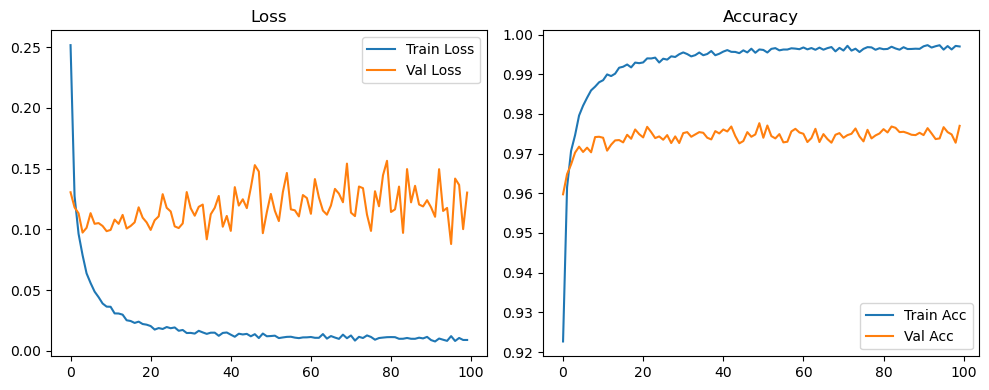

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3036, Acc: 0.9090 | Val Loss: 0.1510, Acc: 0.9553


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9477 | Val Loss: 0.1271, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9567 | Val Loss: 0.1110, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1221, Acc: 0.9621 | Val Loss: 0.1008, Acc: 0.9706


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9667 | Val Loss: 0.0999, Acc: 0.9715


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9688 | Val Loss: 0.1007, Acc: 0.9712


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9717 | Val Loss: 0.0932, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9758 | Val Loss: 0.0947, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9757 | Val Loss: 0.0899, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9788 | Val Loss: 0.0891, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.0853, Acc: 0.9746


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9807 | Val Loss: 0.0883, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9812 | Val Loss: 0.0970, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9825 | Val Loss: 0.0845, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9837 | Val Loss: 0.0964, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.0838, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9838 | Val Loss: 0.0914, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9840 | Val Loss: 0.0944, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.0816, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0864, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1040, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.0828, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0966, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0885, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9862 | Val Loss: 0.1012, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0994, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0907, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.0890, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0872, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0907, Acc: 0.9755


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1031, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1038, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.0921, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0831, Acc: 0.9758


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0992, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0836, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.1010, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.1025, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1018, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0804, Acc: 0.9759


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.1024, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9878 | Val Loss: 0.1055, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0935, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0930, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1005, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0926, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.1168, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.1184, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1183, Acc: 0.9767


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.0869, Acc: 0.9762


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9888 | Val Loss: 0.0973, Acc: 0.9746


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9883 | Val Loss: 0.0967, Acc: 0.9758


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9876 | Val Loss: 0.0968, Acc: 0.9763


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.1003, Acc: 0.9782


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9879 | Val Loss: 0.0924, Acc: 0.9777


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9887 | Val Loss: 0.0925, Acc: 0.9775


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1119, Acc: 0.9762


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.0849, Acc: 0.9772


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.0986, Acc: 0.9772


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.1066, Acc: 0.9760


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9893 | Val Loss: 0.0930, Acc: 0.9763


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.0873, Acc: 0.9751


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0977, Acc: 0.9770


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.1062, Acc: 0.9767


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9883 | Val Loss: 0.1150, Acc: 0.9761


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.0910, Acc: 0.9777


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0989, Acc: 0.9782


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.0973, Acc: 0.9775


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.1125, Acc: 0.9780


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0910, Acc: 0.9772


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.1030, Acc: 0.9768


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0974, Acc: 0.9780


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.0960, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0888, Acc: 0.9770


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0853, Acc: 0.9756


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.0832, Acc: 0.9781


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9889 | Val Loss: 0.0844, Acc: 0.9768


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.0997, Acc: 0.9782


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.1194, Acc: 0.9772


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9901 | Val Loss: 0.0841, Acc: 0.9766


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9887 | Val Loss: 0.1118, Acc: 0.9760


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0926, Acc: 0.9770


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0744, Acc: 0.9768


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9899 | Val Loss: 0.0833, Acc: 0.9778


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9892 | Val Loss: 0.0877, Acc: 0.9772


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9885 | Val Loss: 0.1058, Acc: 0.9755


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0920, Acc: 0.9769


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 0.1009, Acc: 0.9769


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0899, Acc: 0.9755


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.0966, Acc: 0.9751


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.0942, Acc: 0.9771


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.1139, Acc: 0.9756


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9895 | Val Loss: 0.0990, Acc: 0.9763


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0916, Acc: 0.9754


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.1004, Acc: 0.9754


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0855, Acc: 0.9768


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0851, Acc: 0.9783


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.1036, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0876, Acc: 0.9760


Final Test Loss: 0.0794 Accuracy: 0.9787


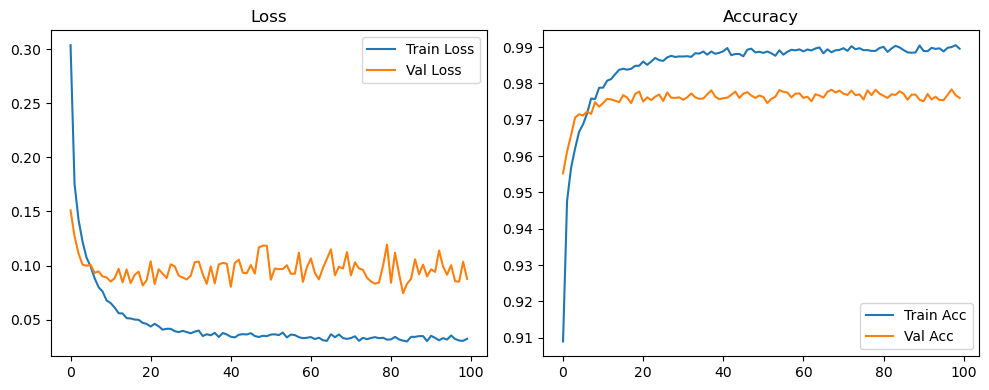

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4594, Acc: 0.8612 | Val Loss: 0.1777, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2966, Acc: 0.9134 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9242 | Val Loss: 0.1322, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2362, Acc: 0.9301 | Val Loss: 0.1266, Acc: 0.9616


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2154, Acc: 0.9369 | Val Loss: 0.1115, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2031, Acc: 0.9412 | Val Loss: 0.1087, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9433 | Val Loss: 0.1020, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1823, Acc: 0.9458 | Val Loss: 0.1050, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9474 | Val Loss: 0.1058, Acc: 0.9701


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1730, Acc: 0.9491 | Val Loss: 0.1061, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1569, Acc: 0.9524 | Val Loss: 0.1045, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1511, Acc: 0.9561 | Val Loss: 0.0980, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1519, Acc: 0.9549 | Val Loss: 0.1028, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1522, Acc: 0.9545 | Val Loss: 0.1003, Acc: 0.9713


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9573 | Val Loss: 0.1006, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9587 | Val Loss: 0.0958, Acc: 0.9726


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9601 | Val Loss: 0.0963, Acc: 0.9717


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9584 | Val Loss: 0.0971, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1392, Acc: 0.9589 | Val Loss: 0.0884, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1371, Acc: 0.9596 | Val Loss: 0.0920, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9592 | Val Loss: 0.0898, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9590 | Val Loss: 0.0911, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0898, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9600 | Val Loss: 0.0994, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1362, Acc: 0.9591 | Val Loss: 0.0971, Acc: 0.9724


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9596 | Val Loss: 0.0987, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1324, Acc: 0.9608 | Val Loss: 0.0912, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9621 | Val Loss: 0.0975, Acc: 0.9736


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9612 | Val Loss: 0.1028, Acc: 0.9729


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9735


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9609 | Val Loss: 0.0909, Acc: 0.9736


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9610 | Val Loss: 0.0953, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.0893, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1320, Acc: 0.9621 | Val Loss: 0.1056, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9628 | Val Loss: 0.0937, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9613 | Val Loss: 0.0972, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9625 | Val Loss: 0.0899, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1355, Acc: 0.9599 | Val Loss: 0.0962, Acc: 0.9735


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.0970, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.1051, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0946, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1285, Acc: 0.9623 | Val Loss: 0.0979, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1310, Acc: 0.9605 | Val Loss: 0.0958, Acc: 0.9729


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9614 | Val Loss: 0.0916, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9616 | Val Loss: 0.0922, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9605 | Val Loss: 0.0944, Acc: 0.9728


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9607 | Val Loss: 0.0910, Acc: 0.9756


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9619 | Val Loss: 0.0935, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9623 | Val Loss: 0.0946, Acc: 0.9735


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9621 | Val Loss: 0.0873, Acc: 0.9748


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.1272, Acc: 0.9623 | Val Loss: 0.0882, Acc: 0.9738


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.1303, Acc: 0.9606 | Val Loss: 0.0942, Acc: 0.9733


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9615 | Val Loss: 0.0906, Acc: 0.9738


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9607 | Val Loss: 0.0895, Acc: 0.9734


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9628 | Val Loss: 0.1013, Acc: 0.9726


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.1331, Acc: 0.9600 | Val Loss: 0.0925, Acc: 0.9725


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9614 | Val Loss: 0.1038, Acc: 0.9733


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9629 | Val Loss: 0.1059, Acc: 0.9728


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.1270, Acc: 0.9623 | Val Loss: 0.0873, Acc: 0.9743


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9623 | Val Loss: 0.0866, Acc: 0.9741


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.1265, Acc: 0.9617 | Val Loss: 0.0976, Acc: 0.9734


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.1295, Acc: 0.9613 | Val Loss: 0.0913, Acc: 0.9728


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9628 | Val Loss: 0.0925, Acc: 0.9747


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.1299, Acc: 0.9625 | Val Loss: 0.0883, Acc: 0.9745


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.1261, Acc: 0.9630 | Val Loss: 0.0903, Acc: 0.9738


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.1286, Acc: 0.9610 | Val Loss: 0.0976, Acc: 0.9727


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9619 | Val Loss: 0.1017, Acc: 0.9728


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9628 | Val Loss: 0.1059, Acc: 0.9728


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.1271, Acc: 0.9620 | Val Loss: 0.0962, Acc: 0.9745


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.1259, Acc: 0.9629 | Val Loss: 0.0989, Acc: 0.9733


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9625 | Val Loss: 0.0918, Acc: 0.9741


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.1264, Acc: 0.9629 | Val Loss: 0.0901, Acc: 0.9733


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.1246, Acc: 0.9624 | Val Loss: 0.0912, Acc: 0.9756


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9631 | Val Loss: 0.0974, Acc: 0.9736


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.1219, Acc: 0.9649 | Val Loss: 0.0871, Acc: 0.9753


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9623 | Val Loss: 0.1002, Acc: 0.9751


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.1270, Acc: 0.9621 | Val Loss: 0.0887, Acc: 0.9731


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9621 | Val Loss: 0.0928, Acc: 0.9728


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.1316, Acc: 0.9622 | Val Loss: 0.0907, Acc: 0.9748


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.1245, Acc: 0.9644 | Val Loss: 0.0884, Acc: 0.9734


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9627 | Val Loss: 0.0928, Acc: 0.9740


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.1269, Acc: 0.9626 | Val Loss: 0.0930, Acc: 0.9751


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9631 | Val Loss: 0.0909, Acc: 0.9729


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.1236, Acc: 0.9637 | Val Loss: 0.0934, Acc: 0.9724


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.1288, Acc: 0.9623 | Val Loss: 0.0909, Acc: 0.9721


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.1249, Acc: 0.9620 | Val Loss: 0.0988, Acc: 0.9747


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.1302, Acc: 0.9620 | Val Loss: 0.0904, Acc: 0.9746


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.1241, Acc: 0.9636 | Val Loss: 0.0987, Acc: 0.9745


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9636 | Val Loss: 0.0892, Acc: 0.9733


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9637 | Val Loss: 0.0923, Acc: 0.9739


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9620 | Val Loss: 0.0908, Acc: 0.9733


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.1272, Acc: 0.9624 | Val Loss: 0.1014, Acc: 0.9732


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.1322, Acc: 0.9617 | Val Loss: 0.0898, Acc: 0.9741


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.1335, Acc: 0.9610 | Val Loss: 0.0838, Acc: 0.9751


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9637 | Val Loss: 0.0959, Acc: 0.9750


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.1269, Acc: 0.9630 | Val Loss: 0.0950, Acc: 0.9731


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9640 | Val Loss: 0.0920, Acc: 0.9715


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.1218, Acc: 0.9644 | Val Loss: 0.1033, Acc: 0.9736


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9627 | Val Loss: 0.0959, Acc: 0.9744


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9633 | Val Loss: 0.0901, Acc: 0.9728


Final Test Loss: 0.0840 Accuracy: 0.9756


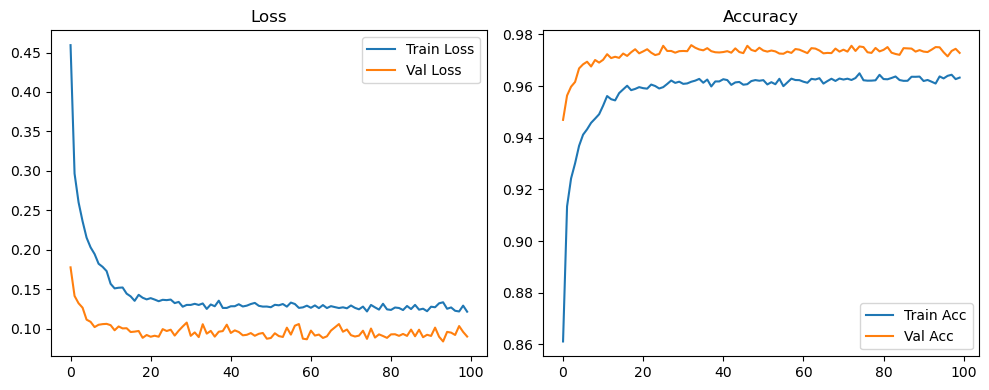

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2516, Acc: 0.9227 | Val Loss: 0.1305, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9615 | Val Loss: 0.1181, Acc: 0.9648


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9707 | Val Loss: 0.1132, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9746 | Val Loss: 0.0974, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9796 | Val Loss: 0.1013, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1133, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 0.1046, Acc: 0.9715


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1052, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.1028, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0985, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0995, Acc: 0.9740


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.1080, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.1045, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1119, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.1007, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.1028, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1058, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1181, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1096, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1057, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0995, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1075, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1107, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1290, Acc: 0.9739


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9930 | Val Loss: 0.1177, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1147, Acc: 0.9735


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1025, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1011, Acc: 0.9727


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1049, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1307, Acc: 0.9727


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1174, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1112, Acc: 0.9754


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1185, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1204, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0918, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1124, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1178, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1275, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1022, Acc: 0.9757


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1111, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0987, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1347, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1196, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1248, Acc: 0.9744


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1175, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1342, Acc: 0.9732


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1529, Acc: 0.9754


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1476, Acc: 0.9742


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0969, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1142, Acc: 0.9777


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1128, Acc: 0.9766


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1205, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1456, Acc: 0.9773


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1214, Acc: 0.9776


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1403, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1037, Acc: 0.9774


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1551, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1369, Acc: 0.9763


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1403, Acc: 0.9766


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1558, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1393, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1298, Acc: 0.9783


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1253, Acc: 0.9784


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1351, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1452, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1148, Acc: 0.9787


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1473, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0998, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1571, Acc: 0.9780


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1439, Acc: 0.9779


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1409, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1305, Acc: 0.9775


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1617, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1337, Acc: 0.9766


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1414, Acc: 0.9785


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1098, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1313, Acc: 0.9779


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1282, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1322, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1710, Acc: 0.9762


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1381, Acc: 0.9779


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1442, Acc: 0.9794


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1555, Acc: 0.9788


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1363, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1647, Acc: 0.9792


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1323, Acc: 0.9780


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1581, Acc: 0.9780


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2078, Acc: 0.9784


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1342, Acc: 0.9785


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1648, Acc: 0.9788


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1800, Acc: 0.9796


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1981, Acc: 0.9789


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1594, Acc: 0.9785


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1516, Acc: 0.9785


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1721, Acc: 0.9773


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1933, Acc: 0.9779


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1571, Acc: 0.9780


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1402, Acc: 0.9779


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1553, Acc: 0.9796


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1437, Acc: 0.9796


Final Test Loss: 0.1290 Accuracy: 0.9824


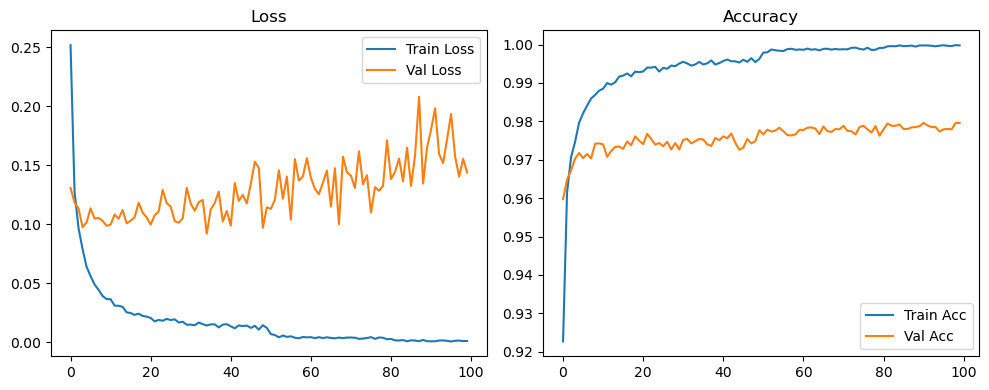

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3036, Acc: 0.9090 | Val Loss: 0.1510, Acc: 0.9553


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9477 | Val Loss: 0.1271, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9567 | Val Loss: 0.1110, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1221, Acc: 0.9621 | Val Loss: 0.1008, Acc: 0.9706


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9667 | Val Loss: 0.0999, Acc: 0.9715


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9688 | Val Loss: 0.1007, Acc: 0.9712


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9717 | Val Loss: 0.0932, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9758 | Val Loss: 0.0947, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9757 | Val Loss: 0.0899, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9788 | Val Loss: 0.0891, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.0853, Acc: 0.9746


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9807 | Val Loss: 0.0883, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9812 | Val Loss: 0.0970, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9825 | Val Loss: 0.0845, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9837 | Val Loss: 0.0964, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.0838, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9838 | Val Loss: 0.0914, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9840 | Val Loss: 0.0944, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.0816, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0864, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1040, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.0828, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0966, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0885, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9862 | Val Loss: 0.1012, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0994, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0907, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.0890, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0872, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0907, Acc: 0.9755


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1031, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1038, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.0921, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0831, Acc: 0.9758


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0992, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0836, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.1010, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.1025, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1018, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0804, Acc: 0.9759


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.1024, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9878 | Val Loss: 0.1055, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0935, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0930, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1005, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0926, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.1168, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.1184, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1183, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9903 | Val Loss: 0.0824, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0929, Acc: 0.9787


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0959, Acc: 0.9786


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9922 | Val Loss: 0.0933, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1078, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0930, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.0841, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1110, Acc: 0.9793


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0807, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0995, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0837, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1016, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0819, Acc: 0.9784


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1033, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1151, Acc: 0.9793


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.0892, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1082, Acc: 0.9783


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0894, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0932, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0944, Acc: 0.9778


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0979, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9949 | Val Loss: 0.1033, Acc: 0.9791


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1092, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0886, Acc: 0.9782


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0939, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0820, Acc: 0.9780


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0969, Acc: 0.9775


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0967, Acc: 0.9782


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1111, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1118, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0989, Acc: 0.9780


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1069, Acc: 0.9787


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1036, Acc: 0.9791


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0973, Acc: 0.9799


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0899, Acc: 0.9805


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1110, Acc: 0.9802


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0896, Acc: 0.9805


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1003, Acc: 0.9804


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0939, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1024, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0995, Acc: 0.9800


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0973, Acc: 0.9792


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0996, Acc: 0.9794


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0967, Acc: 0.9795


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0970, Acc: 0.9799


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0891, Acc: 0.9801


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1073, Acc: 0.9802


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0919, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1163, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0974, Acc: 0.9798


Final Test Loss: 0.0907 Accuracy: 0.9829


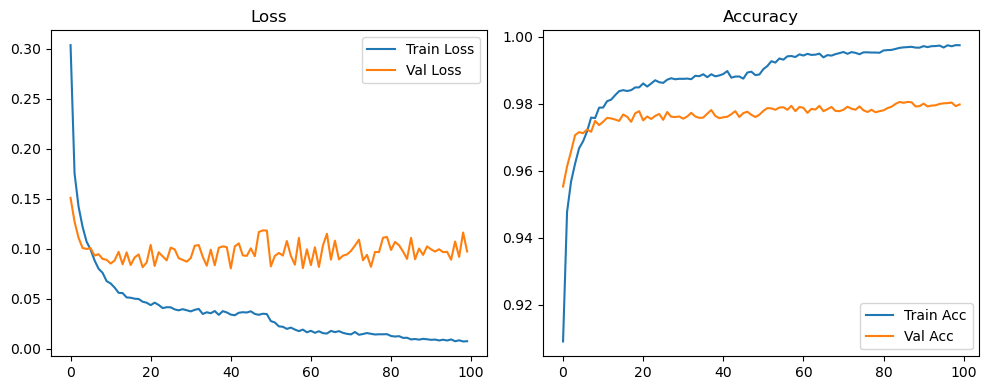

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4594, Acc: 0.8612 | Val Loss: 0.1777, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2966, Acc: 0.9134 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9242 | Val Loss: 0.1322, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2362, Acc: 0.9301 | Val Loss: 0.1266, Acc: 0.9616


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2154, Acc: 0.9369 | Val Loss: 0.1115, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2031, Acc: 0.9412 | Val Loss: 0.1087, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9433 | Val Loss: 0.1020, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1823, Acc: 0.9458 | Val Loss: 0.1050, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9474 | Val Loss: 0.1058, Acc: 0.9701


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1730, Acc: 0.9491 | Val Loss: 0.1061, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1569, Acc: 0.9524 | Val Loss: 0.1045, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1511, Acc: 0.9561 | Val Loss: 0.0980, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1519, Acc: 0.9549 | Val Loss: 0.1028, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1522, Acc: 0.9545 | Val Loss: 0.1003, Acc: 0.9713


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9573 | Val Loss: 0.1006, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9587 | Val Loss: 0.0958, Acc: 0.9726


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9601 | Val Loss: 0.0963, Acc: 0.9717


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9584 | Val Loss: 0.0971, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1392, Acc: 0.9589 | Val Loss: 0.0884, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1371, Acc: 0.9596 | Val Loss: 0.0920, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9592 | Val Loss: 0.0898, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9590 | Val Loss: 0.0911, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0898, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9600 | Val Loss: 0.0994, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1362, Acc: 0.9591 | Val Loss: 0.0971, Acc: 0.9724


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9596 | Val Loss: 0.0987, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1324, Acc: 0.9608 | Val Loss: 0.0912, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9621 | Val Loss: 0.0975, Acc: 0.9736


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9612 | Val Loss: 0.1028, Acc: 0.9729


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9735


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9609 | Val Loss: 0.0909, Acc: 0.9736


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9610 | Val Loss: 0.0953, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.0893, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1320, Acc: 0.9621 | Val Loss: 0.1056, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9628 | Val Loss: 0.0937, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9613 | Val Loss: 0.0972, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9625 | Val Loss: 0.0899, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1355, Acc: 0.9599 | Val Loss: 0.0962, Acc: 0.9735


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.0970, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.1051, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0946, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1285, Acc: 0.9623 | Val Loss: 0.0979, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1310, Acc: 0.9605 | Val Loss: 0.0958, Acc: 0.9729


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9614 | Val Loss: 0.0916, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9616 | Val Loss: 0.0922, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9605 | Val Loss: 0.0944, Acc: 0.9728


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9607 | Val Loss: 0.0910, Acc: 0.9756


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9619 | Val Loss: 0.0935, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9623 | Val Loss: 0.0946, Acc: 0.9735


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9621 | Val Loss: 0.0873, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.1201, Acc: 0.9640 | Val Loss: 0.0871, Acc: 0.9752


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.1114, Acc: 0.9669 | Val Loss: 0.1049, Acc: 0.9749


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.1081, Acc: 0.9675 | Val Loss: 0.0830, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.1069, Acc: 0.9678 | Val Loss: 0.0855, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.1016, Acc: 0.9697 | Val Loss: 0.0940, Acc: 0.9757


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.1011, Acc: 0.9694 | Val Loss: 0.0843, Acc: 0.9767


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.1018, Acc: 0.9698 | Val Loss: 0.0836, Acc: 0.9755


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0968, Acc: 0.9711 | Val Loss: 0.0928, Acc: 0.9758


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9714 | Val Loss: 0.0979, Acc: 0.9757


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9719 | Val Loss: 0.0813, Acc: 0.9758


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9710 | Val Loss: 0.1079, Acc: 0.9753


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0930, Acc: 0.9714 | Val Loss: 0.0860, Acc: 0.9747


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9729 | Val Loss: 0.0911, Acc: 0.9765


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9733 | Val Loss: 0.0836, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0906, Acc: 0.9725 | Val Loss: 0.0867, Acc: 0.9757


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9728 | Val Loss: 0.0875, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9719 | Val Loss: 0.0850, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0901, Acc: 0.9730 | Val Loss: 0.0852, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9738 | Val Loss: 0.0939, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9738 | Val Loss: 0.1022, Acc: 0.9755


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9722 | Val Loss: 0.0877, Acc: 0.9761


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0870, Acc: 0.9743 | Val Loss: 0.0884, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9742 | Val Loss: 0.0939, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9735 | Val Loss: 0.0845, Acc: 0.9765


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9745 | Val Loss: 0.0854, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0920, Acc: 0.9730 | Val Loss: 0.0856, Acc: 0.9767


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9740 | Val Loss: 0.0873, Acc: 0.9751


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9738 | Val Loss: 0.1076, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0873, Acc: 0.9738 | Val Loss: 0.0950, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9744 | Val Loss: 0.0956, Acc: 0.9773


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0789, Acc: 0.9761 | Val Loss: 0.0863, Acc: 0.9768


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9753 | Val Loss: 0.0950, Acc: 0.9772


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0778, Acc: 0.9772 | Val Loss: 0.0929, Acc: 0.9774


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0777, Acc: 0.9756 | Val Loss: 0.0846, Acc: 0.9777


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9771 | Val Loss: 0.0883, Acc: 0.9766


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0747, Acc: 0.9772 | Val Loss: 0.0924, Acc: 0.9770


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0780, Acc: 0.9770 | Val Loss: 0.0935, Acc: 0.9779


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0759, Acc: 0.9776 | Val Loss: 0.0861, Acc: 0.9777


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0725, Acc: 0.9780 | Val Loss: 0.0849, Acc: 0.9779


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0687, Acc: 0.9791 | Val Loss: 0.0798, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9797 | Val Loss: 0.0859, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9787 | Val Loss: 0.0819, Acc: 0.9768


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.0850, Acc: 0.9775


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9790 | Val Loss: 0.0912, Acc: 0.9784


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9805 | Val Loss: 0.0905, Acc: 0.9790


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0720, Acc: 0.9789 | Val Loss: 0.0869, Acc: 0.9783


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9808 | Val Loss: 0.0903, Acc: 0.9782


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0672, Acc: 0.9798 | Val Loss: 0.0860, Acc: 0.9783


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9801 | Val Loss: 0.0849, Acc: 0.9784


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0649, Acc: 0.9803 | Val Loss: 0.0857, Acc: 0.9786


Final Test Loss: 0.0771 Accuracy: 0.9808


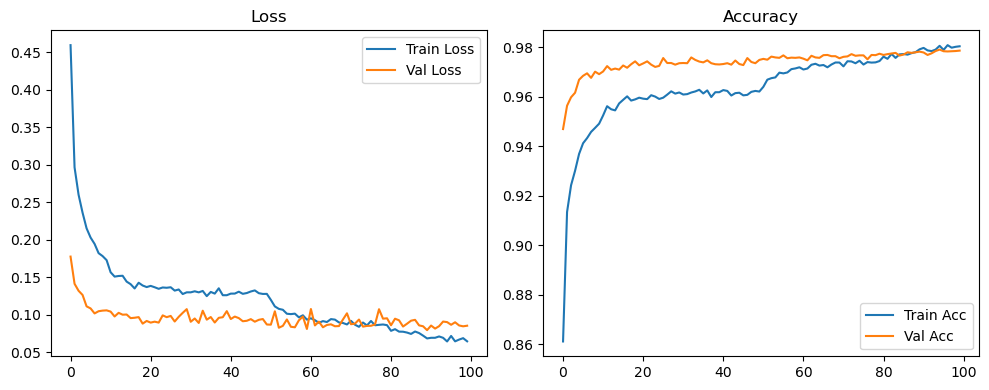

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2516, Acc: 0.9227 | Val Loss: 0.1305, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9615 | Val Loss: 0.1181, Acc: 0.9648


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9707 | Val Loss: 0.1132, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9746 | Val Loss: 0.0974, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9796 | Val Loss: 0.1013, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1133, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 0.1046, Acc: 0.9715


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1052, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.1028, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0985, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0995, Acc: 0.9740


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.1080, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.1045, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1119, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.1007, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.1028, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1058, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1181, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1096, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1057, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0995, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1075, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1107, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1290, Acc: 0.9739


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9930 | Val Loss: 0.1177, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1147, Acc: 0.9735


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1025, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1011, Acc: 0.9727


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1049, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1307, Acc: 0.9727


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1174, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1112, Acc: 0.9754


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1185, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1204, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0918, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1124, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1178, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1275, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1022, Acc: 0.9757


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1111, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0987, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1347, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1196, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1248, Acc: 0.9744


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1175, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1342, Acc: 0.9732


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1529, Acc: 0.9754


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1476, Acc: 0.9742


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0969, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1142, Acc: 0.9777


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1128, Acc: 0.9766


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1205, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1456, Acc: 0.9773


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1214, Acc: 0.9776


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1403, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1037, Acc: 0.9774


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1551, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1369, Acc: 0.9763


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1403, Acc: 0.9766


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1558, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1393, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1298, Acc: 0.9783


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1253, Acc: 0.9784


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1351, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1452, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1148, Acc: 0.9787


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1473, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0998, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1571, Acc: 0.9780


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1439, Acc: 0.9779


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1409, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1305, Acc: 0.9775


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1617, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1337, Acc: 0.9766


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1414, Acc: 0.9785


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1098, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1313, Acc: 0.9779


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1282, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1322, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1710, Acc: 0.9762


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1387, Acc: 0.9770


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1422, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1542, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1381, Acc: 0.9794


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1463, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1275, Acc: 0.9801


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1348, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1497, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1481, Acc: 0.9797


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1555, Acc: 0.9804


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1666, Acc: 0.9803


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1749, Acc: 0.9807


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1618, Acc: 0.9803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1646, Acc: 0.9793


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1699, Acc: 0.9793


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1658, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1771, Acc: 0.9795


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1849, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1659, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1780, Acc: 0.9800


Final Test Loss: 0.1703 Accuracy: 0.9815


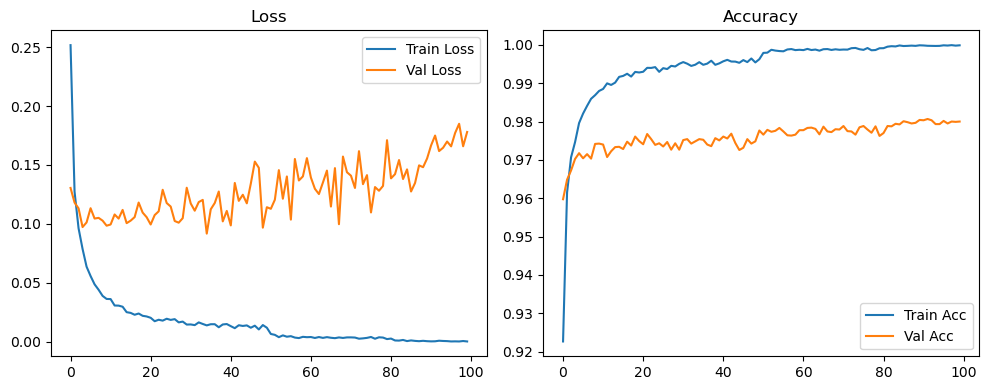

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3036, Acc: 0.9090 | Val Loss: 0.1510, Acc: 0.9553


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9477 | Val Loss: 0.1271, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9567 | Val Loss: 0.1110, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1221, Acc: 0.9621 | Val Loss: 0.1008, Acc: 0.9706


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9667 | Val Loss: 0.0999, Acc: 0.9715


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9688 | Val Loss: 0.1007, Acc: 0.9712


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9717 | Val Loss: 0.0932, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9758 | Val Loss: 0.0947, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9757 | Val Loss: 0.0899, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9788 | Val Loss: 0.0891, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.0853, Acc: 0.9746


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9807 | Val Loss: 0.0883, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9812 | Val Loss: 0.0970, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9825 | Val Loss: 0.0845, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9837 | Val Loss: 0.0964, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.0838, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9838 | Val Loss: 0.0914, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9840 | Val Loss: 0.0944, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.0816, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0864, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1040, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.0828, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0966, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0885, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9862 | Val Loss: 0.1012, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0994, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0907, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.0890, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0872, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0907, Acc: 0.9755


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1031, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1038, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.0921, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0831, Acc: 0.9758


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0992, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0836, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.1010, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.1025, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1018, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0804, Acc: 0.9759


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.1024, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9878 | Val Loss: 0.1055, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0935, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0930, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1005, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0926, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.1168, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.1184, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1183, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9903 | Val Loss: 0.0824, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0929, Acc: 0.9787


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0959, Acc: 0.9786


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9922 | Val Loss: 0.0933, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1078, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0930, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.0841, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.1110, Acc: 0.9793


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0807, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0995, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0837, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1016, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0819, Acc: 0.9784


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1033, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1151, Acc: 0.9793


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.0892, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1082, Acc: 0.9783


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0894, Acc: 0.9790


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0932, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0944, Acc: 0.9778


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0979, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9949 | Val Loss: 0.1033, Acc: 0.9791


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1092, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0886, Acc: 0.9782


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0939, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0820, Acc: 0.9780


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0969, Acc: 0.9775


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0967, Acc: 0.9782


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1111, Acc: 0.9774


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1118, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0973, Acc: 0.9776


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1029, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0973, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1004, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0983, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1039, Acc: 0.9799


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0970, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1067, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1030, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1020, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1039, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1006, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1023, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0963, Acc: 0.9795


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1060, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0903, Acc: 0.9800


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1110, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0956, Acc: 0.9793


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1013, Acc: 0.9800


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0998, Acc: 0.9802


Final Test Loss: 0.0921 Accuracy: 0.9821


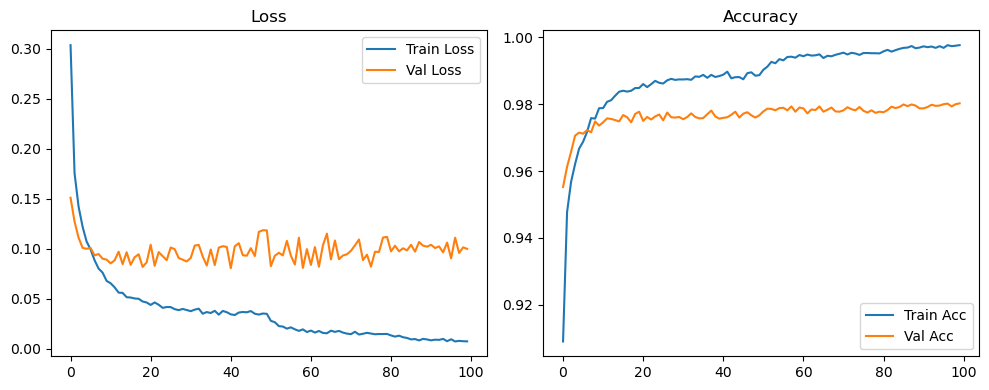

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4594, Acc: 0.8612 | Val Loss: 0.1777, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2966, Acc: 0.9134 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9242 | Val Loss: 0.1322, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2362, Acc: 0.9301 | Val Loss: 0.1266, Acc: 0.9616


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2154, Acc: 0.9369 | Val Loss: 0.1115, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2031, Acc: 0.9412 | Val Loss: 0.1087, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9433 | Val Loss: 0.1020, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1823, Acc: 0.9458 | Val Loss: 0.1050, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9474 | Val Loss: 0.1058, Acc: 0.9701


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1730, Acc: 0.9491 | Val Loss: 0.1061, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1569, Acc: 0.9524 | Val Loss: 0.1045, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1511, Acc: 0.9561 | Val Loss: 0.0980, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1519, Acc: 0.9549 | Val Loss: 0.1028, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1522, Acc: 0.9545 | Val Loss: 0.1003, Acc: 0.9713


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9573 | Val Loss: 0.1006, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9587 | Val Loss: 0.0958, Acc: 0.9726


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9601 | Val Loss: 0.0963, Acc: 0.9717


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9584 | Val Loss: 0.0971, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1392, Acc: 0.9589 | Val Loss: 0.0884, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1371, Acc: 0.9596 | Val Loss: 0.0920, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9592 | Val Loss: 0.0898, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9590 | Val Loss: 0.0911, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0898, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9600 | Val Loss: 0.0994, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1362, Acc: 0.9591 | Val Loss: 0.0971, Acc: 0.9724


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9596 | Val Loss: 0.0987, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1324, Acc: 0.9608 | Val Loss: 0.0912, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9621 | Val Loss: 0.0975, Acc: 0.9736


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9612 | Val Loss: 0.1028, Acc: 0.9729


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9735


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9609 | Val Loss: 0.0909, Acc: 0.9736


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9610 | Val Loss: 0.0953, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.0893, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1320, Acc: 0.9621 | Val Loss: 0.1056, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9628 | Val Loss: 0.0937, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9613 | Val Loss: 0.0972, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9625 | Val Loss: 0.0899, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1355, Acc: 0.9599 | Val Loss: 0.0962, Acc: 0.9735


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.0970, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.1051, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0946, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1285, Acc: 0.9623 | Val Loss: 0.0979, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1310, Acc: 0.9605 | Val Loss: 0.0958, Acc: 0.9729


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9614 | Val Loss: 0.0916, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9616 | Val Loss: 0.0922, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9605 | Val Loss: 0.0944, Acc: 0.9728


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9607 | Val Loss: 0.0910, Acc: 0.9756


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9619 | Val Loss: 0.0935, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9623 | Val Loss: 0.0946, Acc: 0.9735


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9621 | Val Loss: 0.0873, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.1201, Acc: 0.9640 | Val Loss: 0.0871, Acc: 0.9752


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.1114, Acc: 0.9669 | Val Loss: 0.1049, Acc: 0.9749


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.1081, Acc: 0.9675 | Val Loss: 0.0830, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.1069, Acc: 0.9678 | Val Loss: 0.0855, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.1016, Acc: 0.9697 | Val Loss: 0.0940, Acc: 0.9757


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.1011, Acc: 0.9694 | Val Loss: 0.0843, Acc: 0.9767


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.1018, Acc: 0.9698 | Val Loss: 0.0836, Acc: 0.9755


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0968, Acc: 0.9711 | Val Loss: 0.0928, Acc: 0.9758


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9714 | Val Loss: 0.0979, Acc: 0.9757


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9719 | Val Loss: 0.0813, Acc: 0.9758


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9710 | Val Loss: 0.1079, Acc: 0.9753


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0930, Acc: 0.9714 | Val Loss: 0.0860, Acc: 0.9747


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9729 | Val Loss: 0.0911, Acc: 0.9765


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9733 | Val Loss: 0.0836, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0906, Acc: 0.9725 | Val Loss: 0.0867, Acc: 0.9757


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9728 | Val Loss: 0.0875, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9719 | Val Loss: 0.0850, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0901, Acc: 0.9730 | Val Loss: 0.0852, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9738 | Val Loss: 0.0939, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9738 | Val Loss: 0.1022, Acc: 0.9755


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9722 | Val Loss: 0.0877, Acc: 0.9761


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0870, Acc: 0.9743 | Val Loss: 0.0884, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9742 | Val Loss: 0.0939, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9735 | Val Loss: 0.0845, Acc: 0.9765


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9745 | Val Loss: 0.0854, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0920, Acc: 0.9730 | Val Loss: 0.0856, Acc: 0.9767


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9740 | Val Loss: 0.0873, Acc: 0.9751


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9738 | Val Loss: 0.1076, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0873, Acc: 0.9738 | Val Loss: 0.0950, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9744 | Val Loss: 0.0956, Acc: 0.9773


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9758 | Val Loss: 0.0881, Acc: 0.9772


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0809, Acc: 0.9756 | Val Loss: 0.0952, Acc: 0.9778


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0780, Acc: 0.9774 | Val Loss: 0.0937, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9769 | Val Loss: 0.0856, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9765 | Val Loss: 0.0876, Acc: 0.9763


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0748, Acc: 0.9765 | Val Loss: 0.0878, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0789, Acc: 0.9763 | Val Loss: 0.0882, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0754, Acc: 0.9778 | Val Loss: 0.0836, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9782 | Val Loss: 0.0868, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0697, Acc: 0.9792 | Val Loss: 0.0814, Acc: 0.9784


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0697, Acc: 0.9798 | Val Loss: 0.0854, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0704, Acc: 0.9786 | Val Loss: 0.0822, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0711, Acc: 0.9788 | Val Loss: 0.0853, Acc: 0.9781


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9785 | Val Loss: 0.0893, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9803 | Val Loss: 0.0884, Acc: 0.9786


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0738, Acc: 0.9786 | Val Loss: 0.0872, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9800 | Val Loss: 0.0866, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0658, Acc: 0.9799 | Val Loss: 0.0850, Acc: 0.9790


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9800 | Val Loss: 0.0873, Acc: 0.9791


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9803 | Val Loss: 0.0830, Acc: 0.9789


Final Test Loss: 0.0729 Accuracy: 0.9816


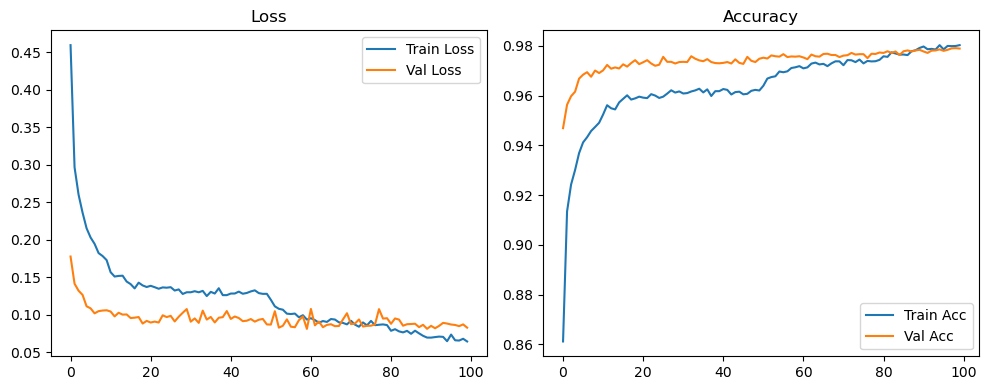

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2516, Acc: 0.9227 | Val Loss: 0.1305, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9615 | Val Loss: 0.1181, Acc: 0.9648


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9707 | Val Loss: 0.1132, Acc: 0.9673


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9746 | Val Loss: 0.0974, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9796 | Val Loss: 0.1013, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1133, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 0.1046, Acc: 0.9715


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1052, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.1028, Acc: 0.9742


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.0985, Acc: 0.9742


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0995, Acc: 0.9740


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.1080, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.1045, Acc: 0.9722


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1119, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.1007, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.1028, Acc: 0.9728


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1058, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1181, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.1096, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1057, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0995, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1075, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1107, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1290, Acc: 0.9739


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9930 | Val Loss: 0.1177, Acc: 0.9743


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1147, Acc: 0.9735


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1025, Acc: 0.9747


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1011, Acc: 0.9727


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1049, Acc: 0.9743


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1307, Acc: 0.9727


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1174, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1112, Acc: 0.9754


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1185, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1204, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0918, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1124, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1178, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1275, Acc: 0.9736


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1022, Acc: 0.9757


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.1111, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0987, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1347, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1196, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1248, Acc: 0.9744


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1175, Acc: 0.9726


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1342, Acc: 0.9732


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1529, Acc: 0.9754


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1476, Acc: 0.9742


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0969, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1142, Acc: 0.9777


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1132, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1213, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1335, Acc: 0.9789


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1372, Acc: 0.9793


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1316, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1245, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1517, Acc: 0.9803


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1564, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1331, Acc: 0.9796


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1306, Acc: 0.9800


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1301, Acc: 0.9801


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1439, Acc: 0.9803


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1294, Acc: 0.9797


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1351, Acc: 0.9801


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1523, Acc: 0.9800


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1435, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1359, Acc: 0.9797


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1332, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1342, Acc: 0.9799


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1205, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1306, Acc: 0.9784


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1546, Acc: 0.9793


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1351, Acc: 0.9796


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1683, Acc: 0.9801


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1373, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1346, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1431, Acc: 0.9793


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1688, Acc: 0.9801


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1288, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1401, Acc: 0.9803


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1356, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1390, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1433, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1557, Acc: 0.9806


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1580, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1479, Acc: 0.9806


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1507, Acc: 0.9806


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1557, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1608, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1490, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1675, Acc: 0.9791


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1726, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1620, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1677, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1644, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1400, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1478, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1541, Acc: 0.9790


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1556, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1624, Acc: 0.9800


Final Test Loss: 0.1579 Accuracy: 0.9824


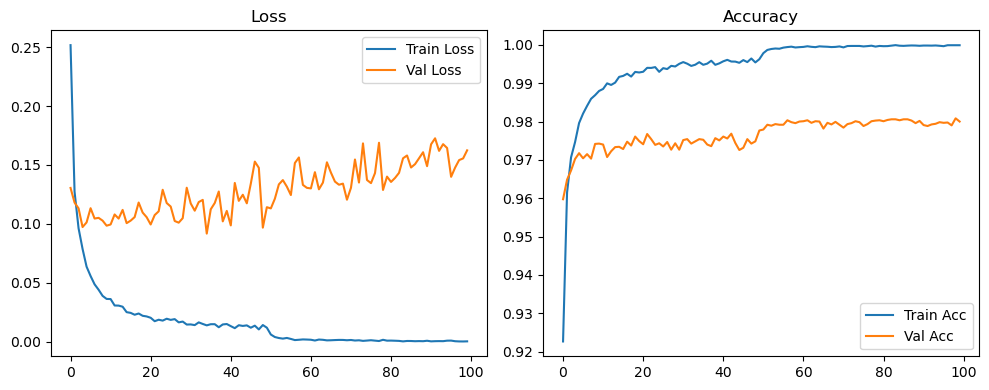

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3036, Acc: 0.9090 | Val Loss: 0.1510, Acc: 0.9553


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9477 | Val Loss: 0.1271, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1422, Acc: 0.9567 | Val Loss: 0.1110, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1221, Acc: 0.9621 | Val Loss: 0.1008, Acc: 0.9706


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9667 | Val Loss: 0.0999, Acc: 0.9715


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9688 | Val Loss: 0.1007, Acc: 0.9712


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9717 | Val Loss: 0.0932, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9758 | Val Loss: 0.0947, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9757 | Val Loss: 0.0899, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9788 | Val Loss: 0.0891, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9788 | Val Loss: 0.0853, Acc: 0.9746


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9807 | Val Loss: 0.0883, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9812 | Val Loss: 0.0970, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9825 | Val Loss: 0.0845, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9837 | Val Loss: 0.0964, Acc: 0.9748


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.0838, Acc: 0.9768


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9838 | Val Loss: 0.0914, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9840 | Val Loss: 0.0944, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9848 | Val Loss: 0.0816, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.0864, Acc: 0.9778


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1040, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9851 | Val Loss: 0.0828, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0966, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9763


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0885, Acc: 0.9769


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9862 | Val Loss: 0.1012, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0994, Acc: 0.9775


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0907, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.0890, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9874 | Val Loss: 0.0872, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0907, Acc: 0.9755


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.1031, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.1038, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9883 | Val Loss: 0.0921, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.0831, Acc: 0.9758


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9888 | Val Loss: 0.0992, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0836, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.1010, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.1025, Acc: 0.9763


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1018, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0804, Acc: 0.9759


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.1024, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9878 | Val Loss: 0.1055, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0935, Acc: 0.9778


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0930, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.1005, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0926, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.1168, Acc: 0.9767


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.1184, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.1183, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0894, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0989, Acc: 0.9783


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0965, Acc: 0.9795


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0963, Acc: 0.9779


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.1023, Acc: 0.9793


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0856, Acc: 0.9797


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0935, Acc: 0.9788


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1046, Acc: 0.9791


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0884, Acc: 0.9789


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0956, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0848, Acc: 0.9797


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0959, Acc: 0.9794


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1007, Acc: 0.9795


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0978, Acc: 0.9791


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1033, Acc: 0.9793


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0999, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0969, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0827, Acc: 0.9797


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0952, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.0950, Acc: 0.9801


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1090, Acc: 0.9805


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1003, Acc: 0.9803


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1005, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0947, Acc: 0.9803


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1136, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0943, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0885, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0966, Acc: 0.9795


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1080, Acc: 0.9804


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0974, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0932, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0950, Acc: 0.9804


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0998, Acc: 0.9807


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1047, Acc: 0.9805


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1008, Acc: 0.9807


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0928, Acc: 0.9806


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1053, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0984, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0992, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0932, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0959, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1029, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0950, Acc: 0.9799


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0964, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0944, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1084, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0985, Acc: 0.9803


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1065, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0967, Acc: 0.9811


Final Test Loss: 0.0911 Accuracy: 0.9828


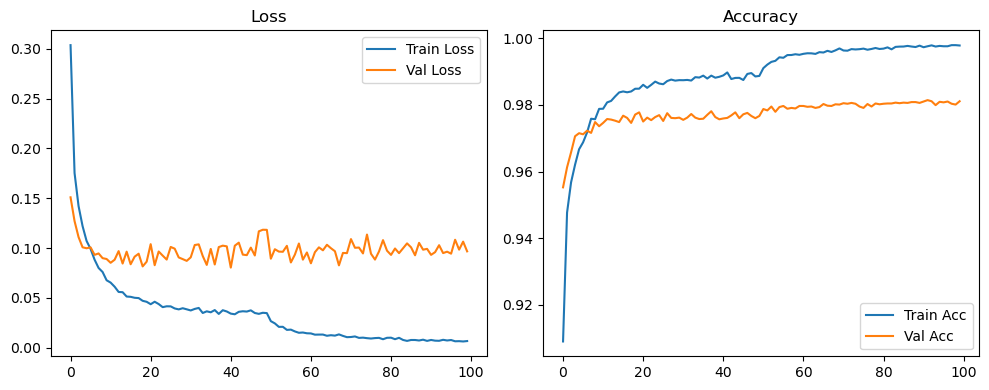

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4594, Acc: 0.8612 | Val Loss: 0.1777, Acc: 0.9469


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2966, Acc: 0.9134 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2602, Acc: 0.9242 | Val Loss: 0.1322, Acc: 0.9597


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2362, Acc: 0.9301 | Val Loss: 0.1266, Acc: 0.9616


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2154, Acc: 0.9369 | Val Loss: 0.1115, Acc: 0.9668


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2031, Acc: 0.9412 | Val Loss: 0.1087, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1946, Acc: 0.9433 | Val Loss: 0.1020, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1823, Acc: 0.9458 | Val Loss: 0.1050, Acc: 0.9676


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1784, Acc: 0.9474 | Val Loss: 0.1058, Acc: 0.9701


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1730, Acc: 0.9491 | Val Loss: 0.1061, Acc: 0.9691


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1569, Acc: 0.9524 | Val Loss: 0.1045, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1511, Acc: 0.9561 | Val Loss: 0.0980, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1519, Acc: 0.9549 | Val Loss: 0.1028, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1522, Acc: 0.9545 | Val Loss: 0.1003, Acc: 0.9713


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1444, Acc: 0.9573 | Val Loss: 0.1006, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9587 | Val Loss: 0.0958, Acc: 0.9726


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9601 | Val Loss: 0.0963, Acc: 0.9717


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9584 | Val Loss: 0.0971, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1392, Acc: 0.9589 | Val Loss: 0.0884, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1371, Acc: 0.9596 | Val Loss: 0.0920, Acc: 0.9727


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1387, Acc: 0.9592 | Val Loss: 0.0898, Acc: 0.9734


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9590 | Val Loss: 0.0911, Acc: 0.9742


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9606 | Val Loss: 0.0898, Acc: 0.9729


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9600 | Val Loss: 0.0994, Acc: 0.9720


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1362, Acc: 0.9591 | Val Loss: 0.0971, Acc: 0.9724


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1369, Acc: 0.9596 | Val Loss: 0.0987, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1324, Acc: 0.9608 | Val Loss: 0.0912, Acc: 0.9736


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9621 | Val Loss: 0.0975, Acc: 0.9736


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1279, Acc: 0.9612 | Val Loss: 0.1028, Acc: 0.9729


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.1077, Acc: 0.9735


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9609 | Val Loss: 0.0909, Acc: 0.9736


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1315, Acc: 0.9610 | Val Loss: 0.0953, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1301, Acc: 0.9617 | Val Loss: 0.0893, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1320, Acc: 0.9621 | Val Loss: 0.1056, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1251, Acc: 0.9628 | Val Loss: 0.0937, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9613 | Val Loss: 0.0972, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9625 | Val Loss: 0.0899, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1355, Acc: 0.9599 | Val Loss: 0.0962, Acc: 0.9735


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.0970, Acc: 0.9731


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1263, Acc: 0.9618 | Val Loss: 0.1051, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9626 | Val Loss: 0.0946, Acc: 0.9732


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1285, Acc: 0.9623 | Val Loss: 0.0979, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1310, Acc: 0.9605 | Val Loss: 0.0958, Acc: 0.9729


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9614 | Val Loss: 0.0916, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9616 | Val Loss: 0.0922, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9605 | Val Loss: 0.0944, Acc: 0.9728


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9607 | Val Loss: 0.0910, Acc: 0.9756


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1290, Acc: 0.9619 | Val Loss: 0.0935, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9623 | Val Loss: 0.0946, Acc: 0.9735


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9621 | Val Loss: 0.0873, Acc: 0.9748


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.1172, Acc: 0.9649 | Val Loss: 0.0862, Acc: 0.9753


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.1106, Acc: 0.9658 | Val Loss: 0.0920, Acc: 0.9760


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.1059, Acc: 0.9681 | Val Loss: 0.0842, Acc: 0.9758


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.1036, Acc: 0.9687 | Val Loss: 0.0855, Acc: 0.9748


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0990, Acc: 0.9705 | Val Loss: 0.0893, Acc: 0.9767


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0976, Acc: 0.9702 | Val Loss: 0.0832, Acc: 0.9769


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9707 | Val Loss: 0.0829, Acc: 0.9766


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0923, Acc: 0.9722 | Val Loss: 0.0867, Acc: 0.9760


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0935, Acc: 0.9718 | Val Loss: 0.0897, Acc: 0.9763


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0893, Acc: 0.9732 | Val Loss: 0.0834, Acc: 0.9768


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0877, Acc: 0.9728 | Val Loss: 0.0936, Acc: 0.9775


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0880, Acc: 0.9730 | Val Loss: 0.0866, Acc: 0.9773


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0835, Acc: 0.9745 | Val Loss: 0.0867, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9746 | Val Loss: 0.0855, Acc: 0.9769


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0841, Acc: 0.9748 | Val Loss: 0.0858, Acc: 0.9774


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0839, Acc: 0.9751 | Val Loss: 0.0843, Acc: 0.9773


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0832, Acc: 0.9756 | Val Loss: 0.0854, Acc: 0.9776


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 0.0803, Acc: 0.9780


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0806, Acc: 0.9760 | Val Loss: 0.0856, Acc: 0.9791


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0804, Acc: 0.9762 | Val Loss: 0.0931, Acc: 0.9780


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0823, Acc: 0.9760 | Val Loss: 0.0866, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9769 | Val Loss: 0.0888, Acc: 0.9773


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9766 | Val Loss: 0.0917, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0775, Acc: 0.9763 | Val Loss: 0.0857, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0777, Acc: 0.9771 | Val Loss: 0.0849, Acc: 0.9780


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0803, Acc: 0.9765 | Val Loss: 0.0826, Acc: 0.9777


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0757, Acc: 0.9773 | Val Loss: 0.0876, Acc: 0.9770


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0759, Acc: 0.9768 | Val Loss: 0.0878, Acc: 0.9771


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0773, Acc: 0.9770 | Val Loss: 0.0859, Acc: 0.9776


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0725, Acc: 0.9786 | Val Loss: 0.0857, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9793 | Val Loss: 0.0874, Acc: 0.9776


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0740, Acc: 0.9779 | Val Loss: 0.0914, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9784 | Val Loss: 0.0882, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0696, Acc: 0.9790 | Val Loss: 0.0862, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0712, Acc: 0.9785 | Val Loss: 0.0858, Acc: 0.9775


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9799 | Val Loss: 0.0896, Acc: 0.9780


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0732, Acc: 0.9786 | Val Loss: 0.0845, Acc: 0.9784


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9789 | Val Loss: 0.0833, Acc: 0.9785


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9790 | Val Loss: 0.0881, Acc: 0.9785


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0665, Acc: 0.9802 | Val Loss: 0.0814, Acc: 0.9786


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0673, Acc: 0.9803 | Val Loss: 0.0848, Acc: 0.9775


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9793 | Val Loss: 0.0848, Acc: 0.9775


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9783 | Val Loss: 0.0833, Acc: 0.9780


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.0868, Acc: 0.9784


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0621, Acc: 0.9807 | Val Loss: 0.0850, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9791 | Val Loss: 0.0843, Acc: 0.9790


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0630, Acc: 0.9812 | Val Loss: 0.0861, Acc: 0.9787


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9808 | Val Loss: 0.0844, Acc: 0.9783


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9793 | Val Loss: 0.0855, Acc: 0.9783


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0640, Acc: 0.9813 | Val Loss: 0.0845, Acc: 0.9791


Final Test Loss: 0.0782 Accuracy: 0.9805


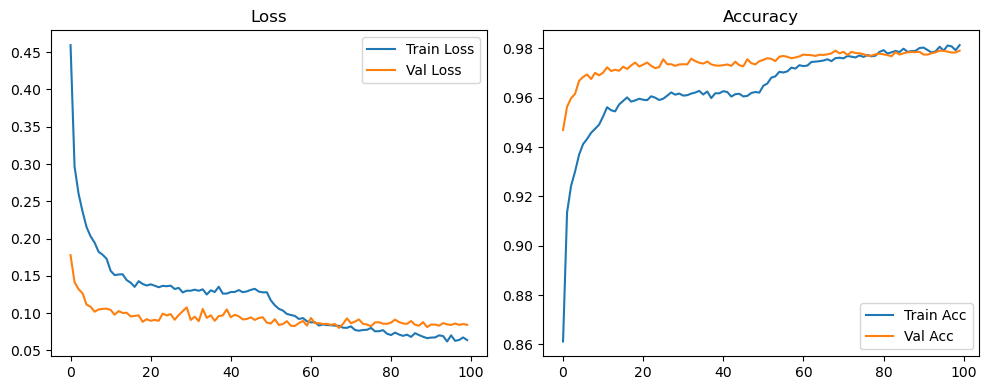

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2379, Acc: 0.9260 | Val Loss: 0.1347, Acc: 0.9604


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1212, Acc: 0.9623 | Val Loss: 0.1099, Acc: 0.9672


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0926, Acc: 0.9715 | Val Loss: 0.1173, Acc: 0.9654


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9761 | Val Loss: 0.0938, Acc: 0.9728


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9809 | Val Loss: 0.0954, Acc: 0.9738


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9832 | Val Loss: 0.1116, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9853 | Val Loss: 0.0964, Acc: 0.9735


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1167, Acc: 0.9690


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9876 | Val Loss: 0.1091, Acc: 0.9722


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.0943, Acc: 0.9758


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0997, Acc: 0.9735


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.0962, Acc: 0.9743


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1081, Acc: 0.9759


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1031, Acc: 0.9766


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.1035, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1017, Acc: 0.9770


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1087, Acc: 0.9765


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1047, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1220, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.1172, Acc: 0.9755


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.1102, Acc: 0.9754


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1114, Acc: 0.9770


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1119, Acc: 0.9769


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1124, Acc: 0.9753


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1158, Acc: 0.9778


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1146, Acc: 0.9768


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9960 | Val Loss: 0.1140, Acc: 0.9764


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9780


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1069, Acc: 0.9772


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1038, Acc: 0.9785


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0934, Acc: 0.9805


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1046, Acc: 0.9774


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1074, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1210, Acc: 0.9757


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1018, Acc: 0.9787


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1130, Acc: 0.9782


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1099, Acc: 0.9780


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1108, Acc: 0.9795


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1125, Acc: 0.9765


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1171, Acc: 0.9781


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1130, Acc: 0.9774


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1241, Acc: 0.9757


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1244, Acc: 0.9786


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1136, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1133, Acc: 0.9792


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1132, Acc: 0.9791


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1453, Acc: 0.9742


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1137, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1203, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1147, Acc: 0.9772


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1287, Acc: 0.9759


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1143, Acc: 0.9777


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1282, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1150, Acc: 0.9787


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1251, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1338, Acc: 0.9778


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1245, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1218, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1101, Acc: 0.9786


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1425, Acc: 0.9750


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1250, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1281, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1247, Acc: 0.9784


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1383, Acc: 0.9770


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1233, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1219, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1095, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1269, Acc: 0.9781


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1277, Acc: 0.9787


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1275, Acc: 0.9779


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1300, Acc: 0.9772


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1236, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1410, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1400, Acc: 0.9766


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1236, Acc: 0.9792


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1054, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1224, Acc: 0.9773


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1293, Acc: 0.9790


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1403, Acc: 0.9770


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1430, Acc: 0.9766


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1183, Acc: 0.9781


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1378, Acc: 0.9792


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1489, Acc: 0.9784


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1335, Acc: 0.9786


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1186, Acc: 0.9791


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1253, Acc: 0.9779


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1253, Acc: 0.9800


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1369, Acc: 0.9772


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1192, Acc: 0.9792


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1216, Acc: 0.9780


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1327, Acc: 0.9782


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1200, Acc: 0.9782


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1466, Acc: 0.9789


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1487, Acc: 0.9785


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1177, Acc: 0.9782


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1317, Acc: 0.9796


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1123, Acc: 0.9804


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1268, Acc: 0.9801


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1180, Acc: 0.9794


Final Test Loss: 0.1152 Accuracy: 0.9812


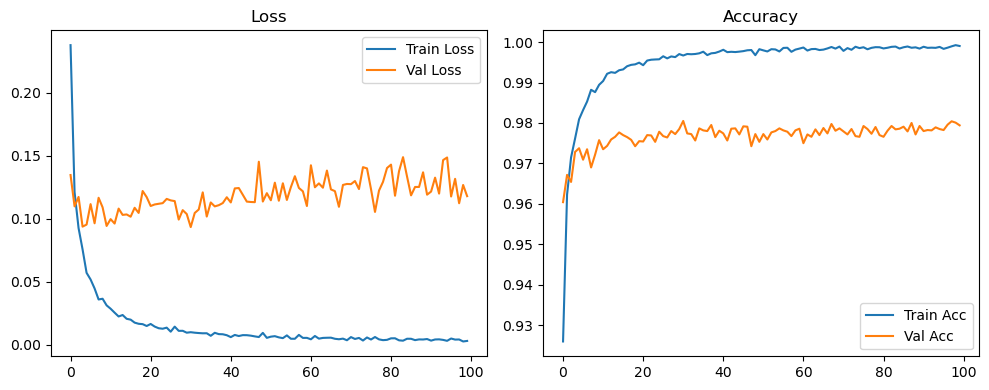

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2850, Acc: 0.9130 | Val Loss: 0.1298, Acc: 0.9597


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1625, Acc: 0.9503 | Val Loss: 0.1161, Acc: 0.9643


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9596 | Val Loss: 0.1112, Acc: 0.9667


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1113, Acc: 0.9649 | Val Loss: 0.1003, Acc: 0.9698


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0962, Acc: 0.9692 | Val Loss: 0.0914, Acc: 0.9734


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9737 | Val Loss: 0.0971, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9751 | Val Loss: 0.0905, Acc: 0.9731


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9790 | Val Loss: 0.0927, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9786 | Val Loss: 0.0934, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9809 | Val Loss: 0.0887, Acc: 0.9755


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.0947, Acc: 0.9719


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9831 | Val Loss: 0.0911, Acc: 0.9744


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 0.0852, Acc: 0.9765


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 0.0888, Acc: 0.9746


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 0.0928, Acc: 0.9752


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9864 | Val Loss: 0.0870, Acc: 0.9767


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0901, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.0978, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.0897, Acc: 0.9770


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9880 | Val Loss: 0.0913, Acc: 0.9779


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0880, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0916, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0908, Acc: 0.9783


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0916, Acc: 0.9770


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0915, Acc: 0.9779


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0962, Acc: 0.9766


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.0979, Acc: 0.9766


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.0856, Acc: 0.9789


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0879, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0902, Acc: 0.9796


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.0981, Acc: 0.9777


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0946, Acc: 0.9788


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0901, Acc: 0.9767


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.1016, Acc: 0.9775


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.0962, Acc: 0.9776


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0914, Acc: 0.9786


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1036, Acc: 0.9779


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0978, Acc: 0.9784


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1047, Acc: 0.9767


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1032, Acc: 0.9783


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0911, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.1011, Acc: 0.9790


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1010, Acc: 0.9792


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1043, Acc: 0.9778


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.1040, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0992, Acc: 0.9785


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1082, Acc: 0.9779


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9766


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0967, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0958, Acc: 0.9793


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0945, Acc: 0.9784


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.1066, Acc: 0.9784


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0903, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0935, Acc: 0.9788


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0983, Acc: 0.9799


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0862, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.0958, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1088, Acc: 0.9785


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0988, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0973, Acc: 0.9790


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0958, Acc: 0.9793


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0903, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1014, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1023, Acc: 0.9792


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1143, Acc: 0.9773


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1064, Acc: 0.9795


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1049, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1077, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0969, Acc: 0.9805


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0967, Acc: 0.9787


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1024, Acc: 0.9804


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0984, Acc: 0.9802


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1060, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.1125, Acc: 0.9793


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1048, Acc: 0.9796


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0924, Acc: 0.9781


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0909, Acc: 0.9797


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1094, Acc: 0.9785


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0961, Acc: 0.9790


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0968, Acc: 0.9807


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0951, Acc: 0.9781


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1019, Acc: 0.9796


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0969, Acc: 0.9798


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0893, Acc: 0.9795


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0801, Acc: 0.9803


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0920, Acc: 0.9799


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1031, Acc: 0.9788


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1041, Acc: 0.9782


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0952, Acc: 0.9794


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1116, Acc: 0.9796


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1015, Acc: 0.9789


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.1214, Acc: 0.9794


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1024, Acc: 0.9781


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0999, Acc: 0.9801


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1017, Acc: 0.9793


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1047, Acc: 0.9785


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1090, Acc: 0.9794


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0992, Acc: 0.9795


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1004, Acc: 0.9792


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0917, Acc: 0.9799


Final Test Loss: 0.0847 Accuracy: 0.9814


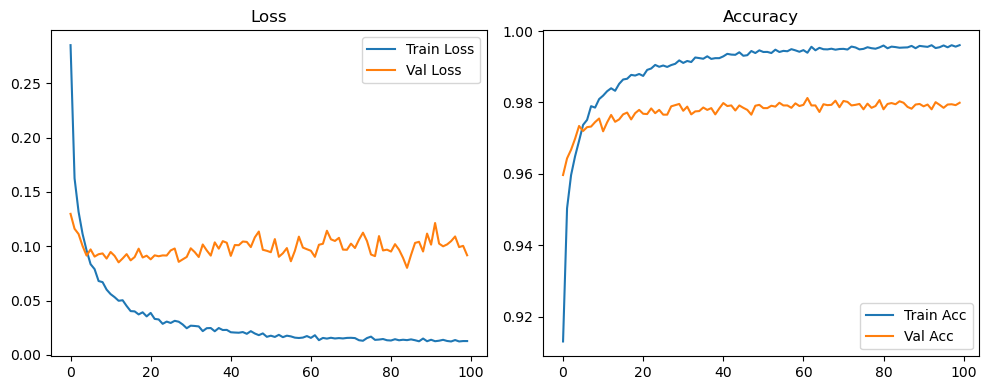

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4462, Acc: 0.8628 | Val Loss: 0.1764, Acc: 0.9443


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2785, Acc: 0.9161 | Val Loss: 0.1427, Acc: 0.9549


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2372, Acc: 0.9306 | Val Loss: 0.1280, Acc: 0.9607


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2179, Acc: 0.9355 | Val Loss: 0.1107, Acc: 0.9664


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1982, Acc: 0.9403 | Val Loss: 0.1061, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1848, Acc: 0.9444 | Val Loss: 0.1064, Acc: 0.9675


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1712, Acc: 0.9478 | Val Loss: 0.0983, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1625, Acc: 0.9513 | Val Loss: 0.1001, Acc: 0.9695


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1561, Acc: 0.9535 | Val Loss: 0.0972, Acc: 0.9711


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1503, Acc: 0.9548 | Val Loss: 0.0914, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9565 | Val Loss: 0.0923, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1392, Acc: 0.9579 | Val Loss: 0.0888, Acc: 0.9738


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1361, Acc: 0.9575 | Val Loss: 0.0875, Acc: 0.9748


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1340, Acc: 0.9591 | Val Loss: 0.0907, Acc: 0.9729


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1285, Acc: 0.9606 | Val Loss: 0.0883, Acc: 0.9749


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1202, Acc: 0.9632 | Val Loss: 0.0881, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9636 | Val Loss: 0.0884, Acc: 0.9756


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1186, Acc: 0.9646 | Val Loss: 0.0869, Acc: 0.9748


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1134, Acc: 0.9654 | Val Loss: 0.0839, Acc: 0.9766


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9664 | Val Loss: 0.0865, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1156, Acc: 0.9651 | Val Loss: 0.0828, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1023, Acc: 0.9678 | Val Loss: 0.0826, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1054, Acc: 0.9680 | Val Loss: 0.0873, Acc: 0.9756


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1051, Acc: 0.9690 | Val Loss: 0.0886, Acc: 0.9756


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9687 | Val Loss: 0.0854, Acc: 0.9761


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1051, Acc: 0.9688 | Val Loss: 0.0830, Acc: 0.9764


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9710 | Val Loss: 0.0878, Acc: 0.9761


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0961, Acc: 0.9711 | Val Loss: 0.0866, Acc: 0.9764


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0931, Acc: 0.9711 | Val Loss: 0.0907, Acc: 0.9753


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0876, Acc: 0.9727 | Val Loss: 0.0880, Acc: 0.9768


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0922, Acc: 0.9714 | Val Loss: 0.0856, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0873, Acc: 0.9729 | Val Loss: 0.0845, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0865, Acc: 0.9730 | Val Loss: 0.0851, Acc: 0.9774


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9734 | Val Loss: 0.0930, Acc: 0.9750


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9743 | Val Loss: 0.0882, Acc: 0.9764


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9737 | Val Loss: 0.0877, Acc: 0.9771


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9747 | Val Loss: 0.0882, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9743 | Val Loss: 0.0885, Acc: 0.9772


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9759 | Val Loss: 0.0878, Acc: 0.9743


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9751 | Val Loss: 0.0837, Acc: 0.9768


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9753 | Val Loss: 0.0866, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9766 | Val Loss: 0.0835, Acc: 0.9770


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9757 | Val Loss: 0.0866, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9750 | Val Loss: 0.0881, Acc: 0.9769


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9761 | Val Loss: 0.0895, Acc: 0.9767


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9759 | Val Loss: 0.0885, Acc: 0.9778


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9745 | Val Loss: 0.0831, Acc: 0.9779


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0883, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9765 | Val Loss: 0.0935, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9768 | Val Loss: 0.0939, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9764 | Val Loss: 0.0883, Acc: 0.9765


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9773 | Val Loss: 0.0870, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9771 | Val Loss: 0.0842, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0744, Acc: 0.9771 | Val Loss: 0.0914, Acc: 0.9765


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9767 | Val Loss: 0.0913, Acc: 0.9762


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9776 | Val Loss: 0.0830, Acc: 0.9780


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0752, Acc: 0.9771 | Val Loss: 0.0786, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9774 | Val Loss: 0.0857, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9774 | Val Loss: 0.0914, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0743, Acc: 0.9774 | Val Loss: 0.0861, Acc: 0.9771


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0727, Acc: 0.9779 | Val Loss: 0.0991, Acc: 0.9766


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9775 | Val Loss: 0.0882, Acc: 0.9755


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9775 | Val Loss: 0.0898, Acc: 0.9777


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9783 | Val Loss: 0.0823, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0744, Acc: 0.9773 | Val Loss: 0.0846, Acc: 0.9772


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9764 | Val Loss: 0.0853, Acc: 0.9774


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9769 | Val Loss: 0.0906, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9771 | Val Loss: 0.0890, Acc: 0.9775


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.0903, Acc: 0.9769


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9791 | Val Loss: 0.0866, Acc: 0.9770


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9789 | Val Loss: 0.0929, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9765 | Val Loss: 0.0925, Acc: 0.9766


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9772 | Val Loss: 0.0882, Acc: 0.9767


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9780 | Val Loss: 0.0924, Acc: 0.9758


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9795 | Val Loss: 0.0960, Acc: 0.9750


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9786 | Val Loss: 0.0837, Acc: 0.9763


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9783 | Val Loss: 0.0832, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9785 | Val Loss: 0.0893, Acc: 0.9752


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9775 | Val Loss: 0.0893, Acc: 0.9766


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9784 | Val Loss: 0.0913, Acc: 0.9773


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9782 | Val Loss: 0.0988, Acc: 0.9761


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0720, Acc: 0.9781 | Val Loss: 0.0928, Acc: 0.9760


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9777 | Val Loss: 0.0865, Acc: 0.9766


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9781 | Val Loss: 0.0868, Acc: 0.9765


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9780 | Val Loss: 0.0907, Acc: 0.9762


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0705, Acc: 0.9778 | Val Loss: 0.0928, Acc: 0.9766


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9775 | Val Loss: 0.0896, Acc: 0.9765


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9774 | Val Loss: 0.0877, Acc: 0.9763


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9782 | Val Loss: 0.0867, Acc: 0.9768


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9786 | Val Loss: 0.0849, Acc: 0.9761


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9773 | Val Loss: 0.0834, Acc: 0.9762


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9783 | Val Loss: 0.0846, Acc: 0.9755


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9779 | Val Loss: 0.0939, Acc: 0.9760


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9782 | Val Loss: 0.0923, Acc: 0.9771


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9792 | Val Loss: 0.0851, Acc: 0.9780


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9770 | Val Loss: 0.0857, Acc: 0.9775


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0690, Acc: 0.9791 | Val Loss: 0.0866, Acc: 0.9764


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9781 | Val Loss: 0.0939, Acc: 0.9768


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9780 | Val Loss: 0.0914, Acc: 0.9764


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0712, Acc: 0.9777 | Val Loss: 0.0951, Acc: 0.9778


Final Test Loss: 0.0857 Accuracy: 0.9797


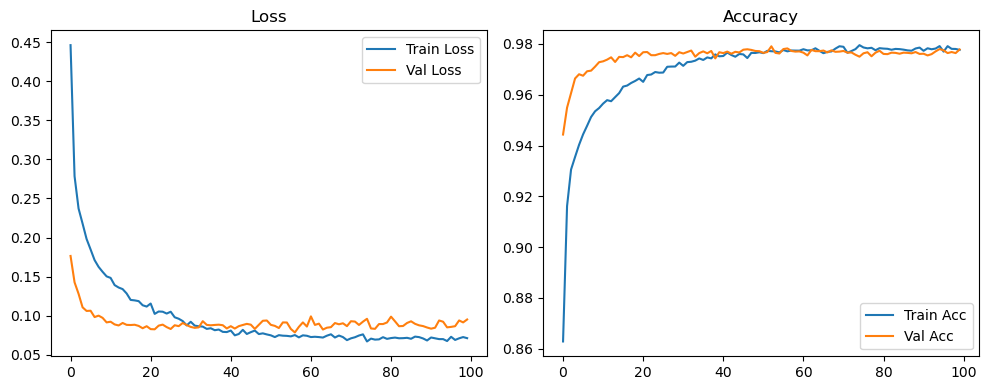

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2379, Acc: 0.9260 | Val Loss: 0.1347, Acc: 0.9604


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1212, Acc: 0.9623 | Val Loss: 0.1099, Acc: 0.9672


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0926, Acc: 0.9715 | Val Loss: 0.1173, Acc: 0.9654


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9761 | Val Loss: 0.0938, Acc: 0.9728


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9809 | Val Loss: 0.0954, Acc: 0.9738


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9832 | Val Loss: 0.1116, Acc: 0.9709


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9853 | Val Loss: 0.0964, Acc: 0.9735


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1167, Acc: 0.9690


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9876 | Val Loss: 0.1091, Acc: 0.9722


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.0943, Acc: 0.9758


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0997, Acc: 0.9735


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.0962, Acc: 0.9743


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1081, Acc: 0.9759


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1031, Acc: 0.9766


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.1035, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1017, Acc: 0.9770


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1087, Acc: 0.9765


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1047, Acc: 0.9758


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1220, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.1172, Acc: 0.9755


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.1102, Acc: 0.9754


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1114, Acc: 0.9770


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1119, Acc: 0.9769


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1124, Acc: 0.9753


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1158, Acc: 0.9778


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1146, Acc: 0.9768


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9960 | Val Loss: 0.1140, Acc: 0.9764


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0994, Acc: 0.9780


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1069, Acc: 0.9772


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1038, Acc: 0.9785


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0934, Acc: 0.9805


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1046, Acc: 0.9774


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1074, Acc: 0.9772


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1210, Acc: 0.9757


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.1018, Acc: 0.9787


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1130, Acc: 0.9782


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1099, Acc: 0.9780


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1108, Acc: 0.9795


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1125, Acc: 0.9765


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1171, Acc: 0.9781


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1130, Acc: 0.9774


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1241, Acc: 0.9757


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1244, Acc: 0.9786


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1191, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1136, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1133, Acc: 0.9792


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1132, Acc: 0.9791


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1453, Acc: 0.9742


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1137, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1203, Acc: 0.9753


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1084, Acc: 0.9795


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1052, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1063, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1151, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1095, Acc: 0.9811


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1156, Acc: 0.9797


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1231, Acc: 0.9799


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1251, Acc: 0.9800


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1293, Acc: 0.9797


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1312, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1311, Acc: 0.9794


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1237, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1212, Acc: 0.9809


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1221, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1314, Acc: 0.9807


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1360, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1412, Acc: 0.9776


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1308, Acc: 0.9797


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1355, Acc: 0.9793


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1491, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1334, Acc: 0.9794


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1423, Acc: 0.9783


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1301, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1342, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1475, Acc: 0.9786


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1435, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1464, Acc: 0.9797


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1494, Acc: 0.9794


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1545, Acc: 0.9786


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1467, Acc: 0.9805


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1489, Acc: 0.9807


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1518, Acc: 0.9809


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1511, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1540, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1517, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1501, Acc: 0.9806


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1505, Acc: 0.9808


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1460, Acc: 0.9816


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1540, Acc: 0.9807


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1438, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1457, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1476, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1448, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1451, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1497, Acc: 0.9807


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1427, Acc: 0.9815


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1522, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1453, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1552, Acc: 0.9814


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1493, Acc: 0.9817


Final Test Loss: 0.1369 Accuracy: 0.9822


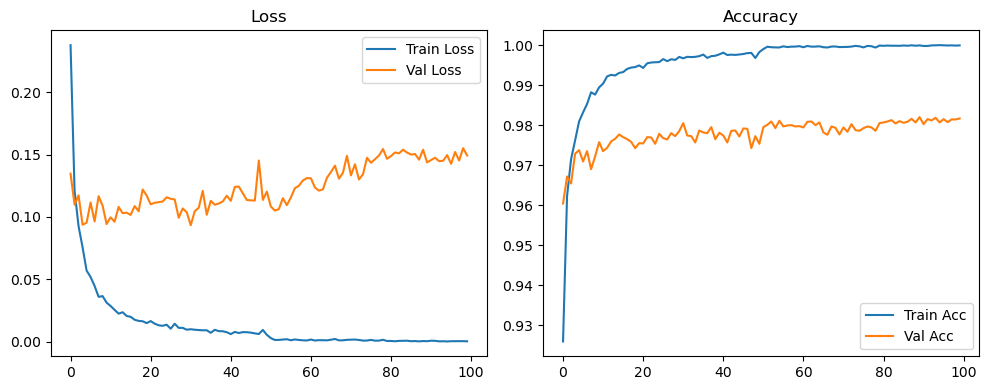

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2850, Acc: 0.9130 | Val Loss: 0.1298, Acc: 0.9597


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1625, Acc: 0.9503 | Val Loss: 0.1161, Acc: 0.9643


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9596 | Val Loss: 0.1112, Acc: 0.9667


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1113, Acc: 0.9649 | Val Loss: 0.1003, Acc: 0.9698


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0962, Acc: 0.9692 | Val Loss: 0.0914, Acc: 0.9734


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9737 | Val Loss: 0.0971, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9751 | Val Loss: 0.0905, Acc: 0.9731


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9790 | Val Loss: 0.0927, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9786 | Val Loss: 0.0934, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9809 | Val Loss: 0.0887, Acc: 0.9755


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.0947, Acc: 0.9719


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9831 | Val Loss: 0.0911, Acc: 0.9744


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9840 | Val Loss: 0.0852, Acc: 0.9765


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 0.0888, Acc: 0.9746


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 0.0928, Acc: 0.9752


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9864 | Val Loss: 0.0870, Acc: 0.9767


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0901, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.0978, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.0897, Acc: 0.9770


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9880 | Val Loss: 0.0913, Acc: 0.9779


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0880, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0916, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0908, Acc: 0.9783


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0916, Acc: 0.9770


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0915, Acc: 0.9779


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0962, Acc: 0.9766


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.0979, Acc: 0.9766


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.0856, Acc: 0.9789


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0879, Acc: 0.9792


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0902, Acc: 0.9796


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.0981, Acc: 0.9777


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0946, Acc: 0.9788


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0901, Acc: 0.9767


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.1016, Acc: 0.9775


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.0962, Acc: 0.9776


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0914, Acc: 0.9786


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1036, Acc: 0.9779


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0978, Acc: 0.9784


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1047, Acc: 0.9767


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1032, Acc: 0.9783


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0911, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.1011, Acc: 0.9790


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.1010, Acc: 0.9792


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1043, Acc: 0.9778


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.1040, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0992, Acc: 0.9785


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.1082, Acc: 0.9779


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9766


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0967, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0958, Acc: 0.9793


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0941, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1041, Acc: 0.9800


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1065, Acc: 0.9798


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1046, Acc: 0.9798


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0991, Acc: 0.9814


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1000, Acc: 0.9809


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1024, Acc: 0.9805


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9805


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1113, Acc: 0.9805


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1028, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1026, Acc: 0.9811


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1056, Acc: 0.9811


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1106, Acc: 0.9804


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1140, Acc: 0.9793


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1038, Acc: 0.9812


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1074, Acc: 0.9799


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1091, Acc: 0.9809


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1025, Acc: 0.9817


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1021, Acc: 0.9798


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0999, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1171, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1073, Acc: 0.9802


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1040, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1091, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1131, Acc: 0.9796


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1094, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1098, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1146, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1229, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1116, Acc: 0.9793


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1093, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1079, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1121, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1092, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1183, Acc: 0.9806


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1174, Acc: 0.9803


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1155, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1122, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1117, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1104, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1119, Acc: 0.9811


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1176, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1190, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1147, Acc: 0.9813


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1185, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1136, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1154, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1172, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1153, Acc: 0.9806


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1119, Acc: 0.9809


Final Test Loss: 0.1048 Accuracy: 0.9832


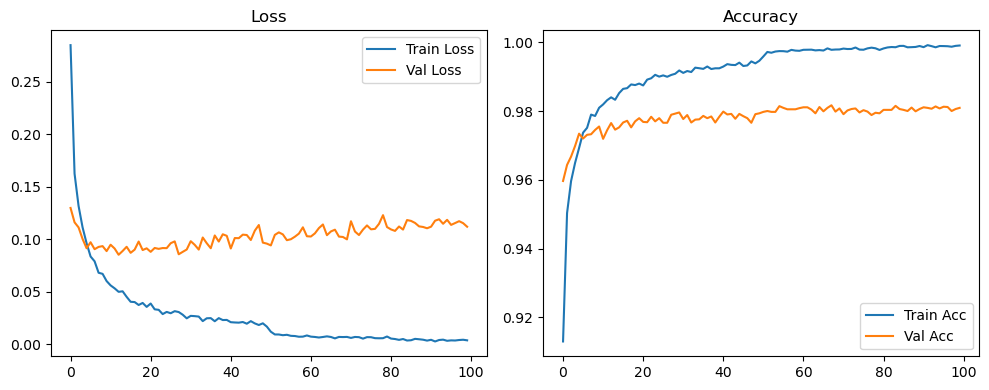

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4462, Acc: 0.8628 | Val Loss: 0.1764, Acc: 0.9443


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2785, Acc: 0.9161 | Val Loss: 0.1427, Acc: 0.9549


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2372, Acc: 0.9306 | Val Loss: 0.1280, Acc: 0.9607


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2179, Acc: 0.9355 | Val Loss: 0.1107, Acc: 0.9664


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1982, Acc: 0.9403 | Val Loss: 0.1061, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1848, Acc: 0.9444 | Val Loss: 0.1064, Acc: 0.9675


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1712, Acc: 0.9478 | Val Loss: 0.0983, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1625, Acc: 0.9513 | Val Loss: 0.1001, Acc: 0.9695


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1561, Acc: 0.9535 | Val Loss: 0.0972, Acc: 0.9711


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1503, Acc: 0.9548 | Val Loss: 0.0914, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9565 | Val Loss: 0.0923, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1392, Acc: 0.9579 | Val Loss: 0.0888, Acc: 0.9738


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1361, Acc: 0.9575 | Val Loss: 0.0875, Acc: 0.9748


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1340, Acc: 0.9591 | Val Loss: 0.0907, Acc: 0.9729


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1285, Acc: 0.9606 | Val Loss: 0.0883, Acc: 0.9749


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1202, Acc: 0.9632 | Val Loss: 0.0881, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9636 | Val Loss: 0.0884, Acc: 0.9756


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1186, Acc: 0.9646 | Val Loss: 0.0869, Acc: 0.9748


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1134, Acc: 0.9654 | Val Loss: 0.0839, Acc: 0.9766


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9664 | Val Loss: 0.0865, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1156, Acc: 0.9651 | Val Loss: 0.0828, Acc: 0.9768


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1023, Acc: 0.9678 | Val Loss: 0.0826, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1054, Acc: 0.9680 | Val Loss: 0.0873, Acc: 0.9756


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1051, Acc: 0.9690 | Val Loss: 0.0886, Acc: 0.9756


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9687 | Val Loss: 0.0854, Acc: 0.9761


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1051, Acc: 0.9688 | Val Loss: 0.0830, Acc: 0.9764


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9710 | Val Loss: 0.0878, Acc: 0.9761


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0961, Acc: 0.9711 | Val Loss: 0.0866, Acc: 0.9764


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0931, Acc: 0.9711 | Val Loss: 0.0907, Acc: 0.9753


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0876, Acc: 0.9727 | Val Loss: 0.0880, Acc: 0.9768


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0922, Acc: 0.9714 | Val Loss: 0.0856, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0873, Acc: 0.9729 | Val Loss: 0.0845, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0865, Acc: 0.9730 | Val Loss: 0.0851, Acc: 0.9774


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9734 | Val Loss: 0.0930, Acc: 0.9750


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9743 | Val Loss: 0.0882, Acc: 0.9764


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9737 | Val Loss: 0.0877, Acc: 0.9771


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9747 | Val Loss: 0.0882, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9743 | Val Loss: 0.0885, Acc: 0.9772


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9759 | Val Loss: 0.0878, Acc: 0.9743


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9751 | Val Loss: 0.0837, Acc: 0.9768


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9753 | Val Loss: 0.0866, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0749, Acc: 0.9766 | Val Loss: 0.0835, Acc: 0.9770


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9757 | Val Loss: 0.0866, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9750 | Val Loss: 0.0881, Acc: 0.9769


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9761 | Val Loss: 0.0895, Acc: 0.9767


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9759 | Val Loss: 0.0885, Acc: 0.9778


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9745 | Val Loss: 0.0831, Acc: 0.9779


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0883, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0774, Acc: 0.9765 | Val Loss: 0.0935, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9768 | Val Loss: 0.0939, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9805 | Val Loss: 0.0878, Acc: 0.9776


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.0872, Acc: 0.9774


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.0868, Acc: 0.9785


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9826 | Val Loss: 0.0881, Acc: 0.9786


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9832 | Val Loss: 0.0890, Acc: 0.9782


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9839 | Val Loss: 0.0884, Acc: 0.9784


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9828 | Val Loss: 0.0856, Acc: 0.9787


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 0.0903, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9845 | Val Loss: 0.0897, Acc: 0.9784


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9844 | Val Loss: 0.0858, Acc: 0.9783


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.0936, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9842 | Val Loss: 0.0902, Acc: 0.9779


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 0.0894, Acc: 0.9785


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.0888, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9850 | Val Loss: 0.0950, Acc: 0.9783


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9848 | Val Loss: 0.0893, Acc: 0.9785


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.0951, Acc: 0.9780


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.0846, Acc: 0.9796


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9851 | Val Loss: 0.0864, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9854 | Val Loss: 0.0836, Acc: 0.9786


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0910, Acc: 0.9779


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9863 | Val Loss: 0.0962, Acc: 0.9783


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9863 | Val Loss: 0.0964, Acc: 0.9781


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0476, Acc: 0.9853 | Val Loss: 0.0955, Acc: 0.9772


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0939, Acc: 0.9784


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9851 | Val Loss: 0.0948, Acc: 0.9780


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9866 | Val Loss: 0.0930, Acc: 0.9774


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.0980, Acc: 0.9778


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9862 | Val Loss: 0.0991, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.0914, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.0960, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.0990, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.0953, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0896, Acc: 0.9787


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9877 | Val Loss: 0.0942, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9879 | Val Loss: 0.0981, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0907, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9877 | Val Loss: 0.0857, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.0954, Acc: 0.9793


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9885 | Val Loss: 0.0896, Acc: 0.9785


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9884 | Val Loss: 0.0880, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.0959, Acc: 0.9786


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 0.0981, Acc: 0.9797


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.0948, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.0914, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9891 | Val Loss: 0.0948, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9892 | Val Loss: 0.0900, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0892, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.0928, Acc: 0.9782


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.0951, Acc: 0.9790


Final Test Loss: 0.0867 Accuracy: 0.9811


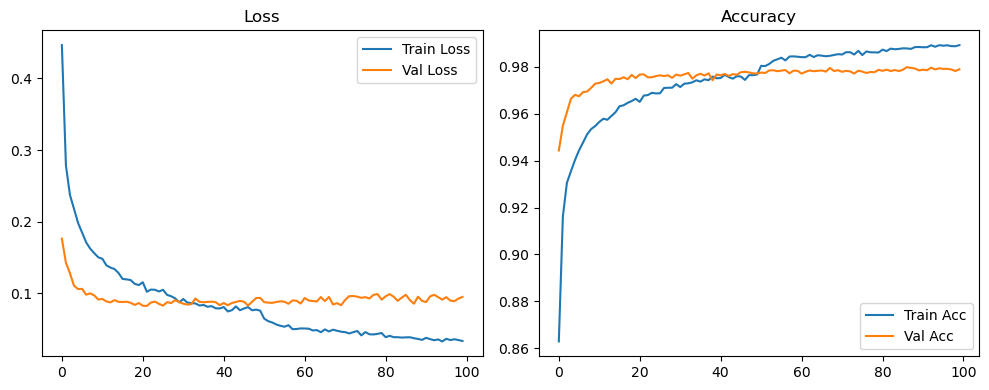

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2244, Acc: 0.9294 | Val Loss: 0.1179, Acc: 0.9642


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1106, Acc: 0.9655 | Val Loss: 0.1007, Acc: 0.9677


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0787, Acc: 0.9753 | Val Loss: 0.1091, Acc: 0.9663


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9798 | Val Loss: 0.0956, Acc: 0.9707


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9840 | Val Loss: 0.0949, Acc: 0.9745


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9859 | Val Loss: 0.0935, Acc: 0.9742


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9881 | Val Loss: 0.1019, Acc: 0.9728


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.1022, Acc: 0.9731


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.0987, Acc: 0.9748


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9905 | Val Loss: 0.0932, Acc: 0.9764


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0914, Acc: 0.9762


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0975, Acc: 0.9749


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.1012, Acc: 0.9751


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1030, Acc: 0.9769


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1013, Acc: 0.9768


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1162, Acc: 0.9737


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.0991, Acc: 0.9772


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1190, Acc: 0.9736


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0977, Acc: 0.9779


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.0977, Acc: 0.9773


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.1156, Acc: 0.9748


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0995, Acc: 0.9796


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1043, Acc: 0.9767


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1038, Acc: 0.9788


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1149, Acc: 0.9769


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1044, Acc: 0.9769


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1100, Acc: 0.9769


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1116, Acc: 0.9782


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1019, Acc: 0.9798


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1215, Acc: 0.9757


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1088, Acc: 0.9785


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1062, Acc: 0.9788


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1033, Acc: 0.9771


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1113, Acc: 0.9780


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1071, Acc: 0.9781


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1038, Acc: 0.9805


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1089, Acc: 0.9784


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1174, Acc: 0.9783


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1085, Acc: 0.9782


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9801


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1083, Acc: 0.9795


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1205, Acc: 0.9788


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1249, Acc: 0.9785


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1118, Acc: 0.9773


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1364, Acc: 0.9758


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1219, Acc: 0.9783


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1156, Acc: 0.9779


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1241, Acc: 0.9780


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1104, Acc: 0.9796


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1264, Acc: 0.9785


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1148, Acc: 0.9783


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1152, Acc: 0.9783


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1228, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1229, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1254, Acc: 0.9789


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1153, Acc: 0.9805


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1067, Acc: 0.9807


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1199, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1295, Acc: 0.9783


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1153, Acc: 0.9784


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1221, Acc: 0.9796


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1274, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1181, Acc: 0.9803


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1163, Acc: 0.9801


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1212, Acc: 0.9784


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1181, Acc: 0.9786


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1171, Acc: 0.9780


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1262, Acc: 0.9780


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1128, Acc: 0.9793


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1199, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1193, Acc: 0.9784


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1133, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1280, Acc: 0.9780


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1186, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1078, Acc: 0.9794


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1119, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1172, Acc: 0.9790


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1205, Acc: 0.9790


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1187, Acc: 0.9791


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1150, Acc: 0.9808


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1199, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1224, Acc: 0.9791


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1208, Acc: 0.9791


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1147, Acc: 0.9803


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1201, Acc: 0.9793


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1248, Acc: 0.9792


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1280, Acc: 0.9796


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1451, Acc: 0.9771


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1162, Acc: 0.9790


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1159, Acc: 0.9794


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1201, Acc: 0.9807


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1159, Acc: 0.9789


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1283, Acc: 0.9784


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1248, Acc: 0.9784


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1221, Acc: 0.9807


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1275, Acc: 0.9798


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1305, Acc: 0.9778


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1426, Acc: 0.9759


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1153, Acc: 0.9804


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1229, Acc: 0.9790


Final Test Loss: 0.1150 Accuracy: 0.9807


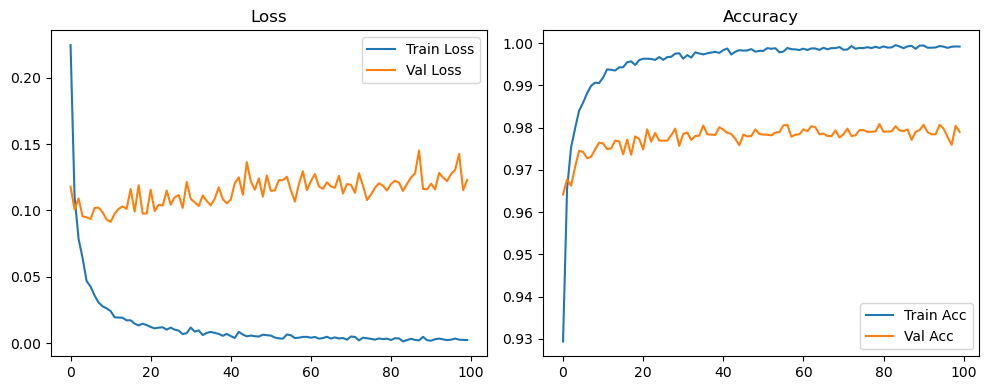

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2820, Acc: 0.9136 | Val Loss: 0.1252, Acc: 0.9607


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1515, Acc: 0.9540 | Val Loss: 0.1135, Acc: 0.9614


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1234, Acc: 0.9621 | Val Loss: 0.0982, Acc: 0.9692


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1051, Acc: 0.9674 | Val Loss: 0.0874, Acc: 0.9729


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0896, Acc: 0.9711 | Val Loss: 0.0853, Acc: 0.9742


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0765, Acc: 0.9758 | Val Loss: 0.0847, Acc: 0.9745


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9776 | Val Loss: 0.0802, Acc: 0.9751


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9792 | Val Loss: 0.0988, Acc: 0.9707


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0569, Acc: 0.9812 | Val Loss: 0.0874, Acc: 0.9757


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9817 | Val Loss: 0.0870, Acc: 0.9744


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9840 | Val Loss: 0.0851, Acc: 0.9757


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0836, Acc: 0.9757


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9847 | Val Loss: 0.0862, Acc: 0.9766


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9857 | Val Loss: 0.0794, Acc: 0.9776


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9867 | Val Loss: 0.0815, Acc: 0.9766


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9871 | Val Loss: 0.0768, Acc: 0.9788


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9885 | Val Loss: 0.0886, Acc: 0.9772


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.0834, Acc: 0.9782


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0811, Acc: 0.9784


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0795, Acc: 0.9797


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0892, Acc: 0.9776


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9907 | Val Loss: 0.0827, Acc: 0.9792


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0847, Acc: 0.9795


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.0912, Acc: 0.9773


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0862, Acc: 0.9785


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0820, Acc: 0.9789


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0903, Acc: 0.9782


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0893, Acc: 0.9781


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.0942, Acc: 0.9772


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9924 | Val Loss: 0.0884, Acc: 0.9785


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9923 | Val Loss: 0.0995, Acc: 0.9772


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0925, Acc: 0.9781


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0883, Acc: 0.9789


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0901, Acc: 0.9797


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0883, Acc: 0.9782


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0889, Acc: 0.9794


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0903, Acc: 0.9788


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0907, Acc: 0.9786


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0946, Acc: 0.9790


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9934 | Val Loss: 0.0873, Acc: 0.9795


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0883, Acc: 0.9787


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0902, Acc: 0.9790


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0879, Acc: 0.9804


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9937 | Val Loss: 0.0918, Acc: 0.9788


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0999, Acc: 0.9786


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.0917, Acc: 0.9782


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0946, Acc: 0.9798


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0980, Acc: 0.9788


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0940, Acc: 0.9782


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0938, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0914, Acc: 0.9801


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.0952, Acc: 0.9783


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0968, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0963, Acc: 0.9794


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0853, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0931, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0917, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0933, Acc: 0.9791


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0983, Acc: 0.9786


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0981, Acc: 0.9784


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0980, Acc: 0.9784


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0974, Acc: 0.9782


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0942, Acc: 0.9795


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1007, Acc: 0.9792


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0976, Acc: 0.9790


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0970, Acc: 0.9791


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0966, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1009, Acc: 0.9794


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0934, Acc: 0.9801


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1034, Acc: 0.9793


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1075, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1028, Acc: 0.9813


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0905, Acc: 0.9807


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0955, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.0978, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0964, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0993, Acc: 0.9799


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1093, Acc: 0.9785


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1046, Acc: 0.9790


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0979, Acc: 0.9803


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0985, Acc: 0.9795


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1090, Acc: 0.9794


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1118, Acc: 0.9798


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1084, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0990, Acc: 0.9791


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1029, Acc: 0.9791


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0996, Acc: 0.9796


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0986, Acc: 0.9806


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1012, Acc: 0.9802


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0999, Acc: 0.9794


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0963, Acc: 0.9817


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0986, Acc: 0.9794


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1029, Acc: 0.9797


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0965, Acc: 0.9797


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1049, Acc: 0.9792


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0976, Acc: 0.9788


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0978, Acc: 0.9801


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1019, Acc: 0.9782


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1118, Acc: 0.9781


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1085, Acc: 0.9786


Final Test Loss: 0.1053 Accuracy: 0.9807


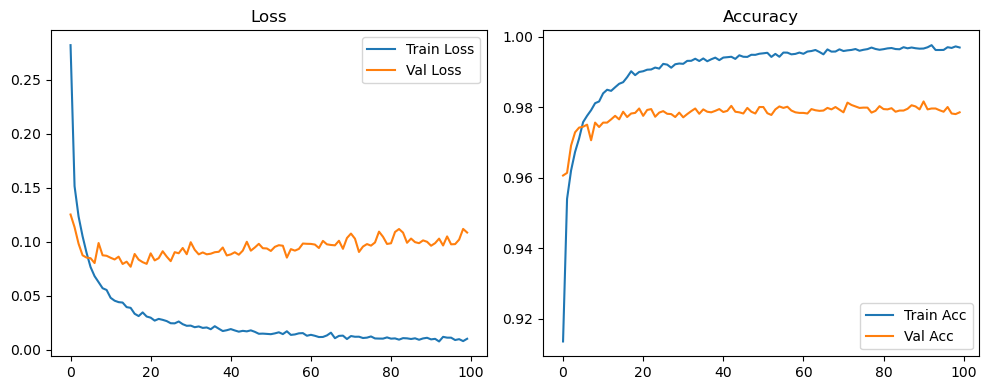

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4541, Acc: 0.8623 | Val Loss: 0.1824, Acc: 0.9453


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2735, Acc: 0.9182 | Val Loss: 0.1389, Acc: 0.9573


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2346, Acc: 0.9300 | Val Loss: 0.1261, Acc: 0.9626


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2105, Acc: 0.9368 | Val Loss: 0.1138, Acc: 0.9652


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1886, Acc: 0.9429 | Val Loss: 0.1037, Acc: 0.9692


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1707, Acc: 0.9497 | Val Loss: 0.1038, Acc: 0.9687


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1598, Acc: 0.9513 | Val Loss: 0.1006, Acc: 0.9705


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1503, Acc: 0.9546 | Val Loss: 0.0961, Acc: 0.9719


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1443, Acc: 0.9559 | Val Loss: 0.0964, Acc: 0.9718


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1385, Acc: 0.9573 | Val Loss: 0.0924, Acc: 0.9711


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1331, Acc: 0.9587 | Val Loss: 0.0921, Acc: 0.9731


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1270, Acc: 0.9606 | Val Loss: 0.0874, Acc: 0.9734


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1232, Acc: 0.9626 | Val Loss: 0.0850, Acc: 0.9746


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1135, Acc: 0.9644 | Val Loss: 0.0857, Acc: 0.9752


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1136, Acc: 0.9647 | Val Loss: 0.0859, Acc: 0.9742


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1098, Acc: 0.9665 | Val Loss: 0.0878, Acc: 0.9743


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1076, Acc: 0.9662 | Val Loss: 0.0831, Acc: 0.9758


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1052, Acc: 0.9672 | Val Loss: 0.0834, Acc: 0.9756


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1027, Acc: 0.9690 | Val Loss: 0.0817, Acc: 0.9763


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1007, Acc: 0.9681 | Val Loss: 0.0874, Acc: 0.9761


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0977, Acc: 0.9693 | Val Loss: 0.0815, Acc: 0.9780


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0932, Acc: 0.9710 | Val Loss: 0.0836, Acc: 0.9755


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0948, Acc: 0.9708 | Val Loss: 0.0815, Acc: 0.9769


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0908, Acc: 0.9716 | Val Loss: 0.0854, Acc: 0.9759


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0877, Acc: 0.9724 | Val Loss: 0.0845, Acc: 0.9770


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0910, Acc: 0.9729 | Val Loss: 0.0815, Acc: 0.9782


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0875, Acc: 0.9723 | Val Loss: 0.0825, Acc: 0.9769


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0862, Acc: 0.9728 | Val Loss: 0.0797, Acc: 0.9776


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9749 | Val Loss: 0.0822, Acc: 0.9772


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0788, Acc: 0.9741 | Val Loss: 0.0815, Acc: 0.9784


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0850, Acc: 0.9741 | Val Loss: 0.0808, Acc: 0.9776


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0783, Acc: 0.9756 | Val Loss: 0.0795, Acc: 0.9779


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0796, Acc: 0.9750 | Val Loss: 0.0769, Acc: 0.9790


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9760 | Val Loss: 0.0814, Acc: 0.9781


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0769, Acc: 0.9761 | Val Loss: 0.0834, Acc: 0.9789


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0757, Acc: 0.9766 | Val Loss: 0.0846, Acc: 0.9762


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0730, Acc: 0.9770 | Val Loss: 0.0826, Acc: 0.9766


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9775 | Val Loss: 0.0816, Acc: 0.9778


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9778 | Val Loss: 0.0866, Acc: 0.9768


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0712, Acc: 0.9771 | Val Loss: 0.0807, Acc: 0.9780


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9769 | Val Loss: 0.0850, Acc: 0.9767


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9784 | Val Loss: 0.0801, Acc: 0.9791


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9779 | Val Loss: 0.0815, Acc: 0.9776


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0696, Acc: 0.9778 | Val Loss: 0.0816, Acc: 0.9776


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9789 | Val Loss: 0.0837, Acc: 0.9782


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9784 | Val Loss: 0.0862, Acc: 0.9772


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9790 | Val Loss: 0.0850, Acc: 0.9778


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9795 | Val Loss: 0.0841, Acc: 0.9780


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9800 | Val Loss: 0.0812, Acc: 0.9781


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9806 | Val Loss: 0.0835, Acc: 0.9791


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9799 | Val Loss: 0.0841, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9795 | Val Loss: 0.0869, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9807 | Val Loss: 0.0840, Acc: 0.9793


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9805 | Val Loss: 0.0863, Acc: 0.9779


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9807 | Val Loss: 0.0810, Acc: 0.9791


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9811 | Val Loss: 0.0840, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9810 | Val Loss: 0.0880, Acc: 0.9785


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9818 | Val Loss: 0.0826, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9820 | Val Loss: 0.0864, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9821 | Val Loss: 0.0825, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0565, Acc: 0.9817 | Val Loss: 0.0884, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9814 | Val Loss: 0.0902, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9816 | Val Loss: 0.0863, Acc: 0.9785


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0530, Acc: 0.9829 | Val Loss: 0.0942, Acc: 0.9780


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.0862, Acc: 0.9786


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0584, Acc: 0.9815 | Val Loss: 0.0870, Acc: 0.9779


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9818 | Val Loss: 0.0930, Acc: 0.9764


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9829 | Val Loss: 0.0887, Acc: 0.9771


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9819 | Val Loss: 0.0864, Acc: 0.9774


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9826 | Val Loss: 0.0903, Acc: 0.9773


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9837 | Val Loss: 0.0875, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.0903, Acc: 0.9772


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9829 | Val Loss: 0.0871, Acc: 0.9784


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9841 | Val Loss: 0.0849, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9834 | Val Loss: 0.0881, Acc: 0.9776


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0834, Acc: 0.9795


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9842 | Val Loss: 0.0904, Acc: 0.9763


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9830 | Val Loss: 0.0907, Acc: 0.9767


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9839 | Val Loss: 0.0929, Acc: 0.9769


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9844 | Val Loss: 0.0925, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9856 | Val Loss: 0.0918, Acc: 0.9771


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 0.0952, Acc: 0.9767


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9826 | Val Loss: 0.0898, Acc: 0.9774


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9845 | Val Loss: 0.0891, Acc: 0.9773


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9841 | Val Loss: 0.0930, Acc: 0.9763


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9842 | Val Loss: 0.0876, Acc: 0.9775


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9834 | Val Loss: 0.0930, Acc: 0.9767


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9848 | Val Loss: 0.0960, Acc: 0.9768


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9848 | Val Loss: 0.0947, Acc: 0.9764


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.0951, Acc: 0.9768


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9849 | Val Loss: 0.0909, Acc: 0.9762


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9851 | Val Loss: 0.0925, Acc: 0.9775


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.0947, Acc: 0.9782


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 0.0892, Acc: 0.9770


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9862 | Val Loss: 0.0908, Acc: 0.9782


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9850 | Val Loss: 0.0941, Acc: 0.9775


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9864 | Val Loss: 0.0940, Acc: 0.9777


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9857 | Val Loss: 0.0920, Acc: 0.9778


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9855 | Val Loss: 0.0952, Acc: 0.9769


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9858 | Val Loss: 0.0938, Acc: 0.9780


Final Test Loss: 0.0819 Accuracy: 0.9814


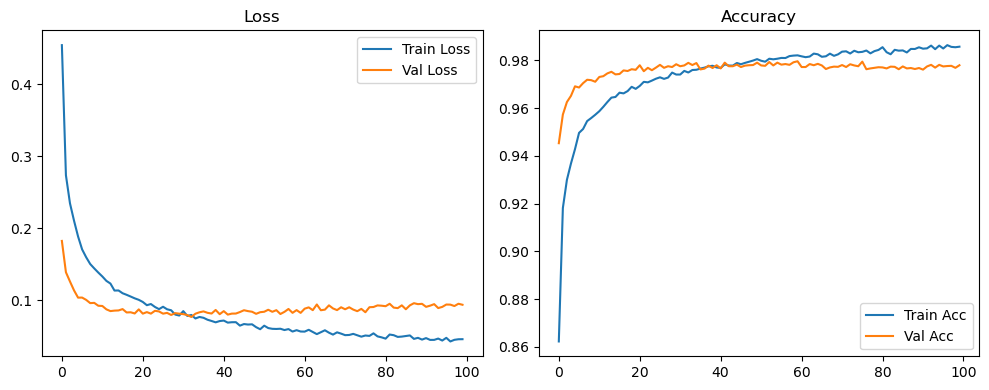

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2238, Acc: 0.9330 | Val Loss: 0.1184, Acc: 0.9637


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1028, Acc: 0.9680 | Val Loss: 0.1008, Acc: 0.9686


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9767 | Val Loss: 0.0997, Acc: 0.9693


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9814 | Val Loss: 0.0840, Acc: 0.9742


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9862 | Val Loss: 0.0842, Acc: 0.9746


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 0.0981, Acc: 0.9733


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9886 | Val Loss: 0.0913, Acc: 0.9737


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0963, Acc: 0.9731


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.1000, Acc: 0.9729


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9907 | Val Loss: 0.0991, Acc: 0.9743


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0929, Acc: 0.9768


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0919, Acc: 0.9777


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9937 | Val Loss: 0.1075, Acc: 0.9750


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0944, Acc: 0.9767


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1063, Acc: 0.9752


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1008, Acc: 0.9760


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0932, Acc: 0.9777


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0988, Acc: 0.9761


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1030, Acc: 0.9768


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1081, Acc: 0.9761


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1012, Acc: 0.9769


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1041, Acc: 0.9771


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0991, Acc: 0.9788


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1089, Acc: 0.9774


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1039, Acc: 0.9769


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1063, Acc: 0.9780


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1247, Acc: 0.9769


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1093, Acc: 0.9778


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.1160, Acc: 0.9753


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1224, Acc: 0.9764


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1269, Acc: 0.9739


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1063, Acc: 0.9781


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1066, Acc: 0.9796


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1156, Acc: 0.9772


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1234, Acc: 0.9772


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1197, Acc: 0.9782


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1314, Acc: 0.9761


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1202, Acc: 0.9769


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1140, Acc: 0.9792


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1068, Acc: 0.9802


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1147, Acc: 0.9777


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1119, Acc: 0.9798


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1158, Acc: 0.9783


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1159, Acc: 0.9784


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1213, Acc: 0.9780


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1233, Acc: 0.9778


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1294, Acc: 0.9780


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1211, Acc: 0.9779


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1221, Acc: 0.9778


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1320, Acc: 0.9768


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1242, Acc: 0.9772


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1130, Acc: 0.9789


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1271, Acc: 0.9776


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1218, Acc: 0.9777


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1238, Acc: 0.9790


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1231, Acc: 0.9798


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1263, Acc: 0.9788


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1328, Acc: 0.9782


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1350, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1356, Acc: 0.9773


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1362, Acc: 0.9771


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1323, Acc: 0.9787


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1225, Acc: 0.9792


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1265, Acc: 0.9777


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1261, Acc: 0.9792


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1235, Acc: 0.9803


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1192, Acc: 0.9796


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1196, Acc: 0.9789


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1180, Acc: 0.9797


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1235, Acc: 0.9782


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1197, Acc: 0.9801


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1391, Acc: 0.9779


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1316, Acc: 0.9792


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1305, Acc: 0.9811


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1290, Acc: 0.9796


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1377, Acc: 0.9780


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1283, Acc: 0.9808


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1321, Acc: 0.9796


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1326, Acc: 0.9796


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1240, Acc: 0.9807


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1197, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1307, Acc: 0.9794


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1301, Acc: 0.9787


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1321, Acc: 0.9791


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1346, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1359, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1294, Acc: 0.9795


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1219, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1320, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1255, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1323, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1346, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1377, Acc: 0.9785


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1329, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1304, Acc: 0.9793


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1335, Acc: 0.9784


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1353, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1410, Acc: 0.9773


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1290, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.1269, Acc: 0.9802


Final Test Loss: 0.1325 Accuracy: 0.9798


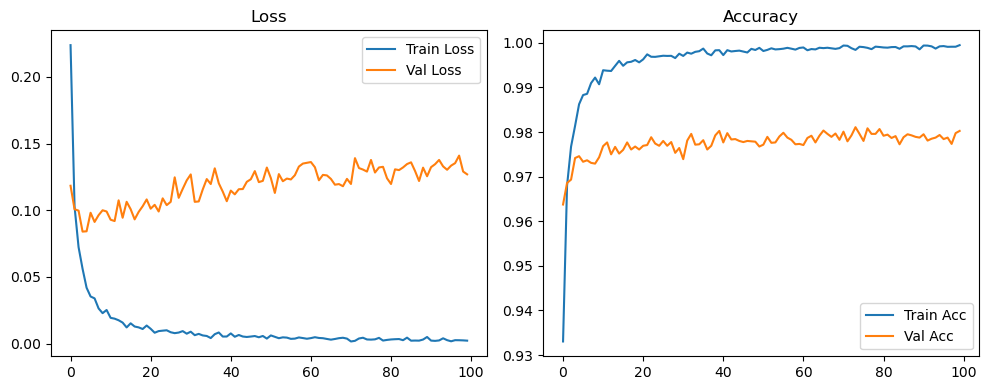

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2980, Acc: 0.9102 | Val Loss: 0.1283, Acc: 0.9607


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1502, Acc: 0.9539 | Val Loss: 0.1081, Acc: 0.9666


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1220, Acc: 0.9610 | Val Loss: 0.0995, Acc: 0.9692


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1035, Acc: 0.9677 | Val Loss: 0.0890, Acc: 0.9734


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0851, Acc: 0.9728 | Val Loss: 0.0852, Acc: 0.9744


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9752 | Val Loss: 0.0876, Acc: 0.9723


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9781 | Val Loss: 0.0845, Acc: 0.9743


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9816 | Val Loss: 0.0823, Acc: 0.9757


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9814 | Val Loss: 0.0891, Acc: 0.9752


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0535, Acc: 0.9824 | Val Loss: 0.0846, Acc: 0.9776


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0485, Acc: 0.9841 | Val Loss: 0.0855, Acc: 0.9752


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 0.0811, Acc: 0.9752


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9864 | Val Loss: 0.0913, Acc: 0.9751


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.0869, Acc: 0.9762


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.0869, Acc: 0.9771


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.0861, Acc: 0.9768


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9881 | Val Loss: 0.0858, Acc: 0.9782


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.0871, Acc: 0.9770


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0859, Acc: 0.9772


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.0952, Acc: 0.9761


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9891 | Val Loss: 0.0846, Acc: 0.9781


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9905 | Val Loss: 0.0802, Acc: 0.9776


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0837, Acc: 0.9782


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9910 | Val Loss: 0.0970, Acc: 0.9778


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0888, Acc: 0.9786


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0937, Acc: 0.9768


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.0978, Acc: 0.9765


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0900, Acc: 0.9784


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0945, Acc: 0.9768


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9780


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0958, Acc: 0.9782


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0914, Acc: 0.9789


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0949, Acc: 0.9785


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0941, Acc: 0.9784


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0980, Acc: 0.9765


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0907, Acc: 0.9792


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0879, Acc: 0.9788


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0917, Acc: 0.9788


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.0959, Acc: 0.9792


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.0888, Acc: 0.9802


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0971, Acc: 0.9795


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.1004, Acc: 0.9776


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1004, Acc: 0.9784


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0946, Acc: 0.9790


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0919, Acc: 0.9796


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0985, Acc: 0.9796


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1004, Acc: 0.9790


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1028, Acc: 0.9781


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.0922, Acc: 0.9788


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0947, Acc: 0.9803


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1017, Acc: 0.9777


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0966, Acc: 0.9802


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1043, Acc: 0.9799


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1047, Acc: 0.9784


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0959, Acc: 0.9788


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0944, Acc: 0.9797


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0979, Acc: 0.9799


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0946, Acc: 0.9794


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0989, Acc: 0.9791


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.1000, Acc: 0.9788


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1073, Acc: 0.9778


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1029, Acc: 0.9792


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1001, Acc: 0.9789


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0966, Acc: 0.9796


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1053, Acc: 0.9782


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1012, Acc: 0.9795


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1084, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0959, Acc: 0.9796


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1012, Acc: 0.9801


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1044, Acc: 0.9792


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1070, Acc: 0.9798


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1033, Acc: 0.9781


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0982, Acc: 0.9800


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1033, Acc: 0.9795


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1016, Acc: 0.9789


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1012, Acc: 0.9789


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1009, Acc: 0.9786


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1000, Acc: 0.9802


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1025, Acc: 0.9800


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1051, Acc: 0.9810


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1087, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1032, Acc: 0.9791


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9963 | Val Loss: 0.1021, Acc: 0.9800


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1022, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1055, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1090, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1044, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1080, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1070, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1003, Acc: 0.9807


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1074, Acc: 0.9801


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1019, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1087, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1040, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1136, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1106, Acc: 0.9793


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1096, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1103, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1159, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1129, Acc: 0.9799


Final Test Loss: 0.0984 Accuracy: 0.9817


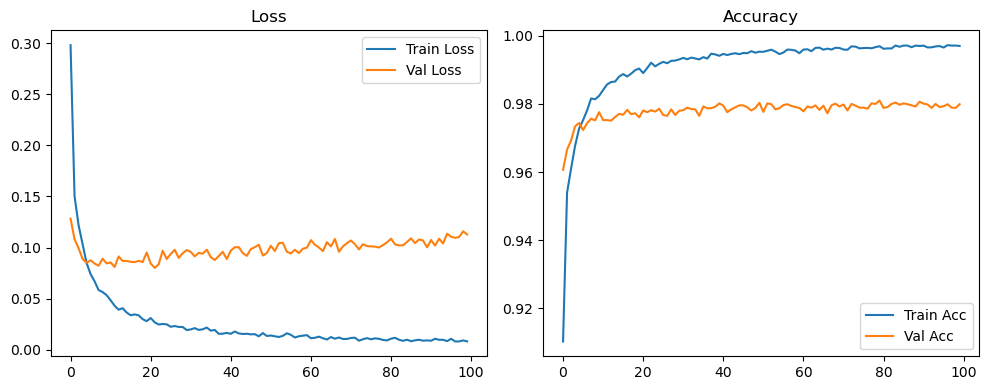

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5033, Acc: 0.8483 | Val Loss: 0.1922, Acc: 0.9406


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2830, Acc: 0.9159 | Val Loss: 0.1466, Acc: 0.9548


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2360, Acc: 0.9289 | Val Loss: 0.1320, Acc: 0.9597


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2128, Acc: 0.9355 | Val Loss: 0.1185, Acc: 0.9637


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1908, Acc: 0.9412 | Val Loss: 0.1095, Acc: 0.9656


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1752, Acc: 0.9467 | Val Loss: 0.1092, Acc: 0.9677


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1627, Acc: 0.9509 | Val Loss: 0.1032, Acc: 0.9672


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1546, Acc: 0.9524 | Val Loss: 0.0970, Acc: 0.9702


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1453, Acc: 0.9547 | Val Loss: 0.0967, Acc: 0.9703


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1390, Acc: 0.9565 | Val Loss: 0.0963, Acc: 0.9704


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1351, Acc: 0.9576 | Val Loss: 0.0924, Acc: 0.9708


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1278, Acc: 0.9601 | Val Loss: 0.0870, Acc: 0.9741


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1224, Acc: 0.9628 | Val Loss: 0.0896, Acc: 0.9732


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1200, Acc: 0.9635 | Val Loss: 0.0867, Acc: 0.9746


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1135, Acc: 0.9648 | Val Loss: 0.0884, Acc: 0.9742


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1069, Acc: 0.9673 | Val Loss: 0.0865, Acc: 0.9740


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1057, Acc: 0.9668 | Val Loss: 0.0864, Acc: 0.9741


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1046, Acc: 0.9675 | Val Loss: 0.0842, Acc: 0.9751


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1008, Acc: 0.9688 | Val Loss: 0.0818, Acc: 0.9765


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0974, Acc: 0.9699 | Val Loss: 0.0871, Acc: 0.9754


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0960, Acc: 0.9696 | Val Loss: 0.0864, Acc: 0.9760


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0903, Acc: 0.9718 | Val Loss: 0.0848, Acc: 0.9757


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0894, Acc: 0.9715 | Val Loss: 0.0833, Acc: 0.9767


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0887, Acc: 0.9723 | Val Loss: 0.0852, Acc: 0.9755


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0888, Acc: 0.9722 | Val Loss: 0.0829, Acc: 0.9758


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0867, Acc: 0.9721 | Val Loss: 0.0789, Acc: 0.9779


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9737 | Val Loss: 0.0834, Acc: 0.9770


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0824, Acc: 0.9739 | Val Loss: 0.0841, Acc: 0.9773


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0796, Acc: 0.9744 | Val Loss: 0.0818, Acc: 0.9772


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0746, Acc: 0.9755 | Val Loss: 0.0854, Acc: 0.9772


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0764, Acc: 0.9757 | Val Loss: 0.0881, Acc: 0.9770


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0734, Acc: 0.9758 | Val Loss: 0.0835, Acc: 0.9757


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9758 | Val Loss: 0.0853, Acc: 0.9768


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0715, Acc: 0.9775 | Val Loss: 0.0844, Acc: 0.9769


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0729, Acc: 0.9769 | Val Loss: 0.0871, Acc: 0.9758


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0721, Acc: 0.9769 | Val Loss: 0.0865, Acc: 0.9767


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9765 | Val Loss: 0.0847, Acc: 0.9775


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9770 | Val Loss: 0.0858, Acc: 0.9773


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0672, Acc: 0.9786 | Val Loss: 0.0855, Acc: 0.9770


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9778 | Val Loss: 0.0802, Acc: 0.9772


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0696, Acc: 0.9774 | Val Loss: 0.0819, Acc: 0.9772


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9791 | Val Loss: 0.0802, Acc: 0.9795


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9798 | Val Loss: 0.0852, Acc: 0.9768


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.0832, Acc: 0.9765


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0674, Acc: 0.9784 | Val Loss: 0.0868, Acc: 0.9772


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0645, Acc: 0.9788 | Val Loss: 0.0823, Acc: 0.9768


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0645, Acc: 0.9787 | Val Loss: 0.0837, Acc: 0.9781


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9811 | Val Loss: 0.0881, Acc: 0.9766


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0608, Acc: 0.9805 | Val Loss: 0.0834, Acc: 0.9770


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0604, Acc: 0.9804 | Val Loss: 0.0852, Acc: 0.9769


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9805 | Val Loss: 0.0864, Acc: 0.9757


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9804 | Val Loss: 0.0850, Acc: 0.9769


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0566, Acc: 0.9820 | Val Loss: 0.0866, Acc: 0.9769


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0590, Acc: 0.9808 | Val Loss: 0.0876, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0592, Acc: 0.9811 | Val Loss: 0.0819, Acc: 0.9779


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9819 | Val Loss: 0.0811, Acc: 0.9785


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9824 | Val Loss: 0.0871, Acc: 0.9768


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9825 | Val Loss: 0.0857, Acc: 0.9777


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9826 | Val Loss: 0.0838, Acc: 0.9785


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9825 | Val Loss: 0.0875, Acc: 0.9768


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9828 | Val Loss: 0.0874, Acc: 0.9772


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.0911, Acc: 0.9775


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.0857, Acc: 0.9786


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9816 | Val Loss: 0.0886, Acc: 0.9771


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9839 | Val Loss: 0.0901, Acc: 0.9772


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0545, Acc: 0.9823 | Val Loss: 0.0877, Acc: 0.9774


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9830 | Val Loss: 0.0888, Acc: 0.9778


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9831 | Val Loss: 0.0871, Acc: 0.9778


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9834 | Val Loss: 0.0895, Acc: 0.9772


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0523, Acc: 0.9833 | Val Loss: 0.0890, Acc: 0.9768


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9837 | Val Loss: 0.0926, Acc: 0.9773


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9833 | Val Loss: 0.0913, Acc: 0.9771


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9846 | Val Loss: 0.0880, Acc: 0.9772


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9842 | Val Loss: 0.0904, Acc: 0.9775


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0900, Acc: 0.9776


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0892, Acc: 0.9772


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 0.0897, Acc: 0.9782


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0930, Acc: 0.9775


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9842 | Val Loss: 0.0900, Acc: 0.9773


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9853 | Val Loss: 0.0900, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9849 | Val Loss: 0.0943, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.0947, Acc: 0.9776


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9838 | Val Loss: 0.0933, Acc: 0.9775


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 0.0910, Acc: 0.9781


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9851 | Val Loss: 0.0924, Acc: 0.9776


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.0921, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.0886, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9855 | Val Loss: 0.0935, Acc: 0.9781


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9848 | Val Loss: 0.0922, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0457, Acc: 0.9855 | Val Loss: 0.0889, Acc: 0.9779


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9856 | Val Loss: 0.0881, Acc: 0.9787


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9856 | Val Loss: 0.0938, Acc: 0.9783


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9859 | Val Loss: 0.0940, Acc: 0.9781


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9858 | Val Loss: 0.0936, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.0962, Acc: 0.9774


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.1002, Acc: 0.9769


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.0955, Acc: 0.9770


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9866 | Val Loss: 0.0925, Acc: 0.9779


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.0891, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9856 | Val Loss: 0.0881, Acc: 0.9782


Final Test Loss: 0.0752 Accuracy: 0.9813


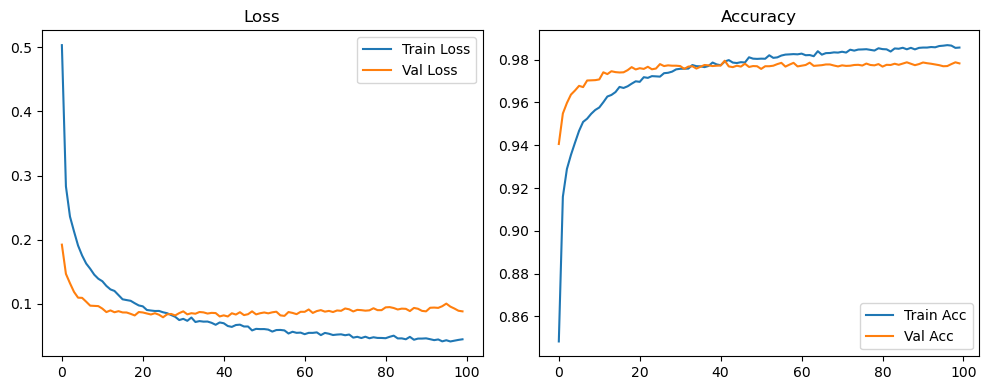

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2299, Acc: 0.9297 | Val Loss: 0.1358, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9649 | Val Loss: 0.1106, Acc: 0.9649


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9755 | Val Loss: 0.1114, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9806 | Val Loss: 0.1062, Acc: 0.9708


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9829 | Val Loss: 0.1099, Acc: 0.9687


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.1062, Acc: 0.9727


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.1078, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0956, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9704


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1183, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1056, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.1227, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1104, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1208, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.1270, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1345, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1191, Acc: 0.9751


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1204, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1118, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1258, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1279, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1079, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1111, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1254, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1218, Acc: 0.9744


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1184, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1178, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1358, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1118, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1215, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1264, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1296, Acc: 0.9734


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1286, Acc: 0.9744


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1157, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1210, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1239, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1164, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1220, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1399, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1103, Acc: 0.9748


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1217, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1483, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1271, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1213, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1203, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1223, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1269, Acc: 0.9783


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1394, Acc: 0.9763


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1227, Acc: 0.9758


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1386, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1244, Acc: 0.9777


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1352, Acc: 0.9754


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1274, Acc: 0.9782


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1412, Acc: 0.9772


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1202, Acc: 0.9773


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1365, Acc: 0.9761


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1229, Acc: 0.9794


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1488, Acc: 0.9757


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1383, Acc: 0.9765


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1358, Acc: 0.9749


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1286, Acc: 0.9763


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1416, Acc: 0.9772


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1278, Acc: 0.9759


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1307, Acc: 0.9774


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1339, Acc: 0.9762


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1349, Acc: 0.9768


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1476, Acc: 0.9759


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1283, Acc: 0.9751


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1653, Acc: 0.9756


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1333, Acc: 0.9768


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1459, Acc: 0.9736


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1489, Acc: 0.9762


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1424, Acc: 0.9769


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1555, Acc: 0.9748


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1395, Acc: 0.9757


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1187, Acc: 0.9776


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1568, Acc: 0.9770


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1285, Acc: 0.9772


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1555, Acc: 0.9760


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1308, Acc: 0.9746


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1286, Acc: 0.9748


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1425, Acc: 0.9776


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1351, Acc: 0.9775


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1202, Acc: 0.9756


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1379, Acc: 0.9777


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1266, Acc: 0.9773


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1229, Acc: 0.9744


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1507, Acc: 0.9768


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1357, Acc: 0.9768


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1410, Acc: 0.9783


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1293, Acc: 0.9752


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1543, Acc: 0.9761


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1086, Acc: 0.9768


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1599, Acc: 0.9767


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1409, Acc: 0.9764


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1395, Acc: 0.9753


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9762


Final Test Loss: 0.1114 Accuracy: 0.9793


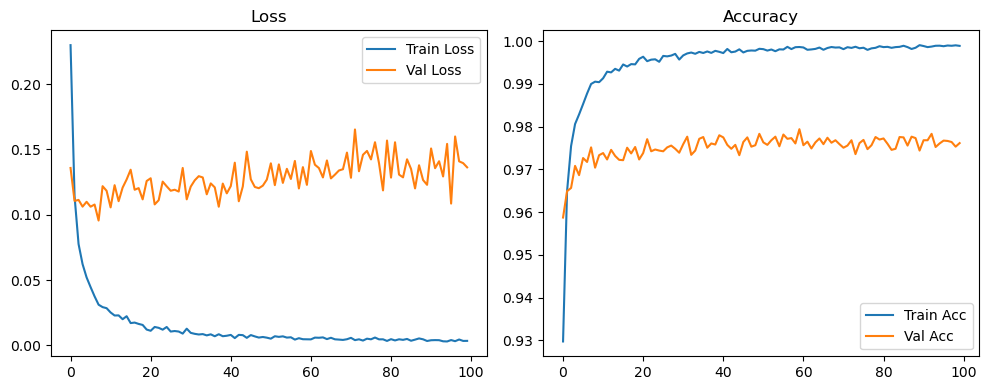

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2773, Acc: 0.9152 | Val Loss: 0.1434, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1517, Acc: 0.9532 | Val Loss: 0.1186, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9627 | Val Loss: 0.1157, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9702 | Val Loss: 0.1021, Acc: 0.9695


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9732 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0932, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.0921, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9805 | Val Loss: 0.1013, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9807 | Val Loss: 0.0937, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9828 | Val Loss: 0.0971, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9837 | Val Loss: 0.0949, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0973, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.1027, Acc: 0.9746


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9872 | Val Loss: 0.1103, Acc: 0.9751


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0969, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0927, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1071, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0924, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0907, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0887, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0903, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.0941, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0977, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.0930, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0973, Acc: 0.9763


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.1011, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0877, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1047, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0966, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1087, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0944, Acc: 0.9777


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0968, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0954, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.0939, Acc: 0.9783


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0966, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1045, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.1064, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1020, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0915, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1062, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1290, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0967, Acc: 0.9774


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0839, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1002, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0941, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0962, Acc: 0.9774


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0861, Acc: 0.9768


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1194, Acc: 0.9772


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1017, Acc: 0.9788


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1103, Acc: 0.9773


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1005, Acc: 0.9774


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1079, Acc: 0.9775


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0917, Acc: 0.9778


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9931 | Val Loss: 0.0940, Acc: 0.9782


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1012, Acc: 0.9778


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.1188, Acc: 0.9787


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1065, Acc: 0.9769


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0980, Acc: 0.9796


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0959, Acc: 0.9777


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1201, Acc: 0.9782


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.1015, Acc: 0.9778


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0983, Acc: 0.9767


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.1041, Acc: 0.9778


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0983, Acc: 0.9782


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1041, Acc: 0.9762


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1172, Acc: 0.9763


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0881, Acc: 0.9792


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0897, Acc: 0.9786


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0850, Acc: 0.9788


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.0923, Acc: 0.9782


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1119, Acc: 0.9785


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0771, Acc: 0.9795


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0941, Acc: 0.9781


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1058, Acc: 0.9776


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0912, Acc: 0.9802


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1124, Acc: 0.9802


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.1051, Acc: 0.9778


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0978, Acc: 0.9774


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1029, Acc: 0.9780


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0983, Acc: 0.9775


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.1074, Acc: 0.9781


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1124, Acc: 0.9782


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1184, Acc: 0.9771


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0958, Acc: 0.9782


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.1175, Acc: 0.9782


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0944, Acc: 0.9778


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.0855, Acc: 0.9784


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1007, Acc: 0.9790


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1014, Acc: 0.9789


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1173, Acc: 0.9782


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.1022, Acc: 0.9782


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1078, Acc: 0.9780


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0853, Acc: 0.9784


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9961 | Val Loss: 0.1162, Acc: 0.9781


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0915, Acc: 0.9793


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1136, Acc: 0.9788


Final Test Loss: 0.1171 Accuracy: 0.9797


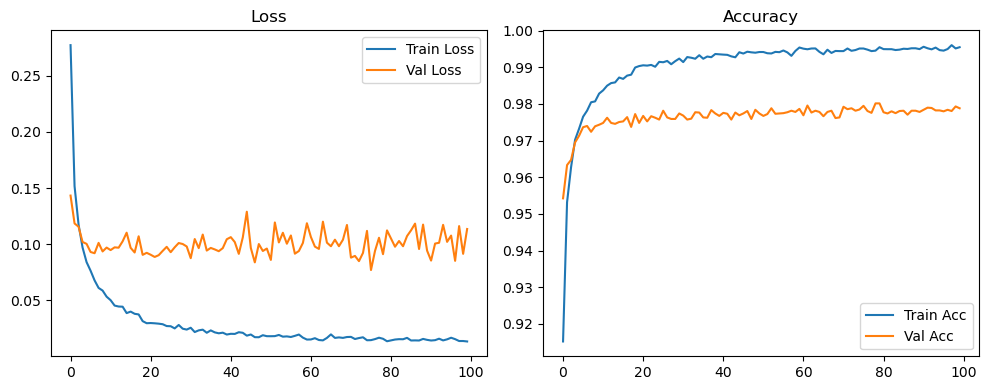

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4270, Acc: 0.8711 | Val Loss: 0.1785, Acc: 0.9457


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2616, Acc: 0.9227 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2233, Acc: 0.9350 | Val Loss: 0.1324, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1961, Acc: 0.9422 | Val Loss: 0.1155, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1799, Acc: 0.9461 | Val Loss: 0.1129, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1664, Acc: 0.9505 | Val Loss: 0.1060, Acc: 0.9685


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1560, Acc: 0.9534 | Val Loss: 0.1044, Acc: 0.9698


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1490, Acc: 0.9565 | Val Loss: 0.1017, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9580 | Val Loss: 0.1049, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1367, Acc: 0.9595 | Val Loss: 0.1011, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9584 | Val Loss: 0.0984, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1249, Acc: 0.9627 | Val Loss: 0.0944, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1252, Acc: 0.9623 | Val Loss: 0.0970, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9650 | Val Loss: 0.0975, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9652 | Val Loss: 0.1076, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9661 | Val Loss: 0.0902, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9663 | Val Loss: 0.0940, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9675 | Val Loss: 0.0908, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9700 | Val Loss: 0.0945, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1017, Acc: 0.9695 | Val Loss: 0.0923, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9706 | Val Loss: 0.0913, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0933, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9702 | Val Loss: 0.0933, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9714 | Val Loss: 0.0910, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9716 | Val Loss: 0.0869, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9705 | Val Loss: 0.0888, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9718 | Val Loss: 0.0982, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9726 | Val Loss: 0.0935, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9729 | Val Loss: 0.0862, Acc: 0.9751


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9738 | Val Loss: 0.0862, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9743 | Val Loss: 0.0916, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9740 | Val Loss: 0.0901, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9732 | Val Loss: 0.0946, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0956, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 0.0952, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9742 | Val Loss: 0.0918, Acc: 0.9760


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9749 | Val Loss: 0.0991, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9754 | Val Loss: 0.0957, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9744 | Val Loss: 0.0975, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9764 | Val Loss: 0.0896, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9761 | Val Loss: 0.0864, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9757 | Val Loss: 0.0952, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9745 | Val Loss: 0.0856, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9747 | Val Loss: 0.0929, Acc: 0.9748


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9739 | Val Loss: 0.0892, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9767 | Val Loss: 0.0916, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9772 | Val Loss: 0.0898, Acc: 0.9756


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9769 | Val Loss: 0.0949, Acc: 0.9762


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9761 | Val Loss: 0.0864, Acc: 0.9773


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9753 | Val Loss: 0.0894, Acc: 0.9758


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9755 | Val Loss: 0.0924, Acc: 0.9760


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9768 | Val Loss: 0.1038, Acc: 0.9759


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0758, Acc: 0.9773 | Val Loss: 0.0879, Acc: 0.9769


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9767 | Val Loss: 0.0911, Acc: 0.9762


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9768 | Val Loss: 0.1065, Acc: 0.9762


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9772 | Val Loss: 0.0969, Acc: 0.9769


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9755 | Val Loss: 0.1095, Acc: 0.9770


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9778 | Val Loss: 0.0969, Acc: 0.9760


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9759 | Val Loss: 0.1094, Acc: 0.9762


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9761 | Val Loss: 0.1002, Acc: 0.9761


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9767 | Val Loss: 0.1051, Acc: 0.9755


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9759 | Val Loss: 0.0943, Acc: 0.9752


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9758 | Val Loss: 0.0959, Acc: 0.9756


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9770 | Val Loss: 0.0972, Acc: 0.9761


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9773 | Val Loss: 0.0900, Acc: 0.9768


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9773 | Val Loss: 0.0895, Acc: 0.9761


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9779 | Val Loss: 0.0990, Acc: 0.9764


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9778 | Val Loss: 0.0860, Acc: 0.9758


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9769 | Val Loss: 0.0927, Acc: 0.9752


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9776 | Val Loss: 0.0925, Acc: 0.9754


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9761 | Val Loss: 0.1010, Acc: 0.9745


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9758 | Val Loss: 0.0972, Acc: 0.9751


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9770 | Val Loss: 0.0939, Acc: 0.9759


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9778 | Val Loss: 0.1006, Acc: 0.9747


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9774 | Val Loss: 0.1165, Acc: 0.9755


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9764 | Val Loss: 0.0920, Acc: 0.9770


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9765 | Val Loss: 0.0910, Acc: 0.9764


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9769 | Val Loss: 0.1087, Acc: 0.9762


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9784 | Val Loss: 0.0929, Acc: 0.9749


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9770 | Val Loss: 0.0965, Acc: 0.9760


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9780 | Val Loss: 0.0802, Acc: 0.9762


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9769 | Val Loss: 0.0930, Acc: 0.9762


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9762 | Val Loss: 0.0929, Acc: 0.9769


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9782 | Val Loss: 0.0836, Acc: 0.9765


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9781 | Val Loss: 0.0848, Acc: 0.9768


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9764 | Val Loss: 0.0945, Acc: 0.9764


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9780 | Val Loss: 0.1060, Acc: 0.9779


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9772 | Val Loss: 0.0860, Acc: 0.9763


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9775 | Val Loss: 0.0854, Acc: 0.9764


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9772 | Val Loss: 0.0960, Acc: 0.9772


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9772 | Val Loss: 0.1115, Acc: 0.9767


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9784 | Val Loss: 0.0925, Acc: 0.9771


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9784 | Val Loss: 0.0966, Acc: 0.9758


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9781 | Val Loss: 0.0910, Acc: 0.9766


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9766 | Val Loss: 0.0983, Acc: 0.9752


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9760 | Val Loss: 0.0949, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0740, Acc: 0.9777 | Val Loss: 0.0989, Acc: 0.9758


Final Test Loss: 0.0872 Accuracy: 0.9777


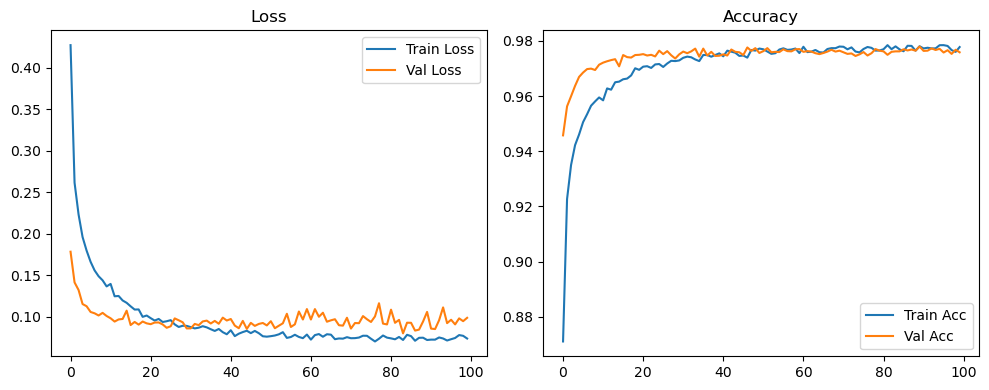

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2299, Acc: 0.9297 | Val Loss: 0.1358, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9649 | Val Loss: 0.1106, Acc: 0.9649


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9755 | Val Loss: 0.1114, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9806 | Val Loss: 0.1062, Acc: 0.9708


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9829 | Val Loss: 0.1099, Acc: 0.9687


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.1062, Acc: 0.9727


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.1078, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0956, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9704


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1183, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1056, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.1227, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1104, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1208, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.1270, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1345, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1191, Acc: 0.9751


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1204, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1118, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1258, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1279, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1079, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1111, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1254, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1218, Acc: 0.9744


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1184, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1178, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1358, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1118, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1215, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1264, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1296, Acc: 0.9734


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1286, Acc: 0.9744


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1157, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1210, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1239, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1164, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1220, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1399, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1103, Acc: 0.9748


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1217, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1483, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1271, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1213, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1203, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1223, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1269, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1277, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1271, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1470, Acc: 0.9786


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1573, Acc: 0.9797


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1720, Acc: 0.9767


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1423, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1411, Acc: 0.9793


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1244, Acc: 0.9781


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1458, Acc: 0.9790


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1471, Acc: 0.9784


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1593, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1034, Acc: 0.9795


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1516, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1405, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1655, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1403, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1491, Acc: 0.9778


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1442, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1647, Acc: 0.9762


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1412, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1409, Acc: 0.9774


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1557, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1471, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1793, Acc: 0.9763


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1544, Acc: 0.9783


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1577, Acc: 0.9789


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1634, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1478, Acc: 0.9770


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1594, Acc: 0.9772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1478, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1504, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1496, Acc: 0.9791


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1645, Acc: 0.9790


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1705, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1783, Acc: 0.9790


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1806, Acc: 0.9791


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1749, Acc: 0.9781


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1737, Acc: 0.9782


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1910, Acc: 0.9776


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1818, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1800, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1860, Acc: 0.9783


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1965, Acc: 0.9771


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1904, Acc: 0.9782


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1873, Acc: 0.9778


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1756, Acc: 0.9780


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1682, Acc: 0.9778


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1788, Acc: 0.9785


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1757, Acc: 0.9786


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1843, Acc: 0.9779


Final Test Loss: 0.1462 Accuracy: 0.9816


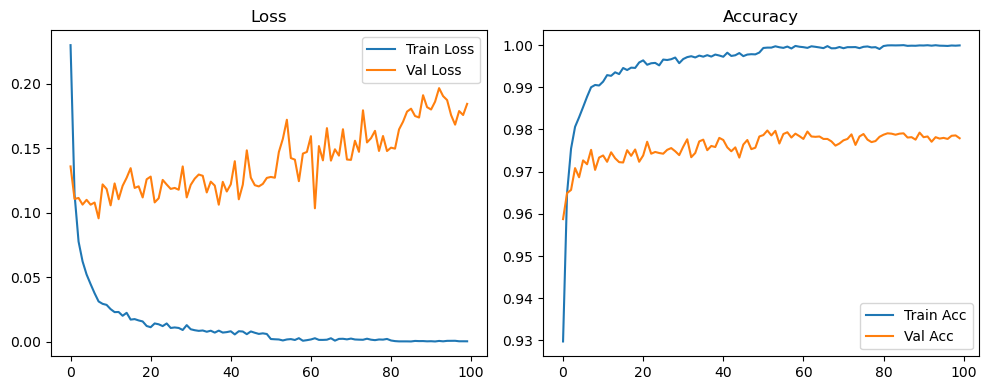

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2773, Acc: 0.9152 | Val Loss: 0.1434, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1517, Acc: 0.9532 | Val Loss: 0.1186, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9627 | Val Loss: 0.1157, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9702 | Val Loss: 0.1021, Acc: 0.9695


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9732 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0932, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.0921, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9805 | Val Loss: 0.1013, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9807 | Val Loss: 0.0937, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9828 | Val Loss: 0.0971, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9837 | Val Loss: 0.0949, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0973, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.1027, Acc: 0.9746


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9872 | Val Loss: 0.1103, Acc: 0.9751


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0969, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0927, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1071, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0924, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0907, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0887, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0903, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.0941, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0977, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.0930, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0973, Acc: 0.9763


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.1011, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0877, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1047, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0966, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1087, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0944, Acc: 0.9777


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0968, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0954, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.0939, Acc: 0.9783


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0966, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1045, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.1064, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1020, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0915, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1062, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1290, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0967, Acc: 0.9774


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0839, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1002, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0941, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0962, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0869, Acc: 0.9782


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1011, Acc: 0.9804


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1018, Acc: 0.9794


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1169, Acc: 0.9789


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0992, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0933, Acc: 0.9796


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9796


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1108, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1054, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0954, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0991, Acc: 0.9797


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0994, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1196, Acc: 0.9805


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1208, Acc: 0.9805


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1171, Acc: 0.9775


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1032, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1230, Acc: 0.9798


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1013, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1051, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1153, Acc: 0.9792


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1255, Acc: 0.9791


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1166, Acc: 0.9790


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0982, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1166, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1207, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1134, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0989, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1258, Acc: 0.9789


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1008, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1280, Acc: 0.9787


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1077, Acc: 0.9803


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9798


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1219, Acc: 0.9798


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1054, Acc: 0.9802


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1035, Acc: 0.9797


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1134, Acc: 0.9809


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1134, Acc: 0.9811


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1116, Acc: 0.9801


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1165, Acc: 0.9797


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1208, Acc: 0.9803


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1261, Acc: 0.9797


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1059, Acc: 0.9799


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1126, Acc: 0.9802


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1197, Acc: 0.9799


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1224, Acc: 0.9800


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1096, Acc: 0.9801


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1063, Acc: 0.9802


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1032, Acc: 0.9796


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1242, Acc: 0.9803


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1070, Acc: 0.9804


Final Test Loss: 0.1096 Accuracy: 0.9811


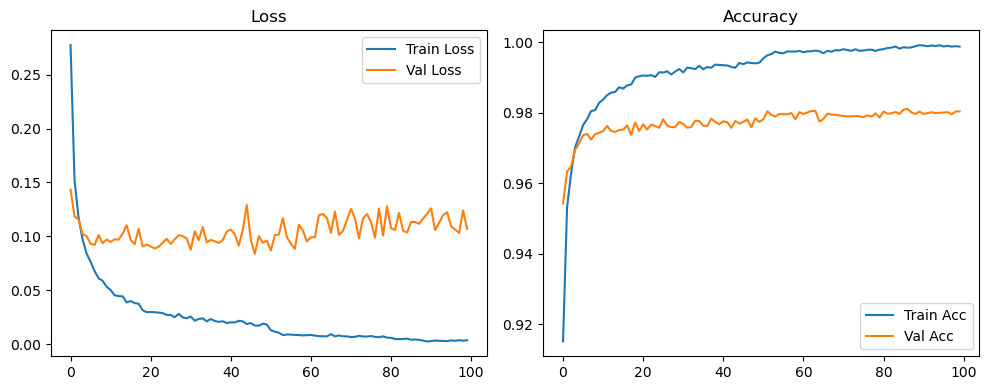

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4270, Acc: 0.8711 | Val Loss: 0.1785, Acc: 0.9457


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2616, Acc: 0.9227 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2233, Acc: 0.9350 | Val Loss: 0.1324, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1961, Acc: 0.9422 | Val Loss: 0.1155, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1799, Acc: 0.9461 | Val Loss: 0.1129, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1664, Acc: 0.9505 | Val Loss: 0.1060, Acc: 0.9685


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1560, Acc: 0.9534 | Val Loss: 0.1044, Acc: 0.9698


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1490, Acc: 0.9565 | Val Loss: 0.1017, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9580 | Val Loss: 0.1049, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1367, Acc: 0.9595 | Val Loss: 0.1011, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9584 | Val Loss: 0.0984, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1249, Acc: 0.9627 | Val Loss: 0.0944, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1252, Acc: 0.9623 | Val Loss: 0.0970, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9650 | Val Loss: 0.0975, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9652 | Val Loss: 0.1076, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9661 | Val Loss: 0.0902, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9663 | Val Loss: 0.0940, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9675 | Val Loss: 0.0908, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9700 | Val Loss: 0.0945, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1017, Acc: 0.9695 | Val Loss: 0.0923, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9706 | Val Loss: 0.0913, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0933, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9702 | Val Loss: 0.0933, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9714 | Val Loss: 0.0910, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9716 | Val Loss: 0.0869, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9705 | Val Loss: 0.0888, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9718 | Val Loss: 0.0982, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9726 | Val Loss: 0.0935, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9729 | Val Loss: 0.0862, Acc: 0.9751


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9738 | Val Loss: 0.0862, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9743 | Val Loss: 0.0916, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9740 | Val Loss: 0.0901, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9732 | Val Loss: 0.0946, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0956, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 0.0952, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9742 | Val Loss: 0.0918, Acc: 0.9760


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9749 | Val Loss: 0.0991, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9754 | Val Loss: 0.0957, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9744 | Val Loss: 0.0975, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9764 | Val Loss: 0.0896, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9761 | Val Loss: 0.0864, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9757 | Val Loss: 0.0952, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9745 | Val Loss: 0.0856, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9747 | Val Loss: 0.0929, Acc: 0.9748


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9739 | Val Loss: 0.0892, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9767 | Val Loss: 0.0916, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9772 | Val Loss: 0.0898, Acc: 0.9756


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9796 | Val Loss: 0.0931, Acc: 0.9767


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9805 | Val Loss: 0.0957, Acc: 0.9771


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9810 | Val Loss: 0.0904, Acc: 0.9775


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9809 | Val Loss: 0.0952, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9829 | Val Loss: 0.0956, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9834 | Val Loss: 0.0869, Acc: 0.9770


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9833 | Val Loss: 0.0863, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9838 | Val Loss: 0.0983, Acc: 0.9774


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 0.1049, Acc: 0.9759


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9839 | Val Loss: 0.0991, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9845 | Val Loss: 0.0952, Acc: 0.9770


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.1076, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9847 | Val Loss: 0.0874, Acc: 0.9779


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9846 | Val Loss: 0.1013, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9842 | Val Loss: 0.0979, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9834 | Val Loss: 0.0952, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9854 | Val Loss: 0.0959, Acc: 0.9786


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9850 | Val Loss: 0.0941, Acc: 0.9783


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9846 | Val Loss: 0.0943, Acc: 0.9780


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 0.0920, Acc: 0.9780


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9862 | Val Loss: 0.1007, Acc: 0.9787


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9849 | Val Loss: 0.0955, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9850 | Val Loss: 0.0961, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.1017, Acc: 0.9784


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9852 | Val Loss: 0.0940, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9865 | Val Loss: 0.0903, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9858 | Val Loss: 0.1059, Acc: 0.9769


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.1004, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.1001, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9860 | Val Loss: 0.0903, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.1036, Acc: 0.9775


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9879 | Val Loss: 0.0917, Acc: 0.9773


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.0943, Acc: 0.9775


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9896 | Val Loss: 0.0992, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9880 | Val Loss: 0.1037, Acc: 0.9778


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.1010, Acc: 0.9785


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9885 | Val Loss: 0.0976, Acc: 0.9787


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9888 | Val Loss: 0.0960, Acc: 0.9781


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.1050, Acc: 0.9784


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0977, Acc: 0.9790


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9900 | Val Loss: 0.0955, Acc: 0.9777


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9911 | Val Loss: 0.1008, Acc: 0.9780


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.0997, Acc: 0.9778


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9903 | Val Loss: 0.1069, Acc: 0.9786


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.0923, Acc: 0.9777


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9901 | Val Loss: 0.1032, Acc: 0.9779


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9907 | Val Loss: 0.0961, Acc: 0.9781


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9905 | Val Loss: 0.0989, Acc: 0.9784


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9897 | Val Loss: 0.1030, Acc: 0.9779


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9899 | Val Loss: 0.0930, Acc: 0.9779


Final Test Loss: 0.0831 Accuracy: 0.9793


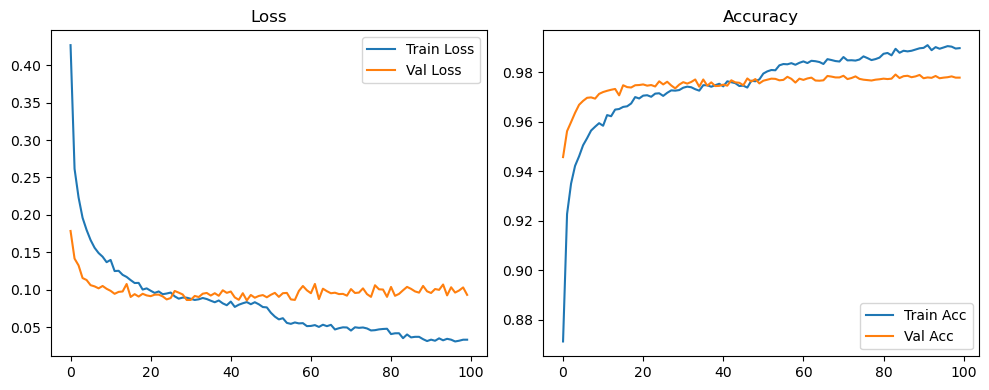

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2299, Acc: 0.9297 | Val Loss: 0.1358, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9649 | Val Loss: 0.1106, Acc: 0.9649


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9755 | Val Loss: 0.1114, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9806 | Val Loss: 0.1062, Acc: 0.9708


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9829 | Val Loss: 0.1099, Acc: 0.9687


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.1062, Acc: 0.9727


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.1078, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0956, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9704


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1183, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1056, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.1227, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1104, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1208, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.1270, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1345, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1191, Acc: 0.9751


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1204, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1118, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1258, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1279, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1079, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1111, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1254, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1218, Acc: 0.9744


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1184, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1178, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1358, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1118, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1215, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1264, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1296, Acc: 0.9734


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1286, Acc: 0.9744


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1157, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1210, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1239, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1164, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1220, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1399, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1103, Acc: 0.9748


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1217, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1483, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1271, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1213, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1203, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1223, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1269, Acc: 0.9783


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1277, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1271, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1470, Acc: 0.9786


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1573, Acc: 0.9797


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1720, Acc: 0.9767


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1423, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1411, Acc: 0.9793


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1244, Acc: 0.9781


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1458, Acc: 0.9790


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1471, Acc: 0.9784


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1593, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1034, Acc: 0.9795


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1516, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1405, Acc: 0.9782


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1655, Acc: 0.9783


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1403, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1491, Acc: 0.9778


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1442, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1647, Acc: 0.9762


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1412, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1409, Acc: 0.9774


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1557, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1471, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1793, Acc: 0.9763


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1544, Acc: 0.9783


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1577, Acc: 0.9789


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1634, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1478, Acc: 0.9770


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1594, Acc: 0.9772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1478, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1463, Acc: 0.9793


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1469, Acc: 0.9791


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1544, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1569, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1639, Acc: 0.9785


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1650, Acc: 0.9790


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1640, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1676, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1714, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1715, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1760, Acc: 0.9784


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1758, Acc: 0.9784


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1753, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1745, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1787, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1745, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1807, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1863, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1835, Acc: 0.9793


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1870, Acc: 0.9790


Final Test Loss: 0.1466 Accuracy: 0.9822


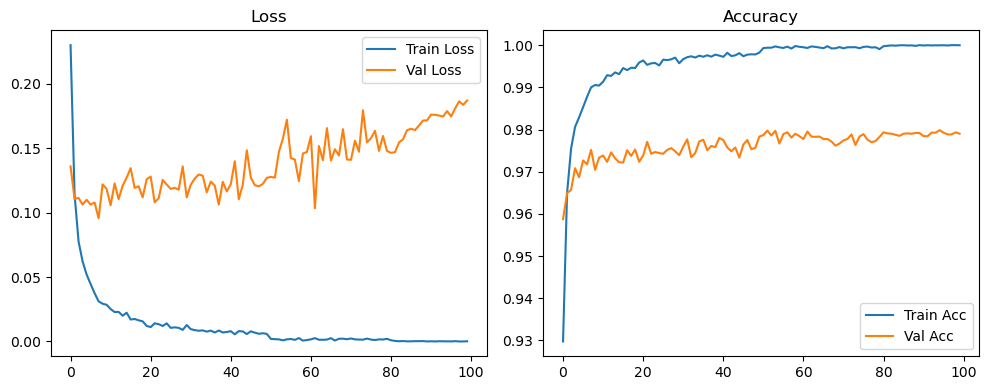

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2773, Acc: 0.9152 | Val Loss: 0.1434, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1517, Acc: 0.9532 | Val Loss: 0.1186, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9627 | Val Loss: 0.1157, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9702 | Val Loss: 0.1021, Acc: 0.9695


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9732 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0932, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.0921, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9805 | Val Loss: 0.1013, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9807 | Val Loss: 0.0937, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9828 | Val Loss: 0.0971, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9837 | Val Loss: 0.0949, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0973, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.1027, Acc: 0.9746


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9872 | Val Loss: 0.1103, Acc: 0.9751


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0969, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0927, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1071, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0924, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0907, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0887, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0903, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.0941, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0977, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.0930, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0973, Acc: 0.9763


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.1011, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0877, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1047, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0966, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1087, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0944, Acc: 0.9777


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0968, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0954, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.0939, Acc: 0.9783


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0966, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1045, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.1064, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1020, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0915, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1062, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1290, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0967, Acc: 0.9774


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0839, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1002, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0941, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0962, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0869, Acc: 0.9782


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1011, Acc: 0.9804


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1018, Acc: 0.9794


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1169, Acc: 0.9789


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0992, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0933, Acc: 0.9796


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9796


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1108, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1054, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0954, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0991, Acc: 0.9797


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0994, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1196, Acc: 0.9805


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1208, Acc: 0.9805


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1171, Acc: 0.9775


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1032, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1230, Acc: 0.9798


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1013, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1051, Acc: 0.9794


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1153, Acc: 0.9792


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1255, Acc: 0.9791


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1166, Acc: 0.9790


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0982, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.1166, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1207, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1134, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0989, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1258, Acc: 0.9789


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1008, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1280, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1114, Acc: 0.9805


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1086, Acc: 0.9800


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1147, Acc: 0.9801


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1037, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1057, Acc: 0.9798


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1141, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1194, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1118, Acc: 0.9805


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1122, Acc: 0.9800


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1218, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1280, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1103, Acc: 0.9807


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1157, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1135, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1193, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1163, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1189, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1150, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1150, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1169, Acc: 0.9806


Final Test Loss: 0.1221 Accuracy: 0.9815


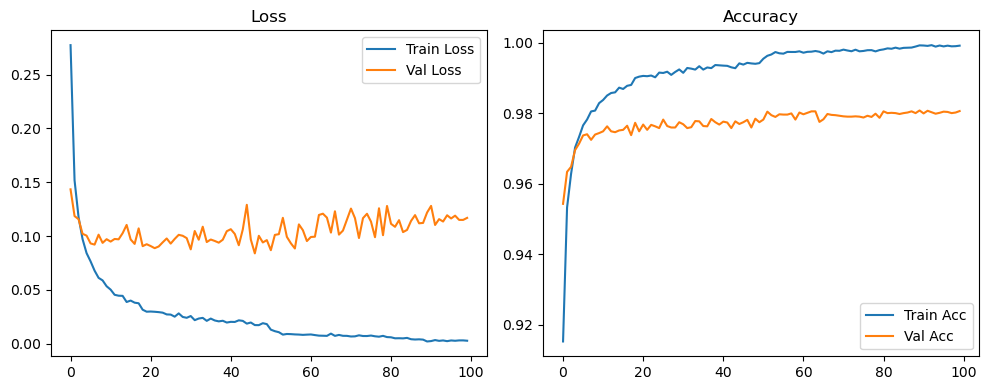

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4270, Acc: 0.8711 | Val Loss: 0.1785, Acc: 0.9457


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2616, Acc: 0.9227 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2233, Acc: 0.9350 | Val Loss: 0.1324, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1961, Acc: 0.9422 | Val Loss: 0.1155, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1799, Acc: 0.9461 | Val Loss: 0.1129, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1664, Acc: 0.9505 | Val Loss: 0.1060, Acc: 0.9685


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1560, Acc: 0.9534 | Val Loss: 0.1044, Acc: 0.9698


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1490, Acc: 0.9565 | Val Loss: 0.1017, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9580 | Val Loss: 0.1049, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1367, Acc: 0.9595 | Val Loss: 0.1011, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9584 | Val Loss: 0.0984, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1249, Acc: 0.9627 | Val Loss: 0.0944, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1252, Acc: 0.9623 | Val Loss: 0.0970, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9650 | Val Loss: 0.0975, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9652 | Val Loss: 0.1076, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9661 | Val Loss: 0.0902, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9663 | Val Loss: 0.0940, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9675 | Val Loss: 0.0908, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9700 | Val Loss: 0.0945, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1017, Acc: 0.9695 | Val Loss: 0.0923, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9706 | Val Loss: 0.0913, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0933, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9702 | Val Loss: 0.0933, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9714 | Val Loss: 0.0910, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9716 | Val Loss: 0.0869, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9705 | Val Loss: 0.0888, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9718 | Val Loss: 0.0982, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9726 | Val Loss: 0.0935, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9729 | Val Loss: 0.0862, Acc: 0.9751


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9738 | Val Loss: 0.0862, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9743 | Val Loss: 0.0916, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9740 | Val Loss: 0.0901, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9732 | Val Loss: 0.0946, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0956, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 0.0952, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9742 | Val Loss: 0.0918, Acc: 0.9760


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9749 | Val Loss: 0.0991, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9754 | Val Loss: 0.0957, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9744 | Val Loss: 0.0975, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9764 | Val Loss: 0.0896, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9761 | Val Loss: 0.0864, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9757 | Val Loss: 0.0952, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9745 | Val Loss: 0.0856, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9747 | Val Loss: 0.0929, Acc: 0.9748


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9739 | Val Loss: 0.0892, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9767 | Val Loss: 0.0916, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9772 | Val Loss: 0.0898, Acc: 0.9756


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0692, Acc: 0.9796 | Val Loss: 0.0931, Acc: 0.9767


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9805 | Val Loss: 0.0957, Acc: 0.9771


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9810 | Val Loss: 0.0904, Acc: 0.9775


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9809 | Val Loss: 0.0952, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9829 | Val Loss: 0.0956, Acc: 0.9768


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9834 | Val Loss: 0.0869, Acc: 0.9770


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9833 | Val Loss: 0.0863, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9838 | Val Loss: 0.0983, Acc: 0.9774


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9831 | Val Loss: 0.1049, Acc: 0.9759


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9839 | Val Loss: 0.0991, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9845 | Val Loss: 0.0952, Acc: 0.9770


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.1076, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9847 | Val Loss: 0.0874, Acc: 0.9779


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9846 | Val Loss: 0.1013, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9842 | Val Loss: 0.0979, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9834 | Val Loss: 0.0952, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9854 | Val Loss: 0.0959, Acc: 0.9786


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9850 | Val Loss: 0.0941, Acc: 0.9783


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9846 | Val Loss: 0.0943, Acc: 0.9780


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 0.0920, Acc: 0.9780


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9862 | Val Loss: 0.1007, Acc: 0.9787


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9849 | Val Loss: 0.0955, Acc: 0.9773


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9850 | Val Loss: 0.0961, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9848 | Val Loss: 0.1017, Acc: 0.9784


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9852 | Val Loss: 0.0940, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9865 | Val Loss: 0.0903, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9858 | Val Loss: 0.1059, Acc: 0.9769


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.1004, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9854 | Val Loss: 0.1001, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9860 | Val Loss: 0.0903, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9880 | Val Loss: 0.1005, Acc: 0.9772


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9879 | Val Loss: 0.0958, Acc: 0.9770


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9872 | Val Loss: 0.0955, Acc: 0.9769


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.0961, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9879 | Val Loss: 0.1011, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.0963, Acc: 0.9783


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.0965, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9895 | Val Loss: 0.0967, Acc: 0.9784


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.1017, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9903 | Val Loss: 0.0980, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9901 | Val Loss: 0.0991, Acc: 0.9775


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9904 | Val Loss: 0.0977, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9892 | Val Loss: 0.0990, Acc: 0.9786


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9905 | Val Loss: 0.1001, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9896 | Val Loss: 0.0961, Acc: 0.9775


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9900 | Val Loss: 0.0977, Acc: 0.9776


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9907 | Val Loss: 0.0917, Acc: 0.9783


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0944, Acc: 0.9786


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9904 | Val Loss: 0.0968, Acc: 0.9781


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9902 | Val Loss: 0.0932, Acc: 0.9788


Final Test Loss: 0.0848 Accuracy: 0.9801


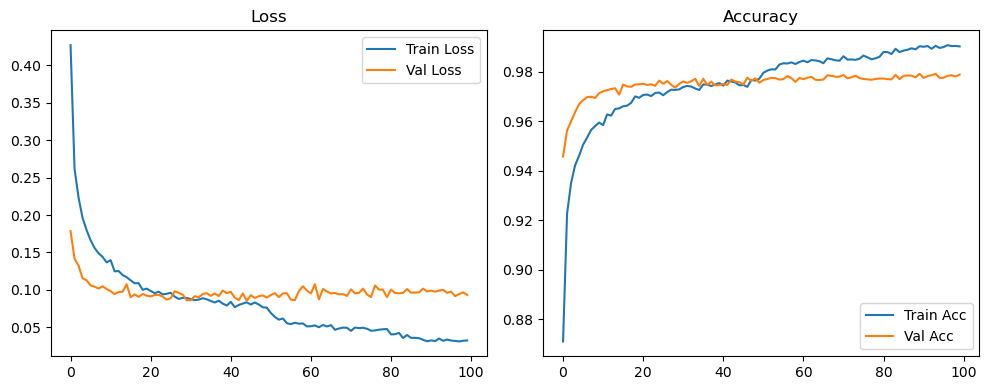

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2299, Acc: 0.9297 | Val Loss: 0.1358, Acc: 0.9587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9649 | Val Loss: 0.1106, Acc: 0.9649


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9755 | Val Loss: 0.1114, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9806 | Val Loss: 0.1062, Acc: 0.9708


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9829 | Val Loss: 0.1099, Acc: 0.9687


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.1062, Acc: 0.9727


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.1078, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0956, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9704


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1183, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1056, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.1227, Acc: 0.9723


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.1104, Acc: 0.9746


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1208, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.1270, Acc: 0.9722


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1345, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.1191, Acc: 0.9751


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1204, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1118, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1258, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1279, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1079, Acc: 0.9771


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1111, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1254, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1218, Acc: 0.9744


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1184, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1178, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1358, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1118, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1215, Acc: 0.9759


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1264, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1296, Acc: 0.9734


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1286, Acc: 0.9744


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1157, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1210, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1239, Acc: 0.9758


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1164, Acc: 0.9780


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1220, Acc: 0.9775


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1399, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1103, Acc: 0.9748


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1217, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1483, Acc: 0.9733


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1271, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1213, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1203, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1223, Acc: 0.9757


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1269, Acc: 0.9783


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1172, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1253, Acc: 0.9804


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1312, Acc: 0.9803


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1382, Acc: 0.9806


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1374, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1381, Acc: 0.9818


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1446, Acc: 0.9814


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1497, Acc: 0.9800


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1519, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1483, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1394, Acc: 0.9818


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1376, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1451, Acc: 0.9809


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1507, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1546, Acc: 0.9802


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1500, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1601, Acc: 0.9804


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1592, Acc: 0.9803


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1641, Acc: 0.9799


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1664, Acc: 0.9803


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1627, Acc: 0.9801


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1687, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1705, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1698, Acc: 0.9787


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1697, Acc: 0.9796


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1792, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1753, Acc: 0.9795


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1724, Acc: 0.9797


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1721, Acc: 0.9794


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1736, Acc: 0.9799


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1700, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1707, Acc: 0.9800


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1734, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1706, Acc: 0.9803


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1758, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1734, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1732, Acc: 0.9814


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1777, Acc: 0.9806


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1727, Acc: 0.9807


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1718, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1765, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1771, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1826, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1839, Acc: 0.9803


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1856, Acc: 0.9804


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1851, Acc: 0.9807


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1882, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1868, Acc: 0.9806


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1804, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1832, Acc: 0.9808


Final Test Loss: 0.1602 Accuracy: 0.9810


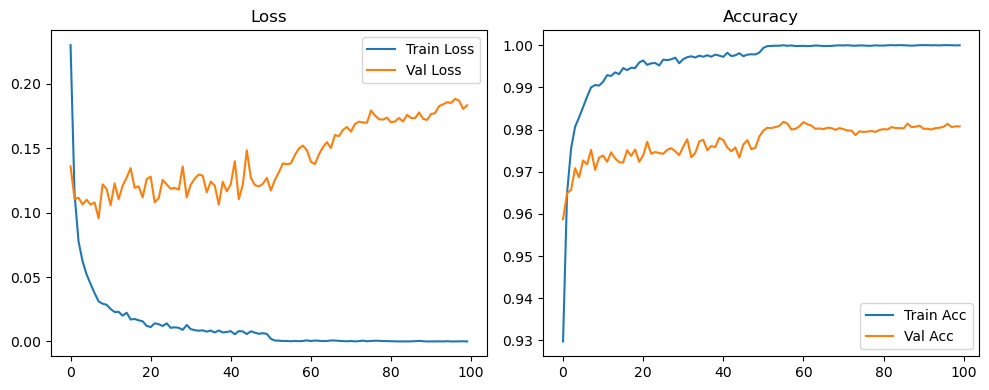

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2773, Acc: 0.9152 | Val Loss: 0.1434, Acc: 0.9543


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1517, Acc: 0.9532 | Val Loss: 0.1186, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9627 | Val Loss: 0.1157, Acc: 0.9647


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9702 | Val Loss: 0.1021, Acc: 0.9695


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9732 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0932, Acc: 0.9737


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.0921, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9805 | Val Loss: 0.1013, Acc: 0.9724


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9807 | Val Loss: 0.0937, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9828 | Val Loss: 0.0971, Acc: 0.9743


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9837 | Val Loss: 0.0949, Acc: 0.9748


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0973, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.1027, Acc: 0.9746


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9872 | Val Loss: 0.1103, Acc: 0.9751


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0969, Acc: 0.9752


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0927, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1071, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0906, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0924, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0907, Acc: 0.9768


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0887, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0903, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.0941, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0977, Acc: 0.9758


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.0930, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0973, Acc: 0.9763


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.1011, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9759


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0981, Acc: 0.9774


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0877, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1047, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0966, Acc: 0.9760


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1087, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0944, Acc: 0.9777


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0968, Acc: 0.9763


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0954, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.0939, Acc: 0.9783


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0966, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1045, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.1064, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1020, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0915, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1062, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1290, Acc: 0.9769


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0967, Acc: 0.9774


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0839, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1002, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0941, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0962, Acc: 0.9774


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0996, Acc: 0.9791


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0961, Acc: 0.9805


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1023, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1100, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9971 | Val Loss: 0.0973, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1080, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0941, Acc: 0.9810


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1065, Acc: 0.9804


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1125, Acc: 0.9804


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1047, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1061, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1068, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1104, Acc: 0.9816


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1146, Acc: 0.9817


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1067, Acc: 0.9803


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1013, Acc: 0.9800


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1177, Acc: 0.9806


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1019, Acc: 0.9809


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1028, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1145, Acc: 0.9802


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1222, Acc: 0.9812


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1044, Acc: 0.9813


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1028, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1157, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1194, Acc: 0.9806


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1141, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1179, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1220, Acc: 0.9798


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1053, Acc: 0.9811


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1188, Acc: 0.9805


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1129, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1123, Acc: 0.9816


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1173, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1124, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1090, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1250, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.1228, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1161, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1228, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1133, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1183, Acc: 0.9816


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1172, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1203, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1217, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1229, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1177, Acc: 0.9816


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1097, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1113, Acc: 0.9819


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1155, Acc: 0.9816


Final Test Loss: 0.1118 Accuracy: 0.9814


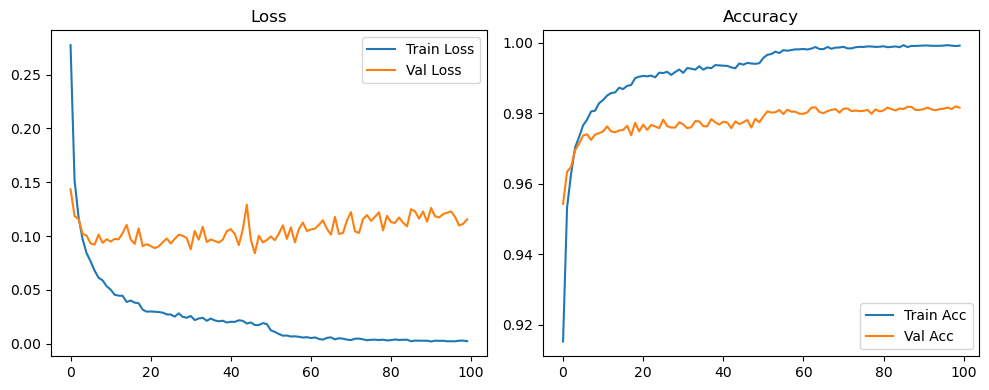

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4270, Acc: 0.8711 | Val Loss: 0.1785, Acc: 0.9457


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2616, Acc: 0.9227 | Val Loss: 0.1415, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2233, Acc: 0.9350 | Val Loss: 0.1324, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1961, Acc: 0.9422 | Val Loss: 0.1155, Acc: 0.9637


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1799, Acc: 0.9461 | Val Loss: 0.1129, Acc: 0.9669


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1664, Acc: 0.9505 | Val Loss: 0.1060, Acc: 0.9685


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1560, Acc: 0.9534 | Val Loss: 0.1044, Acc: 0.9698


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1490, Acc: 0.9565 | Val Loss: 0.1017, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1441, Acc: 0.9580 | Val Loss: 0.1049, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1367, Acc: 0.9595 | Val Loss: 0.1011, Acc: 0.9713


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1398, Acc: 0.9584 | Val Loss: 0.0984, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1249, Acc: 0.9627 | Val Loss: 0.0944, Acc: 0.9726


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1252, Acc: 0.9623 | Val Loss: 0.0970, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9650 | Val Loss: 0.0975, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9652 | Val Loss: 0.1076, Acc: 0.9708


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1128, Acc: 0.9661 | Val Loss: 0.0902, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1089, Acc: 0.9663 | Val Loss: 0.0940, Acc: 0.9741


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1090, Acc: 0.9675 | Val Loss: 0.0908, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9700 | Val Loss: 0.0945, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1017, Acc: 0.9695 | Val Loss: 0.0923, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0985, Acc: 0.9706 | Val Loss: 0.0913, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0956, Acc: 0.9708 | Val Loss: 0.0933, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9702 | Val Loss: 0.0933, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9714 | Val Loss: 0.0910, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9716 | Val Loss: 0.0869, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0961, Acc: 0.9705 | Val Loss: 0.0888, Acc: 0.9752


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0910, Acc: 0.9718 | Val Loss: 0.0982, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9726 | Val Loss: 0.0935, Acc: 0.9736


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9729 | Val Loss: 0.0862, Acc: 0.9751


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0878, Acc: 0.9738 | Val Loss: 0.0862, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9743 | Val Loss: 0.0916, Acc: 0.9755


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9740 | Val Loss: 0.0901, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9732 | Val Loss: 0.0946, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.0956, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9772


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 0.0952, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9742 | Val Loss: 0.0918, Acc: 0.9760


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9749 | Val Loss: 0.0991, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9754 | Val Loss: 0.0957, Acc: 0.9746


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9744 | Val Loss: 0.0975, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9764 | Val Loss: 0.0896, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0798, Acc: 0.9761 | Val Loss: 0.0864, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9757 | Val Loss: 0.0952, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9745 | Val Loss: 0.0856, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9747 | Val Loss: 0.0929, Acc: 0.9748


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9739 | Val Loss: 0.0892, Acc: 0.9776


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9767 | Val Loss: 0.0916, Acc: 0.9763


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0767, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9772 | Val Loss: 0.0898, Acc: 0.9756


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9790 | Val Loss: 0.0929, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0884, Acc: 0.9772


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9819 | Val Loss: 0.0929, Acc: 0.9768


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9819 | Val Loss: 0.0965, Acc: 0.9776


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9839 | Val Loss: 0.0932, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9839 | Val Loss: 0.0840, Acc: 0.9789


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9847 | Val Loss: 0.0883, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9847 | Val Loss: 0.0917, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9842 | Val Loss: 0.0904, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9858 | Val Loss: 0.0906, Acc: 0.9790


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9863 | Val Loss: 0.0931, Acc: 0.9786


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9853 | Val Loss: 0.0976, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.0913, Acc: 0.9784


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9862 | Val Loss: 0.0953, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9857 | Val Loss: 0.0888, Acc: 0.9784


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9865 | Val Loss: 0.1001, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9882 | Val Loss: 0.0977, Acc: 0.9786


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0902, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9872 | Val Loss: 0.0947, Acc: 0.9781


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.0906, Acc: 0.9785


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9880 | Val Loss: 0.0920, Acc: 0.9799


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9877 | Val Loss: 0.0985, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0942, Acc: 0.9784


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 0.1023, Acc: 0.9787


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.0960, Acc: 0.9791


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9887 | Val Loss: 0.0992, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9881 | Val Loss: 0.1012, Acc: 0.9789


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.1001, Acc: 0.9791


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9887 | Val Loss: 0.0996, Acc: 0.9792


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9891 | Val Loss: 0.0955, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9890 | Val Loss: 0.1011, Acc: 0.9790


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.1000, Acc: 0.9781


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9888 | Val Loss: 0.1012, Acc: 0.9783


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9896 | Val Loss: 0.0971, Acc: 0.9791


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9891 | Val Loss: 0.1004, Acc: 0.9786


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0963, Acc: 0.9789


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0989, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9893 | Val Loss: 0.0959, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9899 | Val Loss: 0.0969, Acc: 0.9790


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9907 | Val Loss: 0.0979, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9905 | Val Loss: 0.0932, Acc: 0.9791


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.1010, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.0956, Acc: 0.9797


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.0982, Acc: 0.9793


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.0977, Acc: 0.9795


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9903 | Val Loss: 0.0969, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9914 | Val Loss: 0.0947, Acc: 0.9790


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.0948, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.0967, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9906 | Val Loss: 0.0955, Acc: 0.9792


Final Test Loss: 0.0875 Accuracy: 0.9796


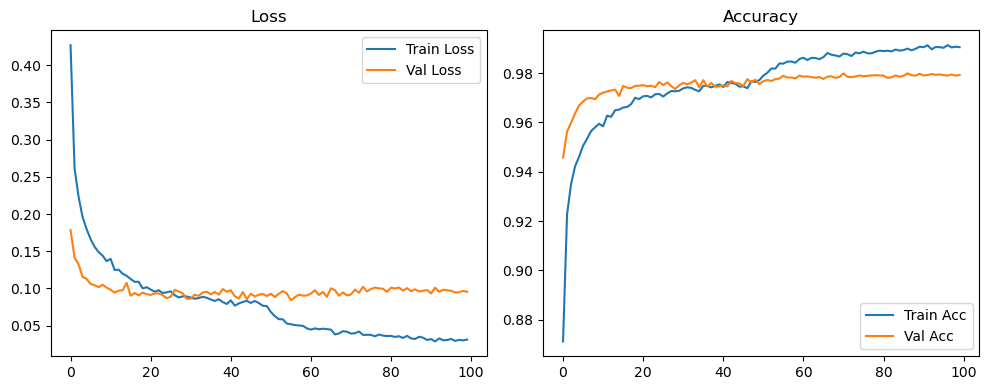

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2183, Acc: 0.9327 | Val Loss: 0.1227, Acc: 0.9628


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1062, Acc: 0.9661 | Val Loss: 0.1111, Acc: 0.9645


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9776 | Val Loss: 0.1127, Acc: 0.9660


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9821 | Val Loss: 0.1036, Acc: 0.9698


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9848 | Val Loss: 0.1075, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9878 | Val Loss: 0.1120, Acc: 0.9705


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9885 | Val Loss: 0.1072, Acc: 0.9728


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.1046, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1122, Acc: 0.9720


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9917 | Val Loss: 0.1182, Acc: 0.9732


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.1207, Acc: 0.9725


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.1107, Acc: 0.9737


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1096, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1140, Acc: 0.9750


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.1120, Acc: 0.9742


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1226, Acc: 0.9723


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1153, Acc: 0.9757


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1139, Acc: 0.9733


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1228, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1164, Acc: 0.9761


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1227, Acc: 0.9750


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1143, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1278, Acc: 0.9754


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9956 | Val Loss: 0.1127, Acc: 0.9762


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1237, Acc: 0.9761


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1412, Acc: 0.9724


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1354, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1408, Acc: 0.9722


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1232, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1360, Acc: 0.9748


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1493, Acc: 0.9732


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1201, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1234, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1252, Acc: 0.9761


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1252, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1254, Acc: 0.9760


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1278, Acc: 0.9765


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1331, Acc: 0.9762


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.1439, Acc: 0.9768


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9970 | Val Loss: 0.1277, Acc: 0.9758


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1130, Acc: 0.9768


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1245, Acc: 0.9785


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1338, Acc: 0.9767


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1529, Acc: 0.9742


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1316, Acc: 0.9776


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1421, Acc: 0.9762


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1468, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1334, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1467, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1465, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1334, Acc: 0.9771


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1307, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1263, Acc: 0.9769


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1401, Acc: 0.9763


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1349, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1380, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1326, Acc: 0.9779


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1368, Acc: 0.9769


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1420, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1373, Acc: 0.9770


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1306, Acc: 0.9763


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1304, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1432, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1304, Acc: 0.9780


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1390, Acc: 0.9770


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1357, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1433, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1362, Acc: 0.9764


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1381, Acc: 0.9782


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1306, Acc: 0.9787


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1451, Acc: 0.9769


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1276, Acc: 0.9764


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1241, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1377, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1400, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1507, Acc: 0.9765


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1305, Acc: 0.9785


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1251, Acc: 0.9785


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1246, Acc: 0.9793


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1317, Acc: 0.9785


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1517, Acc: 0.9765


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1268, Acc: 0.9776


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1375, Acc: 0.9783


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1302, Acc: 0.9772


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1379, Acc: 0.9758


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1460, Acc: 0.9769


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1601, Acc: 0.9767


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1347, Acc: 0.9783


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1338, Acc: 0.9794


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1408, Acc: 0.9759


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1274, Acc: 0.9782


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1293, Acc: 0.9772


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1230, Acc: 0.9786


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1378, Acc: 0.9777


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1460, Acc: 0.9758


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1327, Acc: 0.9794


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1471, Acc: 0.9773


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1320, Acc: 0.9785


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1448, Acc: 0.9778


Final Test Loss: 0.1373 Accuracy: 0.9798


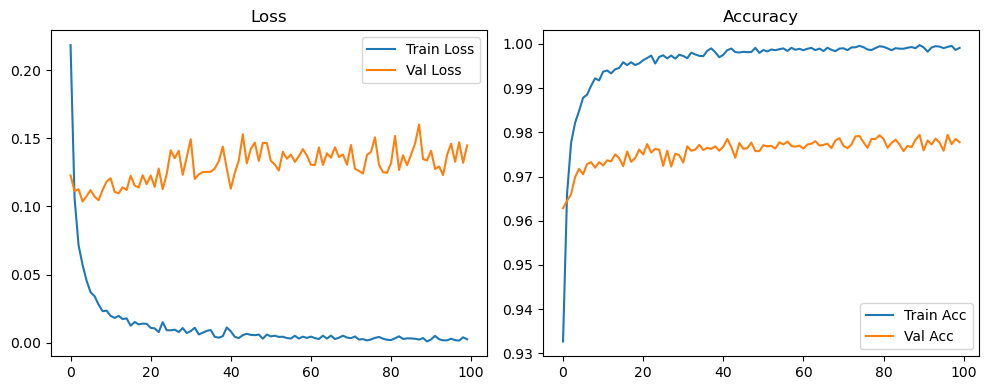

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2673, Acc: 0.9178 | Val Loss: 0.1316, Acc: 0.9597


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1450, Acc: 0.9559 | Val Loss: 0.1116, Acc: 0.9646


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1090, Acc: 0.9658 | Val Loss: 0.1122, Acc: 0.9650


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0903, Acc: 0.9725 | Val Loss: 0.0950, Acc: 0.9722


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9753 | Val Loss: 0.0991, Acc: 0.9715


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9780 | Val Loss: 0.0995, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9802 | Val Loss: 0.0963, Acc: 0.9719


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9828 | Val Loss: 0.0894, Acc: 0.9742


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.0983, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9840 | Val Loss: 0.0977, Acc: 0.9732


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.1002, Acc: 0.9752


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.1008, Acc: 0.9739


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0948, Acc: 0.9768


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.0949, Acc: 0.9759


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.0952, Acc: 0.9744


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0973, Acc: 0.9755


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0968, Acc: 0.9770


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.0964, Acc: 0.9768


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.0955, Acc: 0.9773


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.0980, Acc: 0.9774


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0909, Acc: 0.9778


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.0930, Acc: 0.9769


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.0949, Acc: 0.9768


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1081, Acc: 0.9741


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0928, Acc: 0.9775


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0933, Acc: 0.9771


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0983, Acc: 0.9773


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0921, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0981, Acc: 0.9775


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.0923, Acc: 0.9796


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0990, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1006, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0994, Acc: 0.9769


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0967, Acc: 0.9795


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9941 | Val Loss: 0.1032, Acc: 0.9787


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1015, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1039, Acc: 0.9794


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0978, Acc: 0.9781


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.1159, Acc: 0.9765


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0957, Acc: 0.9802


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0974, Acc: 0.9791


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.1042, Acc: 0.9790


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1063, Acc: 0.9788


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1024, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1004, Acc: 0.9799


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1023, Acc: 0.9796


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1045, Acc: 0.9793


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1047, Acc: 0.9787


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1007, Acc: 0.9789


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0975, Acc: 0.9787


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1002, Acc: 0.9779


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1128, Acc: 0.9776


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.1045, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1074, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1194, Acc: 0.9789


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1112, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1115, Acc: 0.9771


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1000, Acc: 0.9789


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1091, Acc: 0.9779


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1140, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1120, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1130, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1123, Acc: 0.9788


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1024, Acc: 0.9795


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1190, Acc: 0.9782


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1084, Acc: 0.9789


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1023, Acc: 0.9798


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1016, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1103, Acc: 0.9788


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1112, Acc: 0.9789


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1165, Acc: 0.9784


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1074, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1148, Acc: 0.9789


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1179, Acc: 0.9784


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1007, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1144, Acc: 0.9779


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1208, Acc: 0.9806


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1151, Acc: 0.9796


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1034, Acc: 0.9807


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9814


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1182, Acc: 0.9800


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1196, Acc: 0.9788


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1174, Acc: 0.9795


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1247, Acc: 0.9786


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1192, Acc: 0.9793


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1171, Acc: 0.9791


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1276, Acc: 0.9779


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1096, Acc: 0.9798


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1172, Acc: 0.9801


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1230, Acc: 0.9791


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1197, Acc: 0.9782


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1174, Acc: 0.9783


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1125, Acc: 0.9792


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1152, Acc: 0.9802


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1180, Acc: 0.9799


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1148, Acc: 0.9790


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1266, Acc: 0.9789


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1212, Acc: 0.9798


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1193, Acc: 0.9808


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1054, Acc: 0.9798


Final Test Loss: 0.1016 Accuracy: 0.9802


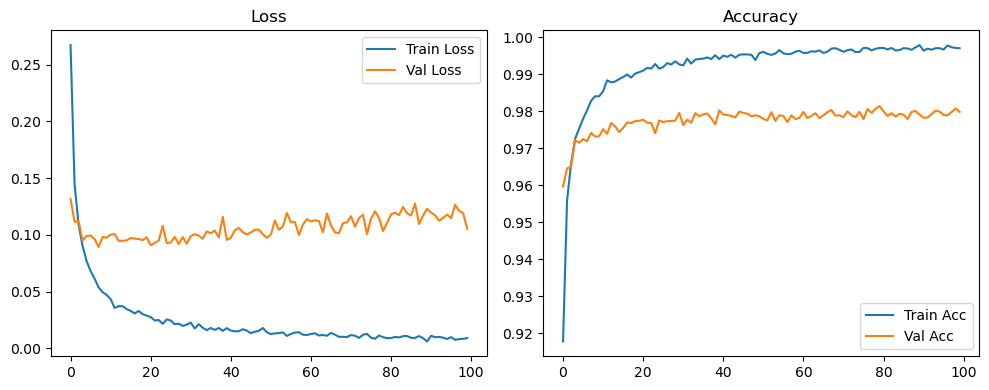

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4247, Acc: 0.8704 | Val Loss: 0.1660, Acc: 0.9508


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2549, Acc: 0.9236 | Val Loss: 0.1401, Acc: 0.9569


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2118, Acc: 0.9370 | Val Loss: 0.1258, Acc: 0.9612


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1838, Acc: 0.9468 | Val Loss: 0.1141, Acc: 0.9652


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1676, Acc: 0.9495 | Val Loss: 0.1079, Acc: 0.9682


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1558, Acc: 0.9536 | Val Loss: 0.1049, Acc: 0.9688


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1436, Acc: 0.9569 | Val Loss: 0.1012, Acc: 0.9708


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1365, Acc: 0.9606 | Val Loss: 0.0967, Acc: 0.9711


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1302, Acc: 0.9607 | Val Loss: 0.0970, Acc: 0.9723


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9620 | Val Loss: 0.0960, Acc: 0.9709


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1191, Acc: 0.9637 | Val Loss: 0.0905, Acc: 0.9742


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1140, Acc: 0.9649 | Val Loss: 0.0903, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1122, Acc: 0.9663 | Val Loss: 0.0927, Acc: 0.9749


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1100, Acc: 0.9662 | Val Loss: 0.0934, Acc: 0.9738


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9686 | Val Loss: 0.0977, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9691 | Val Loss: 0.0912, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9717 | Val Loss: 0.0909, Acc: 0.9753


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0964, Acc: 0.9700 | Val Loss: 0.0899, Acc: 0.9753


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9725 | Val Loss: 0.0890, Acc: 0.9754


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9728 | Val Loss: 0.0901, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0909, Acc: 0.9720 | Val Loss: 0.0863, Acc: 0.9757


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9730 | Val Loss: 0.0860, Acc: 0.9758


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9737 | Val Loss: 0.0848, Acc: 0.9764


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0828, Acc: 0.9740 | Val Loss: 0.0950, Acc: 0.9758


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9736 | Val Loss: 0.0877, Acc: 0.9771


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9748 | Val Loss: 0.0931, Acc: 0.9762


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9756 | Val Loss: 0.0949, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9756 | Val Loss: 0.0945, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9767 | Val Loss: 0.0940, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9763 | Val Loss: 0.0888, Acc: 0.9773


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9777 | Val Loss: 0.0889, Acc: 0.9758


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9781 | Val Loss: 0.0906, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9783 | Val Loss: 0.0879, Acc: 0.9769


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.0884, Acc: 0.9758


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9781 | Val Loss: 0.0901, Acc: 0.9770


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9791 | Val Loss: 0.0910, Acc: 0.9769


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0664, Acc: 0.9787 | Val Loss: 0.0887, Acc: 0.9767


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9787 | Val Loss: 0.0940, Acc: 0.9760


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9805 | Val Loss: 0.0967, Acc: 0.9768


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9800 | Val Loss: 0.0930, Acc: 0.9768


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9806 | Val Loss: 0.0876, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.0931, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9809 | Val Loss: 0.0969, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9814 | Val Loss: 0.0883, Acc: 0.9771


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.0937, Acc: 0.9764


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9803 | Val Loss: 0.0955, Acc: 0.9767


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9812 | Val Loss: 0.0898, Acc: 0.9777


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.0986, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9825 | Val Loss: 0.0923, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9821 | Val Loss: 0.1034, Acc: 0.9764


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9824 | Val Loss: 0.0920, Acc: 0.9775


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9825 | Val Loss: 0.0968, Acc: 0.9771


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9835 | Val Loss: 0.1012, Acc: 0.9766


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9824 | Val Loss: 0.1000, Acc: 0.9750


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9825 | Val Loss: 0.1028, Acc: 0.9750


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9837 | Val Loss: 0.0944, Acc: 0.9770


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9836 | Val Loss: 0.0990, Acc: 0.9762


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0947, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9848 | Val Loss: 0.0967, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 0.0921, Acc: 0.9779


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9846 | Val Loss: 0.1036, Acc: 0.9759


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9835 | Val Loss: 0.0893, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9842 | Val Loss: 0.0942, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9834 | Val Loss: 0.0922, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9836 | Val Loss: 0.0949, Acc: 0.9753


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9836 | Val Loss: 0.1006, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9848 | Val Loss: 0.0981, Acc: 0.9763


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0972, Acc: 0.9761


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9860 | Val Loss: 0.0954, Acc: 0.9755


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9848 | Val Loss: 0.0957, Acc: 0.9769


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9850 | Val Loss: 0.0980, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9862 | Val Loss: 0.1002, Acc: 0.9758


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9855 | Val Loss: 0.0980, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9846 | Val Loss: 0.0989, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 0.0947, Acc: 0.9783


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9852 | Val Loss: 0.0992, Acc: 0.9764


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.0955, Acc: 0.9774


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.1015, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9866 | Val Loss: 0.1069, Acc: 0.9758


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9854 | Val Loss: 0.1010, Acc: 0.9761


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.0949, Acc: 0.9772


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9858 | Val Loss: 0.1007, Acc: 0.9770


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9863 | Val Loss: 0.0982, Acc: 0.9776


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.1014, Acc: 0.9772


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9861 | Val Loss: 0.0986, Acc: 0.9773


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9866 | Val Loss: 0.1023, Acc: 0.9778


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.0977, Acc: 0.9770


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9869 | Val Loss: 0.0984, Acc: 0.9781


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9872 | Val Loss: 0.1000, Acc: 0.9758


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9868 | Val Loss: 0.0978, Acc: 0.9767


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9874 | Val Loss: 0.0970, Acc: 0.9772


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.1089, Acc: 0.9766


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 0.1010, Acc: 0.9775


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.1001, Acc: 0.9770


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.1061, Acc: 0.9765


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.1026, Acc: 0.9765


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.0902, Acc: 0.9776


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0972, Acc: 0.9772


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0985, Acc: 0.9772


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0989, Acc: 0.9763


Final Test Loss: 0.0871 Accuracy: 0.9802


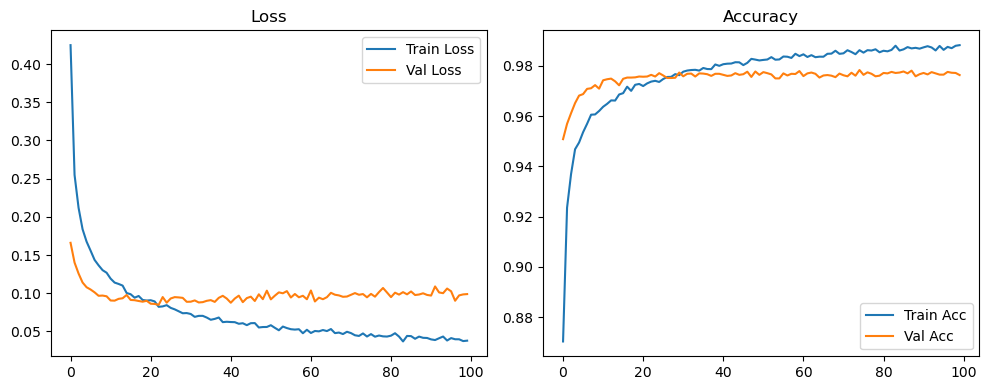

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2183, Acc: 0.9327 | Val Loss: 0.1227, Acc: 0.9628


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1062, Acc: 0.9661 | Val Loss: 0.1111, Acc: 0.9645


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0716, Acc: 0.9776 | Val Loss: 0.1127, Acc: 0.9660


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9821 | Val Loss: 0.1036, Acc: 0.9698


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9848 | Val Loss: 0.1075, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9878 | Val Loss: 0.1120, Acc: 0.9705


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9885 | Val Loss: 0.1072, Acc: 0.9728


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.1046, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1122, Acc: 0.9720


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9917 | Val Loss: 0.1182, Acc: 0.9732


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.1207, Acc: 0.9725


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.1107, Acc: 0.9737


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1096, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1140, Acc: 0.9750


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9946 | Val Loss: 0.1120, Acc: 0.9742


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1226, Acc: 0.9723


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1153, Acc: 0.9757


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1139, Acc: 0.9733


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1228, Acc: 0.9742


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1164, Acc: 0.9761


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1227, Acc: 0.9750


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1143, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1278, Acc: 0.9754


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9956 | Val Loss: 0.1127, Acc: 0.9762


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1237, Acc: 0.9761


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1412, Acc: 0.9724


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1354, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1408, Acc: 0.9722


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1232, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1360, Acc: 0.9748


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1493, Acc: 0.9732


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1201, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1234, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1252, Acc: 0.9761


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1252, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1254, Acc: 0.9760


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1278, Acc: 0.9765


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1331, Acc: 0.9762


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.1439, Acc: 0.9768


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9970 | Val Loss: 0.1277, Acc: 0.9758


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1130, Acc: 0.9768


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1245, Acc: 0.9785


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1338, Acc: 0.9767


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1529, Acc: 0.9742


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1316, Acc: 0.9776


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1421, Acc: 0.9762


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1468, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1334, Acc: 0.9777


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1467, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1465, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1249, Acc: 0.9791


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1310, Acc: 0.9790


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1348, Acc: 0.9793


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1386, Acc: 0.9790


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1438, Acc: 0.9783


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1397, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1415, Acc: 0.9799


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1488, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1457, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1498, Acc: 0.9793


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1647, Acc: 0.9775


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1472, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1469, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1523, Acc: 0.9769


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1601, Acc: 0.9788


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1548, Acc: 0.9775


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1512, Acc: 0.9775


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1489, Acc: 0.9791


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1546, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1685, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1601, Acc: 0.9788


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1605, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1625, Acc: 0.9791


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1675, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1731, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1722, Acc: 0.9778


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1732, Acc: 0.9785


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1782, Acc: 0.9787


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1674, Acc: 0.9781


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1687, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1629, Acc: 0.9785


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1645, Acc: 0.9784


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1636, Acc: 0.9783


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1584, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1685, Acc: 0.9781


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1686, Acc: 0.9785


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1669, Acc: 0.9787


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1706, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1709, Acc: 0.9786


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1681, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1730, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1719, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1757, Acc: 0.9793


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1852, Acc: 0.9787


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1819, Acc: 0.9793


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1751, Acc: 0.9795


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1760, Acc: 0.9797


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1722, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1774, Acc: 0.9799


Final Test Loss: 0.1431 Accuracy: 0.9818


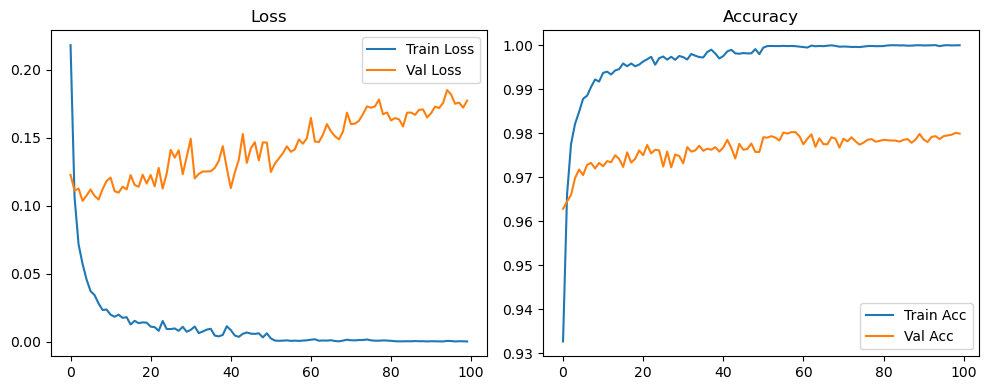

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2673, Acc: 0.9178 | Val Loss: 0.1316, Acc: 0.9597


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1450, Acc: 0.9559 | Val Loss: 0.1116, Acc: 0.9646


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1090, Acc: 0.9658 | Val Loss: 0.1122, Acc: 0.9650


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0903, Acc: 0.9725 | Val Loss: 0.0950, Acc: 0.9722


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9753 | Val Loss: 0.0991, Acc: 0.9715


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9780 | Val Loss: 0.0995, Acc: 0.9725


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9802 | Val Loss: 0.0963, Acc: 0.9719


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9828 | Val Loss: 0.0894, Acc: 0.9742


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.0983, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9840 | Val Loss: 0.0977, Acc: 0.9732


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.1002, Acc: 0.9752


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.1008, Acc: 0.9739


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0948, Acc: 0.9768


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.0949, Acc: 0.9759


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.0952, Acc: 0.9744


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0973, Acc: 0.9755


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0968, Acc: 0.9770


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.0964, Acc: 0.9768


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.0955, Acc: 0.9773


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.0980, Acc: 0.9774


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0909, Acc: 0.9778


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.0930, Acc: 0.9769


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.0949, Acc: 0.9768


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1081, Acc: 0.9741


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0928, Acc: 0.9775


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0933, Acc: 0.9771


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0983, Acc: 0.9773


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0921, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0981, Acc: 0.9775


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.0923, Acc: 0.9796


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0990, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1006, Acc: 0.9778


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0994, Acc: 0.9769


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0967, Acc: 0.9795


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9941 | Val Loss: 0.1032, Acc: 0.9787


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1015, Acc: 0.9792


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1039, Acc: 0.9794


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0978, Acc: 0.9781


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.1159, Acc: 0.9765


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0957, Acc: 0.9802


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0974, Acc: 0.9791


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.1042, Acc: 0.9790


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1063, Acc: 0.9788


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1024, Acc: 0.9783


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1004, Acc: 0.9799


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1023, Acc: 0.9796


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1045, Acc: 0.9793


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1047, Acc: 0.9787


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1007, Acc: 0.9789


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0975, Acc: 0.9787


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0913, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0981, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0988, Acc: 0.9807


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1004, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1020, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1021, Acc: 0.9817


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0988, Acc: 0.9819


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1022, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1083, Acc: 0.9809


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1110, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1094, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1104, Acc: 0.9806


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1120, Acc: 0.9801


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1077, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1089, Acc: 0.9803


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1109, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1127, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1172, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1128, Acc: 0.9804


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1174, Acc: 0.9801


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1177, Acc: 0.9808


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1203, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1120, Acc: 0.9809


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1118, Acc: 0.9803


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1073, Acc: 0.9807


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1152, Acc: 0.9811


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1124, Acc: 0.9810


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1135, Acc: 0.9815


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1126, Acc: 0.9813


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1085, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1065, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1114, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1128, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9820


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1109, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1106, Acc: 0.9817


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1118, Acc: 0.9814


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9813


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1120, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1066, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1129, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1120, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1171, Acc: 0.9809


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1236, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1185, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1202, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1243, Acc: 0.9801


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1228, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1179, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1161, Acc: 0.9825


Final Test Loss: 0.1161 Accuracy: 0.9846


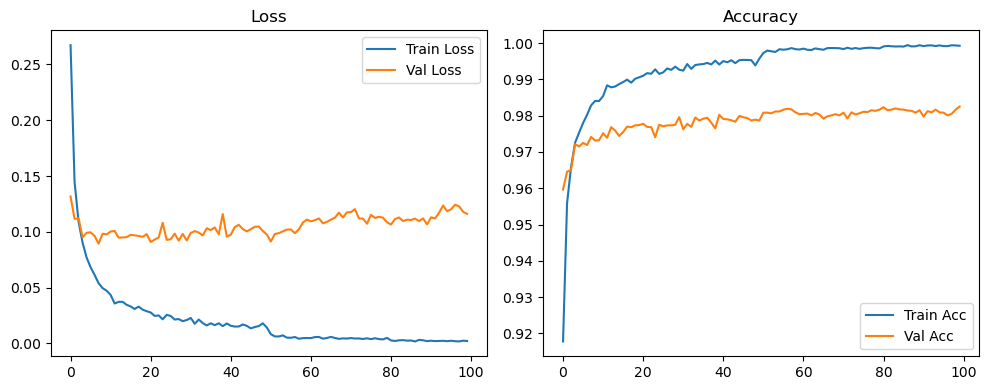

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4247, Acc: 0.8704 | Val Loss: 0.1660, Acc: 0.9508


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2549, Acc: 0.9236 | Val Loss: 0.1401, Acc: 0.9569


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2118, Acc: 0.9370 | Val Loss: 0.1258, Acc: 0.9612


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1838, Acc: 0.9468 | Val Loss: 0.1141, Acc: 0.9652


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1676, Acc: 0.9495 | Val Loss: 0.1079, Acc: 0.9682


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1558, Acc: 0.9536 | Val Loss: 0.1049, Acc: 0.9688


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1436, Acc: 0.9569 | Val Loss: 0.1012, Acc: 0.9708


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1365, Acc: 0.9606 | Val Loss: 0.0967, Acc: 0.9711


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1302, Acc: 0.9607 | Val Loss: 0.0970, Acc: 0.9723


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1269, Acc: 0.9620 | Val Loss: 0.0960, Acc: 0.9709


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1191, Acc: 0.9637 | Val Loss: 0.0905, Acc: 0.9742


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1140, Acc: 0.9649 | Val Loss: 0.0903, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1122, Acc: 0.9663 | Val Loss: 0.0927, Acc: 0.9749


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1100, Acc: 0.9662 | Val Loss: 0.0934, Acc: 0.9738


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9686 | Val Loss: 0.0977, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9691 | Val Loss: 0.0912, Acc: 0.9748


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9717 | Val Loss: 0.0909, Acc: 0.9753


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0964, Acc: 0.9700 | Val Loss: 0.0899, Acc: 0.9753


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9725 | Val Loss: 0.0890, Acc: 0.9754


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9728 | Val Loss: 0.0901, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0909, Acc: 0.9720 | Val Loss: 0.0863, Acc: 0.9757


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9730 | Val Loss: 0.0860, Acc: 0.9758


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0823, Acc: 0.9737 | Val Loss: 0.0848, Acc: 0.9764


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0828, Acc: 0.9740 | Val Loss: 0.0950, Acc: 0.9758


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0844, Acc: 0.9736 | Val Loss: 0.0877, Acc: 0.9771


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9748 | Val Loss: 0.0931, Acc: 0.9762


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9756 | Val Loss: 0.0949, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9756 | Val Loss: 0.0945, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9767 | Val Loss: 0.0940, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9763 | Val Loss: 0.0888, Acc: 0.9773


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9777 | Val Loss: 0.0889, Acc: 0.9758


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9781 | Val Loss: 0.0906, Acc: 0.9768


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9783 | Val Loss: 0.0879, Acc: 0.9769


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9784 | Val Loss: 0.0884, Acc: 0.9758


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9781 | Val Loss: 0.0901, Acc: 0.9770


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9791 | Val Loss: 0.0910, Acc: 0.9769


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0664, Acc: 0.9787 | Val Loss: 0.0887, Acc: 0.9767


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9787 | Val Loss: 0.0940, Acc: 0.9760


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9805 | Val Loss: 0.0967, Acc: 0.9768


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9800 | Val Loss: 0.0930, Acc: 0.9768


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9806 | Val Loss: 0.0876, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.0931, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9809 | Val Loss: 0.0969, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9814 | Val Loss: 0.0883, Acc: 0.9771


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.0937, Acc: 0.9764


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9803 | Val Loss: 0.0955, Acc: 0.9767


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9812 | Val Loss: 0.0898, Acc: 0.9777


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.0986, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9825 | Val Loss: 0.0923, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9821 | Val Loss: 0.1034, Acc: 0.9764


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9847 | Val Loss: 0.0927, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.0927, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9879 | Val Loss: 0.0952, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.0975, Acc: 0.9770


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0992, Acc: 0.9772


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0954, Acc: 0.9780


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0969, Acc: 0.9779


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.0984, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9897 | Val Loss: 0.0978, Acc: 0.9781


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.0979, Acc: 0.9779


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.1028, Acc: 0.9770


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1017, Acc: 0.9773


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9898 | Val Loss: 0.0979, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0989, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.1044, Acc: 0.9774


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.0970, Acc: 0.9779


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9897 | Val Loss: 0.1011, Acc: 0.9769


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.0988, Acc: 0.9774


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.1008, Acc: 0.9772


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9898 | Val Loss: 0.0981, Acc: 0.9786


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.1012, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.1031, Acc: 0.9772


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.1022, Acc: 0.9782


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.0988, Acc: 0.9783


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9918 | Val Loss: 0.1023, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1043, Acc: 0.9783


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1056, Acc: 0.9772


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.1030, Acc: 0.9787


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.1056, Acc: 0.9774


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.1036, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1021, Acc: 0.9774


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.1024, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.1035, Acc: 0.9774


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1052, Acc: 0.9784


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.1089, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9932 | Val Loss: 0.1077, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.1098, Acc: 0.9784


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9926 | Val Loss: 0.1042, Acc: 0.9779


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.1053, Acc: 0.9773


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1014, Acc: 0.9787


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.1039, Acc: 0.9783


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1069, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1079, Acc: 0.9784


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.1052, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.1084, Acc: 0.9774


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1096, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1110, Acc: 0.9770


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.1102, Acc: 0.9766


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1098, Acc: 0.9769


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1087, Acc: 0.9778


Final Test Loss: 0.0928 Accuracy: 0.9807


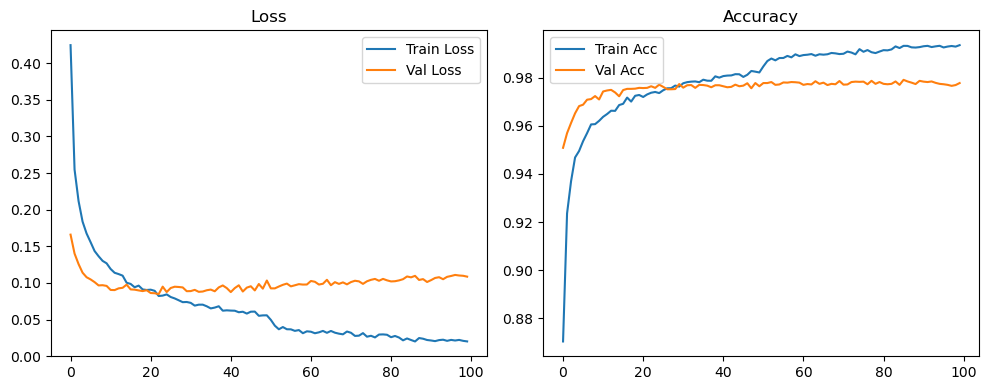

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2139, Acc: 0.9353 | Val Loss: 0.1178, Acc: 0.9632


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0938, Acc: 0.9708 | Val Loss: 0.1042, Acc: 0.9675


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9801 | Val Loss: 0.1079, Acc: 0.9667


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9842 | Val Loss: 0.1053, Acc: 0.9708


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9869 | Val Loss: 0.0946, Acc: 0.9730


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0978, Acc: 0.9737


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1118, Acc: 0.9712


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.1056, Acc: 0.9718


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.1094, Acc: 0.9742


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9936 | Val Loss: 0.1230, Acc: 0.9718


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1097, Acc: 0.9753


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1017, Acc: 0.9768


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1203, Acc: 0.9742


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1063, Acc: 0.9767


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.1269, Acc: 0.9722


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1175, Acc: 0.9743


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1029, Acc: 0.9772


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1139, Acc: 0.9757


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1205, Acc: 0.9752


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1139, Acc: 0.9745


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1241, Acc: 0.9742


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1161, Acc: 0.9757


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1072, Acc: 0.9768


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1172, Acc: 0.9751


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1254, Acc: 0.9758


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1044, Acc: 0.9779


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1231, Acc: 0.9755


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1190, Acc: 0.9773


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1332, Acc: 0.9758


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1226, Acc: 0.9772


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1233, Acc: 0.9786


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1022, Acc: 0.9787


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1180, Acc: 0.9783


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1332, Acc: 0.9756


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1294, Acc: 0.9762


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1263, Acc: 0.9762


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1211, Acc: 0.9777


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1172, Acc: 0.9791


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1350, Acc: 0.9769


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1262, Acc: 0.9772


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1299, Acc: 0.9782


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1373, Acc: 0.9762


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1213, Acc: 0.9779


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1249, Acc: 0.9786


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1311, Acc: 0.9758


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1396, Acc: 0.9744


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1452, Acc: 0.9753


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1344, Acc: 0.9771


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1302, Acc: 0.9767


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1290, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1336, Acc: 0.9758


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1266, Acc: 0.9774


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1228, Acc: 0.9794


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1351, Acc: 0.9778


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1380, Acc: 0.9772


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1437, Acc: 0.9763


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1322, Acc: 0.9788


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1291, Acc: 0.9788


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1267, Acc: 0.9784


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1208, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1239, Acc: 0.9791


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1300, Acc: 0.9789


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1329, Acc: 0.9768


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1323, Acc: 0.9765


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1397, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1223, Acc: 0.9787


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1337, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1246, Acc: 0.9804


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1255, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1421, Acc: 0.9774


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.1358, Acc: 0.9800


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1369, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1427, Acc: 0.9758


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1448, Acc: 0.9771


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1345, Acc: 0.9791


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1243, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1256, Acc: 0.9794


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1317, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1347, Acc: 0.9796


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1516, Acc: 0.9773


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1504, Acc: 0.9758


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1281, Acc: 0.9798


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1429, Acc: 0.9789


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.1529, Acc: 0.9769


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1459, Acc: 0.9778


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1360, Acc: 0.9787


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1324, Acc: 0.9793


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1348, Acc: 0.9794


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1383, Acc: 0.9779


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1286, Acc: 0.9789


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1376, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1464, Acc: 0.9767


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1418, Acc: 0.9786


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1358, Acc: 0.9795


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1424, Acc: 0.9794


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1298, Acc: 0.9802


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1477, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1362, Acc: 0.9788


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1282, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1488, Acc: 0.9783


Final Test Loss: 0.1297 Accuracy: 0.9778


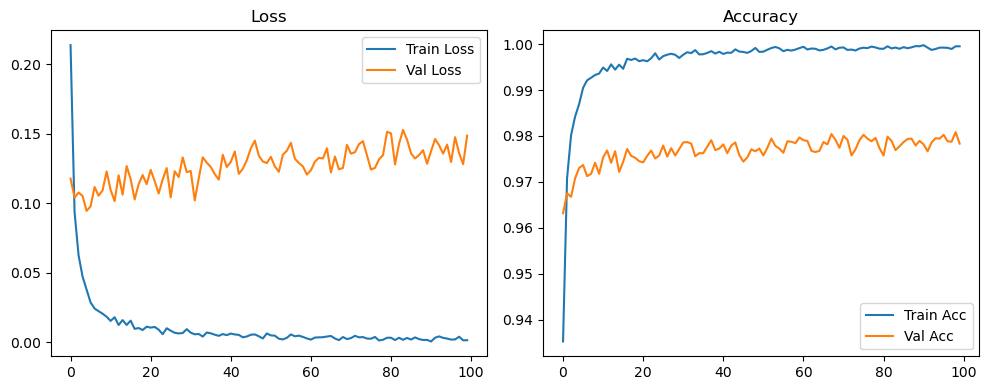

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2766, Acc: 0.9174 | Val Loss: 0.1243, Acc: 0.9605


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1384, Acc: 0.9569 | Val Loss: 0.1085, Acc: 0.9656


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1062, Acc: 0.9662 | Val Loss: 0.1033, Acc: 0.9680


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0846, Acc: 0.9731 | Val Loss: 0.0921, Acc: 0.9717


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9755 | Val Loss: 0.0858, Acc: 0.9747


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9799 | Val Loss: 0.0869, Acc: 0.9734


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9821 | Val Loss: 0.0874, Acc: 0.9741


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9839 | Val Loss: 0.0856, Acc: 0.9758


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9852 | Val Loss: 0.0965, Acc: 0.9726


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9850 | Val Loss: 0.0886, Acc: 0.9763


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9873 | Val Loss: 0.0952, Acc: 0.9751


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.0943, Acc: 0.9763


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.0903, Acc: 0.9770


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9888 | Val Loss: 0.0886, Acc: 0.9770


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.0935, Acc: 0.9761


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.0887, Acc: 0.9778


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9909 | Val Loss: 0.0880, Acc: 0.9763


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.0950, Acc: 0.9768


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9909 | Val Loss: 0.0969, Acc: 0.9768


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0979, Acc: 0.9759


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.0931, Acc: 0.9779


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0922, Acc: 0.9766


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0906, Acc: 0.9782


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0959, Acc: 0.9765


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.1046, Acc: 0.9765


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9930 | Val Loss: 0.0921, Acc: 0.9767


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0930, Acc: 0.9784


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.0922, Acc: 0.9791


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0990, Acc: 0.9786


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9945 | Val Loss: 0.0981, Acc: 0.9782


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0990, Acc: 0.9767


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0940, Acc: 0.9772


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0936, Acc: 0.9789


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.1082, Acc: 0.9765


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1104, Acc: 0.9777


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0987, Acc: 0.9787


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0996, Acc: 0.9792


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0913, Acc: 0.9802


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0989, Acc: 0.9783


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0943, Acc: 0.9786


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1005, Acc: 0.9788


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0966, Acc: 0.9789


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1030, Acc: 0.9783


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1040, Acc: 0.9784


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1000, Acc: 0.9791


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1027, Acc: 0.9783


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1114, Acc: 0.9787


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1022, Acc: 0.9795


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0946, Acc: 0.9797


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0941, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0951, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1026, Acc: 0.9794


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1124, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1076, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1073, Acc: 0.9790


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1059, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1083, Acc: 0.9776


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1060, Acc: 0.9788


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1105, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1050, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1117, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1071, Acc: 0.9793


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1022, Acc: 0.9795


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1057, Acc: 0.9796


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1143, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1113, Acc: 0.9790


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1077, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1090, Acc: 0.9785


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1032, Acc: 0.9790


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1081, Acc: 0.9787


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1051, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.1059, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1038, Acc: 0.9792


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1064, Acc: 0.9783


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1019, Acc: 0.9804


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1078, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1102, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1040, Acc: 0.9808


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1089, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1159, Acc: 0.9777


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9783


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1127, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1130, Acc: 0.9780


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1031, Acc: 0.9794


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1123, Acc: 0.9790


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1104, Acc: 0.9789


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1130, Acc: 0.9776


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1080, Acc: 0.9791


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1117, Acc: 0.9794


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1168, Acc: 0.9784


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1144, Acc: 0.9802


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1126, Acc: 0.9801


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1160, Acc: 0.9792


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1096, Acc: 0.9795


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1093, Acc: 0.9800


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1103, Acc: 0.9798


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1119, Acc: 0.9789


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1017, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1071, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1053, Acc: 0.9798


Final Test Loss: 0.1038 Accuracy: 0.9805


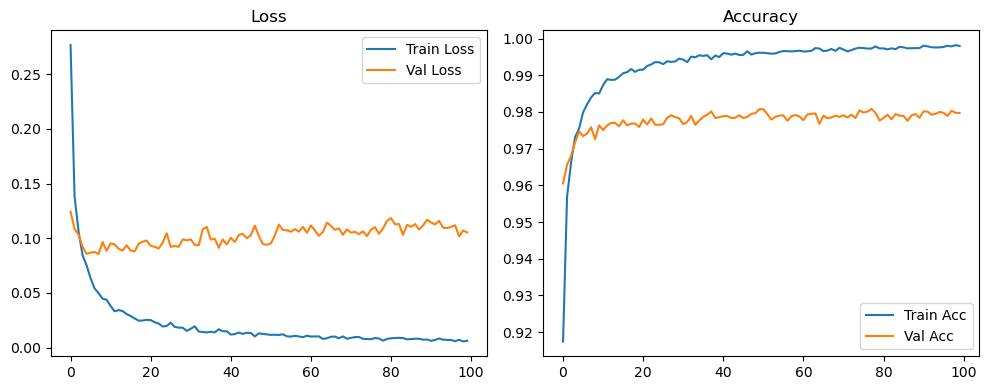

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4609, Acc: 0.8588 | Val Loss: 0.1801, Acc: 0.9455


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2606, Acc: 0.9221 | Val Loss: 0.1487, Acc: 0.9533


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2127, Acc: 0.9363 | Val Loss: 0.1317, Acc: 0.9601


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1873, Acc: 0.9437 | Val Loss: 0.1163, Acc: 0.9648


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1697, Acc: 0.9476 | Val Loss: 0.1054, Acc: 0.9680


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1532, Acc: 0.9541 | Val Loss: 0.1049, Acc: 0.9686


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1424, Acc: 0.9570 | Val Loss: 0.0990, Acc: 0.9707


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1305, Acc: 0.9596 | Val Loss: 0.0960, Acc: 0.9717


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1275, Acc: 0.9608 | Val Loss: 0.0960, Acc: 0.9734


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1199, Acc: 0.9629 | Val Loss: 0.0966, Acc: 0.9733


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1155, Acc: 0.9634 | Val Loss: 0.0945, Acc: 0.9730


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1068, Acc: 0.9671 | Val Loss: 0.0925, Acc: 0.9748


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1040, Acc: 0.9673 | Val Loss: 0.0896, Acc: 0.9750


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1008, Acc: 0.9687 | Val Loss: 0.0908, Acc: 0.9743


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0965, Acc: 0.9698 | Val Loss: 0.0935, Acc: 0.9752


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0937, Acc: 0.9708 | Val Loss: 0.0914, Acc: 0.9738


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0881, Acc: 0.9731 | Val Loss: 0.0878, Acc: 0.9751


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0872, Acc: 0.9724 | Val Loss: 0.0900, Acc: 0.9752


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0863, Acc: 0.9737 | Val Loss: 0.0917, Acc: 0.9740


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0823, Acc: 0.9746 | Val Loss: 0.0872, Acc: 0.9759


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0817, Acc: 0.9740 | Val Loss: 0.0844, Acc: 0.9764


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0778, Acc: 0.9750 | Val Loss: 0.0885, Acc: 0.9750


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0785, Acc: 0.9758 | Val Loss: 0.0894, Acc: 0.9767


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0759, Acc: 0.9766 | Val Loss: 0.0897, Acc: 0.9763


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0721, Acc: 0.9772 | Val Loss: 0.0909, Acc: 0.9750


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9771 | Val Loss: 0.0891, Acc: 0.9758


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0703, Acc: 0.9779 | Val Loss: 0.0936, Acc: 0.9755


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0724, Acc: 0.9765 | Val Loss: 0.0893, Acc: 0.9764


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9790 | Val Loss: 0.0941, Acc: 0.9759


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9790 | Val Loss: 0.0898, Acc: 0.9768


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0919, Acc: 0.9751


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9796 | Val Loss: 0.0892, Acc: 0.9770


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9799 | Val Loss: 0.0856, Acc: 0.9768


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0636, Acc: 0.9795 | Val Loss: 0.0877, Acc: 0.9775


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0607, Acc: 0.9809 | Val Loss: 0.0922, Acc: 0.9769


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0608, Acc: 0.9805 | Val Loss: 0.0869, Acc: 0.9773


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9805 | Val Loss: 0.0867, Acc: 0.9782


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9817 | Val Loss: 0.0886, Acc: 0.9778


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9809 | Val Loss: 0.0906, Acc: 0.9771


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9825 | Val Loss: 0.0877, Acc: 0.9775


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9825 | Val Loss: 0.0906, Acc: 0.9768


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9829 | Val Loss: 0.0945, Acc: 0.9774


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9820 | Val Loss: 0.0910, Acc: 0.9776


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9824 | Val Loss: 0.0936, Acc: 0.9773


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9832 | Val Loss: 0.0940, Acc: 0.9775


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 0.0923, Acc: 0.9768


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9827 | Val Loss: 0.0906, Acc: 0.9771


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9844 | Val Loss: 0.0949, Acc: 0.9764


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9831 | Val Loss: 0.0940, Acc: 0.9765


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9843 | Val Loss: 0.0936, Acc: 0.9779


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9847 | Val Loss: 0.0906, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9843 | Val Loss: 0.0911, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 0.0936, Acc: 0.9780


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9843 | Val Loss: 0.0955, Acc: 0.9774


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9841 | Val Loss: 0.0917, Acc: 0.9777


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.0966, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9845 | Val Loss: 0.0942, Acc: 0.9778


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.0950, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0969, Acc: 0.9782


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9848 | Val Loss: 0.0902, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.0957, Acc: 0.9777


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.1001, Acc: 0.9762


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9873 | Val Loss: 0.0957, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9856 | Val Loss: 0.0961, Acc: 0.9778


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9861 | Val Loss: 0.0983, Acc: 0.9781


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9852 | Val Loss: 0.0911, Acc: 0.9786


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.0944, Acc: 0.9787


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 0.0922, Acc: 0.9785


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0952, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9865 | Val Loss: 0.0941, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.0957, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9873 | Val Loss: 0.0947, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.0937, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9863 | Val Loss: 0.0936, Acc: 0.9775


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.0964, Acc: 0.9776


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.0955, Acc: 0.9785


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.0941, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.1028, Acc: 0.9776


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0994, Acc: 0.9790


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.0997, Acc: 0.9781


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.1019, Acc: 0.9778


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9875 | Val Loss: 0.0989, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9880 | Val Loss: 0.0957, Acc: 0.9789


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9891 | Val Loss: 0.0985, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 0.0984, Acc: 0.9780


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9882 | Val Loss: 0.1034, Acc: 0.9774


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9870 | Val Loss: 0.0976, Acc: 0.9771


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.1016, Acc: 0.9784


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0980, Acc: 0.9781


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.0931, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.0993, Acc: 0.9790


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 0.0952, Acc: 0.9778


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.1010, Acc: 0.9772


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.0990, Acc: 0.9781


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.1027, Acc: 0.9788


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0981, Acc: 0.9785


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9888 | Val Loss: 0.0988, Acc: 0.9783


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.0981, Acc: 0.9778


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.1002, Acc: 0.9779


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9883 | Val Loss: 0.0958, Acc: 0.9793


Final Test Loss: 0.0872 Accuracy: 0.9803


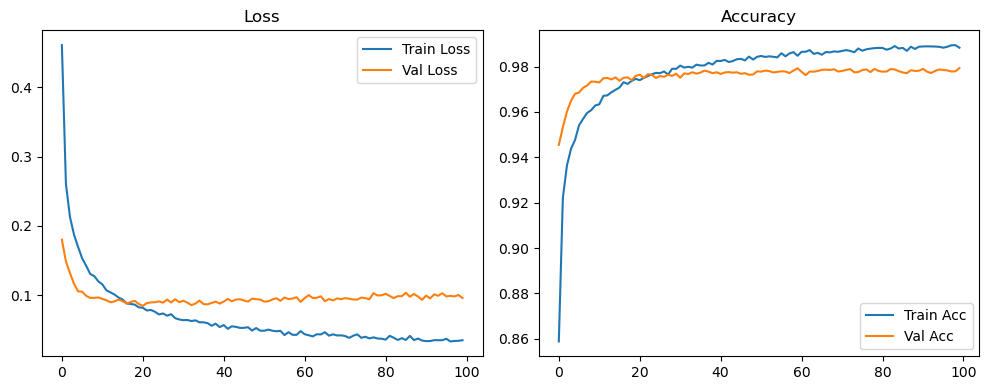

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2281, Acc: 0.9335 | Val Loss: 0.1145, Acc: 0.9640


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0882, Acc: 0.9728 | Val Loss: 0.1060, Acc: 0.9644


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9821 | Val Loss: 0.1076, Acc: 0.9664


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.0941, Acc: 0.9713


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9884 | Val Loss: 0.0978, Acc: 0.9714


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.1038, Acc: 0.9717


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0905, Acc: 0.9738


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.0969, Acc: 0.9722


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1062, Acc: 0.9733


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0982, Acc: 0.9745


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.0970, Acc: 0.9762


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0954, Acc: 0.9766


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0918, Acc: 0.9782


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.1114, Acc: 0.9748


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1148, Acc: 0.9735


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1027, Acc: 0.9742


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1006, Acc: 0.9758


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1035, Acc: 0.9762


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1078, Acc: 0.9755


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0982, Acc: 0.9769


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0968, Acc: 0.9773


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0947, Acc: 0.9788


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1089, Acc: 0.9758


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1072, Acc: 0.9772


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1149, Acc: 0.9762


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1090, Acc: 0.9760


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1143, Acc: 0.9746


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1191, Acc: 0.9763


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1156, Acc: 0.9758


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1215, Acc: 0.9758


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1094, Acc: 0.9772


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1148, Acc: 0.9767


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1147, Acc: 0.9777


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1132, Acc: 0.9776


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1228, Acc: 0.9758


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1198, Acc: 0.9756


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1224, Acc: 0.9788


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1304, Acc: 0.9773


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1297, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1162, Acc: 0.9781


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1353, Acc: 0.9748


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1146, Acc: 0.9790


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1207, Acc: 0.9772


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1365, Acc: 0.9749


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1195, Acc: 0.9772


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1133, Acc: 0.9783


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1121, Acc: 0.9796


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1081, Acc: 0.9781


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1135, Acc: 0.9774


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1442, Acc: 0.9748


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1251, Acc: 0.9761


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1193, Acc: 0.9768


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1049, Acc: 0.9782


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1101, Acc: 0.9794


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0982, Acc: 0.9811


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1075, Acc: 0.9798


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1060, Acc: 0.9809


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1262, Acc: 0.9762


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1253, Acc: 0.9752


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1222, Acc: 0.9778


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1144, Acc: 0.9790


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1156, Acc: 0.9788


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1049, Acc: 0.9801


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1125, Acc: 0.9782


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1378, Acc: 0.9763


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1139, Acc: 0.9782


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1244, Acc: 0.9776


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1231, Acc: 0.9760


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1293, Acc: 0.9759


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1245, Acc: 0.9782


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1237, Acc: 0.9775


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1247, Acc: 0.9763


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1147, Acc: 0.9799


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1232, Acc: 0.9782


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1165, Acc: 0.9785


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1421, Acc: 0.9759


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1300, Acc: 0.9772


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1262, Acc: 0.9776


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1223, Acc: 0.9783


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1352, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1392, Acc: 0.9761


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1471, Acc: 0.9741


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1396, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1255, Acc: 0.9782


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1226, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1371, Acc: 0.9778


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1252, Acc: 0.9779


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1324, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1432, Acc: 0.9773


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1390, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1436, Acc: 0.9769


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1327, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1407, Acc: 0.9770


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1470, Acc: 0.9756


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1319, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1297, Acc: 0.9767


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1308, Acc: 0.9774


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1449, Acc: 0.9764


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1374, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1312, Acc: 0.9784


Final Test Loss: 0.1321 Accuracy: 0.9796


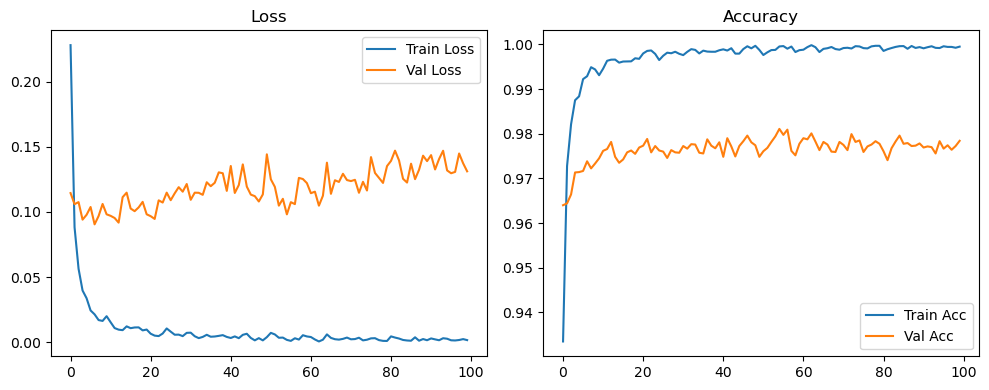

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3056, Acc: 0.9109 | Val Loss: 0.1344, Acc: 0.9580


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1398, Acc: 0.9560 | Val Loss: 0.1089, Acc: 0.9654


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1072, Acc: 0.9664 | Val Loss: 0.1075, Acc: 0.9659


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0871, Acc: 0.9721 | Val Loss: 0.0990, Acc: 0.9704


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0726, Acc: 0.9768 | Val Loss: 0.0914, Acc: 0.9722


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9791 | Val Loss: 0.0972, Acc: 0.9709


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9814 | Val Loss: 0.0868, Acc: 0.9747


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9841 | Val Loss: 0.0834, Acc: 0.9749


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9846 | Val Loss: 0.0909, Acc: 0.9742


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9858 | Val Loss: 0.0909, Acc: 0.9752


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9881 | Val Loss: 0.0942, Acc: 0.9733


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9884 | Val Loss: 0.0939, Acc: 0.9746


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9889 | Val Loss: 0.0902, Acc: 0.9762


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0907, Acc: 0.9759


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0930, Acc: 0.9756


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0874, Acc: 0.9780


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0943, Acc: 0.9755


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0926, Acc: 0.9769


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.0892, Acc: 0.9774


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9909 | Val Loss: 0.0914, Acc: 0.9776


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9923 | Val Loss: 0.1043, Acc: 0.9758


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9926 | Val Loss: 0.0934, Acc: 0.9779


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0969, Acc: 0.9750


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0992, Acc: 0.9775


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1016, Acc: 0.9765


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0952, Acc: 0.9773


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.1055, Acc: 0.9749


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.0930, Acc: 0.9772


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0948, Acc: 0.9772


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0964, Acc: 0.9783


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1028, Acc: 0.9769


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.1065, Acc: 0.9763


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1013, Acc: 0.9775


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.1010, Acc: 0.9772


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0941, Acc: 0.9784


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1020, Acc: 0.9771


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1082, Acc: 0.9769


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0982, Acc: 0.9774


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0997, Acc: 0.9789


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1025, Acc: 0.9779


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.1001, Acc: 0.9778


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9953 | Val Loss: 0.0985, Acc: 0.9771


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0931, Acc: 0.9791


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0990, Acc: 0.9780


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1019, Acc: 0.9788


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1019, Acc: 0.9798


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1040, Acc: 0.9782


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1040, Acc: 0.9787


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1110, Acc: 0.9772


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1040, Acc: 0.9784


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9961 | Val Loss: 0.1074, Acc: 0.9778


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1045, Acc: 0.9759


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0968, Acc: 0.9784


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0980, Acc: 0.9791


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0992, Acc: 0.9794


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0987, Acc: 0.9800


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1071, Acc: 0.9782


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1044, Acc: 0.9778


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1045, Acc: 0.9790


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0996, Acc: 0.9803


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1108, Acc: 0.9782


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1079, Acc: 0.9783


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1095, Acc: 0.9773


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1072, Acc: 0.9786


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1066, Acc: 0.9791


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1004, Acc: 0.9793


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1016, Acc: 0.9794


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1037, Acc: 0.9797


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1076, Acc: 0.9779


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1145, Acc: 0.9770


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1089, Acc: 0.9768


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1085, Acc: 0.9792


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1097, Acc: 0.9788


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.1086, Acc: 0.9794


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1065, Acc: 0.9798


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1061, Acc: 0.9797


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1032, Acc: 0.9798


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1128, Acc: 0.9792


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1079, Acc: 0.9794


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1063, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1096, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1140, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1054, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1076, Acc: 0.9793


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1087, Acc: 0.9791


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1131, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1128, Acc: 0.9787


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1068, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1117, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1084, Acc: 0.9800


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1124, Acc: 0.9790


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1053, Acc: 0.9789


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1110, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1145, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1111, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1076, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1084, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1138, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1047, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1048, Acc: 0.9791


Final Test Loss: 0.0979 Accuracy: 0.9814


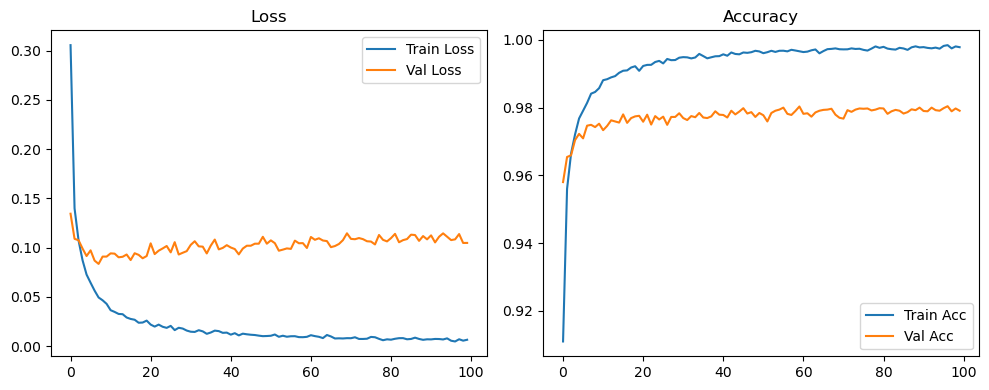

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5367, Acc: 0.8380 | Val Loss: 0.1898, Acc: 0.9424


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2770, Acc: 0.9159 | Val Loss: 0.1598, Acc: 0.9503


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2246, Acc: 0.9321 | Val Loss: 0.1374, Acc: 0.9583


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1992, Acc: 0.9401 | Val Loss: 0.1231, Acc: 0.9630


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1789, Acc: 0.9452 | Val Loss: 0.1130, Acc: 0.9671


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1596, Acc: 0.9518 | Val Loss: 0.1090, Acc: 0.9657


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1506, Acc: 0.9555 | Val Loss: 0.1046, Acc: 0.9683


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1358, Acc: 0.9588 | Val Loss: 0.1004, Acc: 0.9690


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1327, Acc: 0.9597 | Val Loss: 0.0997, Acc: 0.9710


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1284, Acc: 0.9607 | Val Loss: 0.0978, Acc: 0.9709


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1217, Acc: 0.9620 | Val Loss: 0.0946, Acc: 0.9727


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1121, Acc: 0.9641 | Val Loss: 0.0926, Acc: 0.9731


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1075, Acc: 0.9669 | Val Loss: 0.0933, Acc: 0.9729


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1045, Acc: 0.9671 | Val Loss: 0.0937, Acc: 0.9739


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0998, Acc: 0.9680 | Val Loss: 0.0939, Acc: 0.9732


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0957, Acc: 0.9704 | Val Loss: 0.0916, Acc: 0.9738


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0880, Acc: 0.9729 | Val Loss: 0.0877, Acc: 0.9762


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0885, Acc: 0.9726 | Val Loss: 0.0870, Acc: 0.9751


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9724 | Val Loss: 0.0886, Acc: 0.9758


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0883, Acc: 0.9725 | Val Loss: 0.0860, Acc: 0.9760


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0842, Acc: 0.9733 | Val Loss: 0.0826, Acc: 0.9765


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0771, Acc: 0.9754 | Val Loss: 0.0885, Acc: 0.9755


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9752 | Val Loss: 0.0832, Acc: 0.9767


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0754, Acc: 0.9766 | Val Loss: 0.0887, Acc: 0.9758


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0737, Acc: 0.9760 | Val Loss: 0.0887, Acc: 0.9760


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9781 | Val Loss: 0.0862, Acc: 0.9760


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9778 | Val Loss: 0.0900, Acc: 0.9755


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9785 | Val Loss: 0.0834, Acc: 0.9775


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.0874, Acc: 0.9762


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0638, Acc: 0.9789 | Val Loss: 0.0875, Acc: 0.9772


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9799 | Val Loss: 0.0877, Acc: 0.9762


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9800 | Val Loss: 0.0878, Acc: 0.9771


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9797 | Val Loss: 0.0861, Acc: 0.9759


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0606, Acc: 0.9803 | Val Loss: 0.0859, Acc: 0.9759


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9810 | Val Loss: 0.0902, Acc: 0.9757


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9805 | Val Loss: 0.0861, Acc: 0.9768


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0596, Acc: 0.9814 | Val Loss: 0.0860, Acc: 0.9765


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9811 | Val Loss: 0.0866, Acc: 0.9768


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9824 | Val Loss: 0.0858, Acc: 0.9782


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0541, Acc: 0.9826 | Val Loss: 0.0909, Acc: 0.9772


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9839 | Val Loss: 0.0896, Acc: 0.9776


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9831 | Val Loss: 0.0936, Acc: 0.9762


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9834 | Val Loss: 0.0922, Acc: 0.9762


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9821 | Val Loss: 0.0915, Acc: 0.9761


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.0903, Acc: 0.9771


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9835 | Val Loss: 0.0893, Acc: 0.9775


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 0.0883, Acc: 0.9774


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9849 | Val Loss: 0.0912, Acc: 0.9774


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9842 | Val Loss: 0.0893, Acc: 0.9778


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9838 | Val Loss: 0.0901, Acc: 0.9788


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.0927, Acc: 0.9773


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9846 | Val Loss: 0.0930, Acc: 0.9772


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.0901, Acc: 0.9779


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9849 | Val Loss: 0.0906, Acc: 0.9775


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9853 | Val Loss: 0.0928, Acc: 0.9767


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.0896, Acc: 0.9779


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9861 | Val Loss: 0.0907, Acc: 0.9777


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9864 | Val Loss: 0.0885, Acc: 0.9782


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9859 | Val Loss: 0.0903, Acc: 0.9778


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9854 | Val Loss: 0.0877, Acc: 0.9783


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 0.0873, Acc: 0.9788


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9867 | Val Loss: 0.0885, Acc: 0.9781


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9870 | Val Loss: 0.0893, Acc: 0.9779


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.0897, Acc: 0.9765


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9858 | Val Loss: 0.0923, Acc: 0.9762


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9862 | Val Loss: 0.0903, Acc: 0.9778


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9873 | Val Loss: 0.0932, Acc: 0.9766


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.0886, Acc: 0.9770


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.0899, Acc: 0.9772


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9882 | Val Loss: 0.0916, Acc: 0.9775


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.0922, Acc: 0.9780


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.0933, Acc: 0.9785


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0892, Acc: 0.9780


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0923, Acc: 0.9773


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.0908, Acc: 0.9765


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9882 | Val Loss: 0.0890, Acc: 0.9782


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.0893, Acc: 0.9785


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.0947, Acc: 0.9768


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0990, Acc: 0.9778


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9893 | Val Loss: 0.0918, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0925, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9877 | Val Loss: 0.0984, Acc: 0.9764


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.0912, Acc: 0.9785


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0954, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0906, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0908, Acc: 0.9773


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0887, Acc: 0.9780


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.0900, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9883 | Val Loss: 0.0889, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.0882, Acc: 0.9789


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0961, Acc: 0.9772


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.0986, Acc: 0.9779


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9891 | Val Loss: 0.0992, Acc: 0.9762


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.0955, Acc: 0.9784


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.0908, Acc: 0.9787


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0934, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.0944, Acc: 0.9781


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.0937, Acc: 0.9775


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.0962, Acc: 0.9780


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.0933, Acc: 0.9786


Final Test Loss: 0.0878 Accuracy: 0.9798


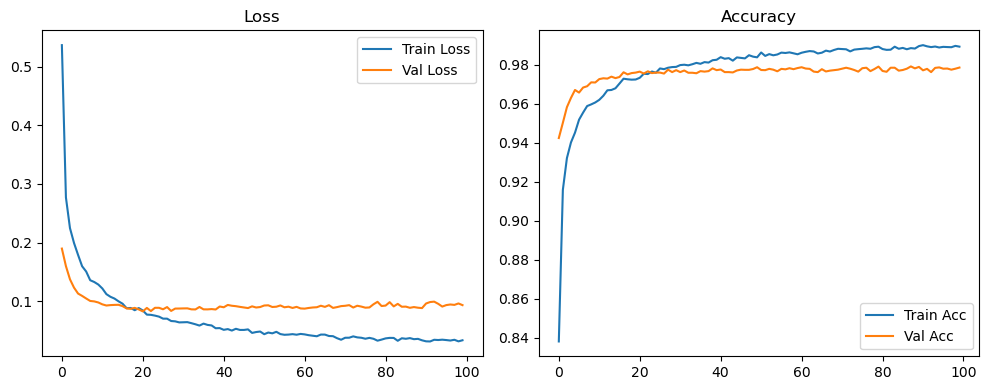

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2219, Acc: 0.9303 | Val Loss: 0.1454, Acc: 0.9559


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1029, Acc: 0.9675 | Val Loss: 0.1205, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9776 | Val Loss: 0.1104, Acc: 0.9672


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9835 | Val Loss: 0.1083, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9863 | Val Loss: 0.1265, Acc: 0.9652


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1217, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.1152, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1235, Acc: 0.9694


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.1177, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1125, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1196, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1465, Acc: 0.9681


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1289, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.1131, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.1250, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1298, Acc: 0.9729


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1613, Acc: 0.9679


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1302, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1366, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1356, Acc: 0.9743


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1513, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1322, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1346, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1229, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1399, Acc: 0.9727


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1290, Acc: 0.9724


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1215, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1313, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1392, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1387, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1349, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1396, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1379, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1268, Acc: 0.9784


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1353, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1359, Acc: 0.9750


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1361, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1237, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1407, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1213, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1463, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1238, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1263, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9736


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1272, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1239, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1336, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1380, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1105, Acc: 0.9770


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1274, Acc: 0.9772


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.1118, Acc: 0.9773


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1377, Acc: 0.9769


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1390, Acc: 0.9766


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1277, Acc: 0.9755


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1251, Acc: 0.9778


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1553, Acc: 0.9747


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1300, Acc: 0.9759


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1281, Acc: 0.9772


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1166, Acc: 0.9784


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1253, Acc: 0.9779


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1404, Acc: 0.9772


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1267, Acc: 0.9772


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1444, Acc: 0.9753


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1325, Acc: 0.9752


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1546, Acc: 0.9760


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1207, Acc: 0.9751


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1398, Acc: 0.9754


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1395, Acc: 0.9768


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1364, Acc: 0.9757


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1516, Acc: 0.9756


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1491, Acc: 0.9762


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1211, Acc: 0.9767


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1366, Acc: 0.9763


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1387, Acc: 0.9779


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1390, Acc: 0.9788


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1239, Acc: 0.9780


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1293, Acc: 0.9778


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1306, Acc: 0.9778


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1276, Acc: 0.9764


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1378, Acc: 0.9788


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1342, Acc: 0.9752


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1189, Acc: 0.9782


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1277, Acc: 0.9798


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1313, Acc: 0.9795


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1434, Acc: 0.9787


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1352, Acc: 0.9776


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1297, Acc: 0.9780


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1348, Acc: 0.9762


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1366, Acc: 0.9777


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1660, Acc: 0.9762


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1205, Acc: 0.9745


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1478, Acc: 0.9771


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1400, Acc: 0.9759


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1315, Acc: 0.9760


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1419, Acc: 0.9772


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1281, Acc: 0.9772


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1450, Acc: 0.9755


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1291, Acc: 0.9759


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9782


Final Test Loss: 0.1216 Accuracy: 0.9805


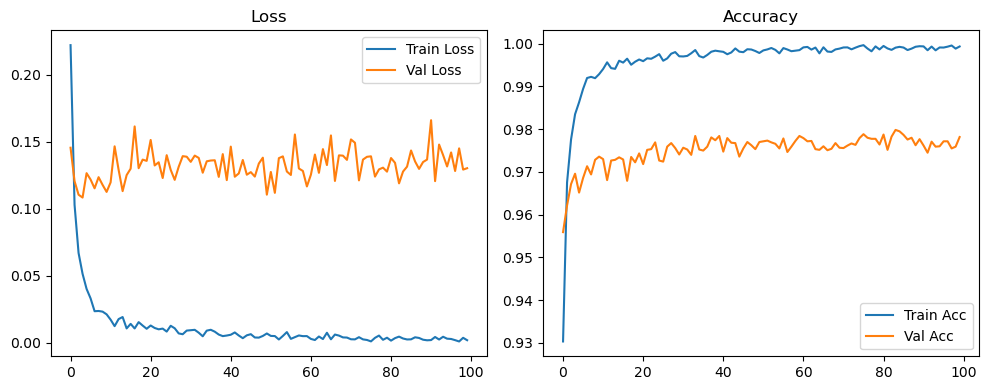

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2681, Acc: 0.9161 | Val Loss: 0.1393, Acc: 0.9580


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1423, Acc: 0.9564 | Val Loss: 0.1283, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9669 | Val Loss: 0.1169, Acc: 0.9646


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9728 | Val Loss: 0.1023, Acc: 0.9698


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9772 | Val Loss: 0.0978, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9797 | Val Loss: 0.0985, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9818 | Val Loss: 0.0949, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9834 | Val Loss: 0.0961, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.1045, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 0.1007, Acc: 0.9741


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.0952, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0986, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9873 | Val Loss: 0.1045, Acc: 0.9742


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.1034, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9894 | Val Loss: 0.1008, Acc: 0.9749


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.0999, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1074, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0953, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0983, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1054, Acc: 0.9767


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.1057, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1033, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.1068, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.1030, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1042, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1102, Acc: 0.9751


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1200, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1151, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1181, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1126, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.1117, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1000, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0994, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.1036, Acc: 0.9765


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1081, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1100, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1120, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1193, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1170, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1086, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1071, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1232, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1196, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1053, Acc: 0.9771


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1165, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1223, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1053, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.1178, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1020, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0970, Acc: 0.9790


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1145, Acc: 0.9781


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1098, Acc: 0.9776


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1153, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.1111, Acc: 0.9764


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1053, Acc: 0.9770


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1303, Acc: 0.9776


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.1066, Acc: 0.9776


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1106, Acc: 0.9781


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1017, Acc: 0.9783


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1040, Acc: 0.9775


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1104, Acc: 0.9767


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0995, Acc: 0.9791


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1033, Acc: 0.9783


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9962 | Val Loss: 0.1131, Acc: 0.9768


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1201, Acc: 0.9762


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1116, Acc: 0.9790


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1059, Acc: 0.9785


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1142, Acc: 0.9772


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1188, Acc: 0.9780


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1075, Acc: 0.9771


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1086, Acc: 0.9778


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1094, Acc: 0.9771


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1010, Acc: 0.9783


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1216, Acc: 0.9763


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1108, Acc: 0.9786


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1128, Acc: 0.9772


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1251, Acc: 0.9772


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1039, Acc: 0.9780


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1025, Acc: 0.9791


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1152, Acc: 0.9780


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1249, Acc: 0.9773


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0978, Acc: 0.9778


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1130, Acc: 0.9780


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1219, Acc: 0.9767


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1073, Acc: 0.9776


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1270, Acc: 0.9774


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1195, Acc: 0.9777


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1187, Acc: 0.9777


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1192, Acc: 0.9793


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9777


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1165, Acc: 0.9759


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1113, Acc: 0.9781


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1158, Acc: 0.9788


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1046, Acc: 0.9788


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9793


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1052, Acc: 0.9780


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1252, Acc: 0.9786


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1039, Acc: 0.9783


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1018, Acc: 0.9785


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0951, Acc: 0.9783


Final Test Loss: 0.0868 Accuracy: 0.9811


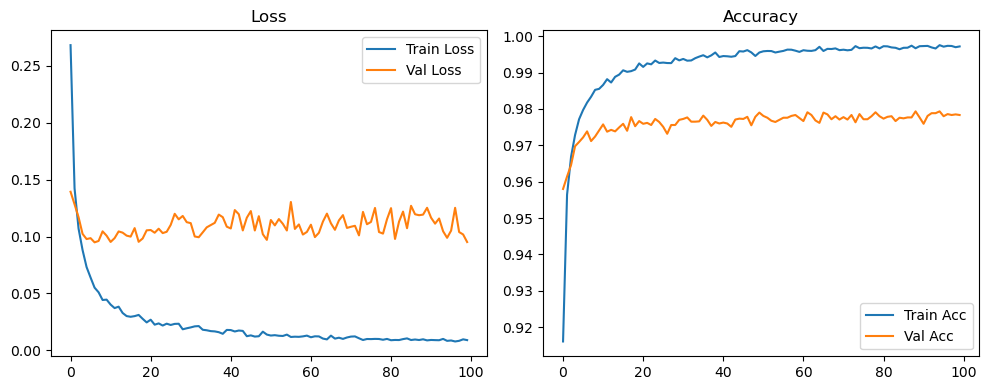

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4316, Acc: 0.8692 | Val Loss: 0.1783, Acc: 0.9465


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2471, Acc: 0.9270 | Val Loss: 0.1493, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9388 | Val Loss: 0.1269, Acc: 0.9621


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1786, Acc: 0.9474 | Val Loss: 0.1269, Acc: 0.9625


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1583, Acc: 0.9525 | Val Loss: 0.1099, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1483, Acc: 0.9559 | Val Loss: 0.1058, Acc: 0.9696


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1408, Acc: 0.9580 | Val Loss: 0.1055, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9612 | Val Loss: 0.1009, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9637 | Val Loss: 0.1031, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9646 | Val Loss: 0.1017, Acc: 0.9720


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9641 | Val Loss: 0.0982, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1080, Acc: 0.9667 | Val Loss: 0.0980, Acc: 0.9714


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9690 | Val Loss: 0.0982, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9694 | Val Loss: 0.0918, Acc: 0.9735


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0976, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9693 | Val Loss: 0.0982, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9721 | Val Loss: 0.0978, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9737 | Val Loss: 0.0925, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9755 | Val Loss: 0.0946, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9737 | Val Loss: 0.0953, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9752 | Val Loss: 0.1037, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9757 | Val Loss: 0.1034, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9760 | Val Loss: 0.1031, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9775 | Val Loss: 0.0956, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.1017, Acc: 0.9742


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.1029, Acc: 0.9750


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.1056, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.0969, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9789 | Val Loss: 0.0953, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9781 | Val Loss: 0.0950, Acc: 0.9749


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9786 | Val Loss: 0.0933, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0970, Acc: 0.9749


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9801 | Val Loss: 0.0990, Acc: 0.9747


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9789 | Val Loss: 0.0959, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9804 | Val Loss: 0.1003, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9812 | Val Loss: 0.1057, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9816 | Val Loss: 0.1017, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.0979, Acc: 0.9742


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.1011, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9808 | Val Loss: 0.0930, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9812 | Val Loss: 0.0932, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9821 | Val Loss: 0.1002, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9815 | Val Loss: 0.0990, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9820 | Val Loss: 0.0979, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9829 | Val Loss: 0.0972, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9831 | Val Loss: 0.0977, Acc: 0.9760


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.1007, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9829 | Val Loss: 0.1019, Acc: 0.9747


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9820 | Val Loss: 0.0957, Acc: 0.9761


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9837 | Val Loss: 0.1025, Acc: 0.9768


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9823 | Val Loss: 0.1026, Acc: 0.9748


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9830 | Val Loss: 0.1012, Acc: 0.9752


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9831 | Val Loss: 0.1096, Acc: 0.9749


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9832 | Val Loss: 0.0953, Acc: 0.9748


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9830 | Val Loss: 0.1097, Acc: 0.9755


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9841 | Val Loss: 0.1077, Acc: 0.9753


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9845 | Val Loss: 0.1089, Acc: 0.9753


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9824 | Val Loss: 0.0954, Acc: 0.9747


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.1166, Acc: 0.9748


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9845 | Val Loss: 0.0997, Acc: 0.9750


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9836 | Val Loss: 0.1038, Acc: 0.9752


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.1097, Acc: 0.9752


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9846 | Val Loss: 0.0993, Acc: 0.9759


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9843 | Val Loss: 0.1077, Acc: 0.9753


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9850 | Val Loss: 0.0953, Acc: 0.9752


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9841 | Val Loss: 0.1028, Acc: 0.9747


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9842 | Val Loss: 0.1019, Acc: 0.9742


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.1073, Acc: 0.9746


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9859 | Val Loss: 0.0983, Acc: 0.9754


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9848 | Val Loss: 0.0998, Acc: 0.9756


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9847 | Val Loss: 0.1104, Acc: 0.9763


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9855 | Val Loss: 0.1115, Acc: 0.9760


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9860 | Val Loss: 0.1103, Acc: 0.9754


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9855 | Val Loss: 0.0973, Acc: 0.9759


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.1078, Acc: 0.9757


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.1017, Acc: 0.9758


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9850 | Val Loss: 0.1010, Acc: 0.9758


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9848 | Val Loss: 0.0970, Acc: 0.9765


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9852 | Val Loss: 0.1139, Acc: 0.9754


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.0975, Acc: 0.9758


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9856 | Val Loss: 0.1025, Acc: 0.9748


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9856 | Val Loss: 0.0952, Acc: 0.9764


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9853 | Val Loss: 0.1091, Acc: 0.9753


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9856 | Val Loss: 0.1082, Acc: 0.9756


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9858 | Val Loss: 0.1096, Acc: 0.9756


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9866 | Val Loss: 0.1050, Acc: 0.9748


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.0987, Acc: 0.9761


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.0956, Acc: 0.9766


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9865 | Val Loss: 0.1094, Acc: 0.9753


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.1006, Acc: 0.9750


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9856 | Val Loss: 0.1036, Acc: 0.9738


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9840 | Val Loss: 0.1027, Acc: 0.9748


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9865 | Val Loss: 0.1079, Acc: 0.9763


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9852 | Val Loss: 0.1115, Acc: 0.9752


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9862 | Val Loss: 0.1068, Acc: 0.9759


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9866 | Val Loss: 0.0998, Acc: 0.9755


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9857 | Val Loss: 0.1029, Acc: 0.9737


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9858 | Val Loss: 0.1058, Acc: 0.9748


Final Test Loss: 0.0954 Accuracy: 0.9777


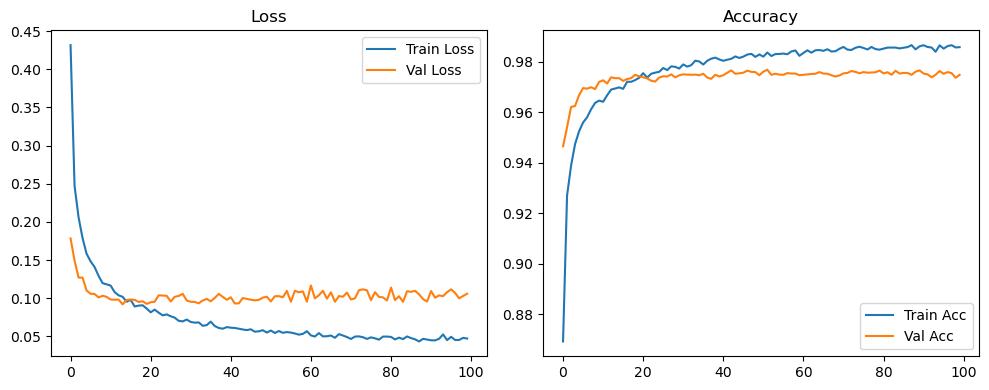

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2219, Acc: 0.9303 | Val Loss: 0.1454, Acc: 0.9559


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1029, Acc: 0.9675 | Val Loss: 0.1205, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9776 | Val Loss: 0.1104, Acc: 0.9672


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9835 | Val Loss: 0.1083, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9863 | Val Loss: 0.1265, Acc: 0.9652


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1217, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.1152, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1235, Acc: 0.9694


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.1177, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1125, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1196, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1465, Acc: 0.9681


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1289, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.1131, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.1250, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1298, Acc: 0.9729


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1613, Acc: 0.9679


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1302, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1366, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1356, Acc: 0.9743


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1513, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1322, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1346, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1229, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1399, Acc: 0.9727


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1290, Acc: 0.9724


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1215, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1313, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1392, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1387, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1349, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1396, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1379, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1268, Acc: 0.9784


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1353, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1359, Acc: 0.9750


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1361, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1237, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1407, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1213, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1463, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1238, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1263, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9736


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1272, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1239, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1336, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1380, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1105, Acc: 0.9770


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1065, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1069, Acc: 0.9801


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1107, Acc: 0.9801


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1133, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1118, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1185, Acc: 0.9796


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1213, Acc: 0.9799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1274, Acc: 0.9804


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1267, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1275, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1341, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1540, Acc: 0.9771


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1398, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1575, Acc: 0.9736


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1345, Acc: 0.9779


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1337, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1344, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1380, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1409, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1596, Acc: 0.9761


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1341, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1447, Acc: 0.9759


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1399, Acc: 0.9776


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1147, Acc: 0.9783


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1342, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1281, Acc: 0.9789


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1366, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1389, Acc: 0.9763


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1298, Acc: 0.9777


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1345, Acc: 0.9785


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1357, Acc: 0.9784


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1375, Acc: 0.9787


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1404, Acc: 0.9778


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1382, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1423, Acc: 0.9787


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1420, Acc: 0.9787


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1435, Acc: 0.9786


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1433, Acc: 0.9782


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1533, Acc: 0.9781


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1467, Acc: 0.9786


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1510, Acc: 0.9784


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1488, Acc: 0.9782


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1507, Acc: 0.9778


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1532, Acc: 0.9783


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1573, Acc: 0.9765


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1539, Acc: 0.9779


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1502, Acc: 0.9777


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1493, Acc: 0.9784


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1489, Acc: 0.9785


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1506, Acc: 0.9785


Final Test Loss: 0.1351 Accuracy: 0.9805


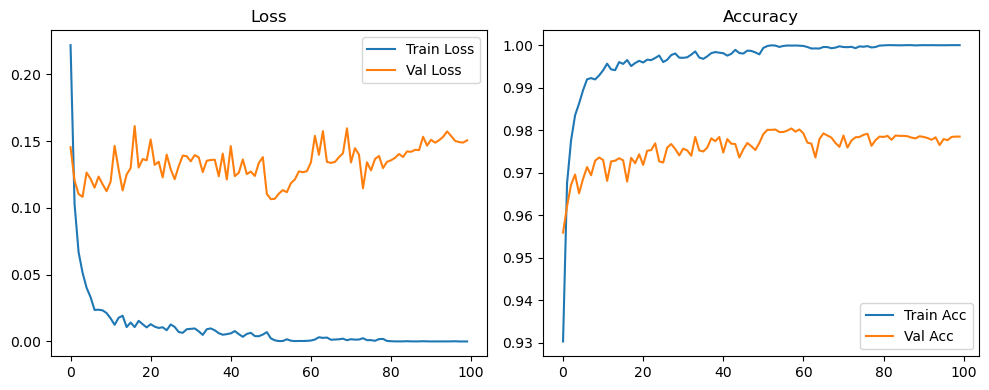

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2681, Acc: 0.9161 | Val Loss: 0.1393, Acc: 0.9580


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1423, Acc: 0.9564 | Val Loss: 0.1283, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9669 | Val Loss: 0.1169, Acc: 0.9646


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9728 | Val Loss: 0.1023, Acc: 0.9698


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9772 | Val Loss: 0.0978, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9797 | Val Loss: 0.0985, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9818 | Val Loss: 0.0949, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9834 | Val Loss: 0.0961, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.1045, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 0.1007, Acc: 0.9741


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.0952, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0986, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9873 | Val Loss: 0.1045, Acc: 0.9742


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.1034, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9894 | Val Loss: 0.1008, Acc: 0.9749


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.0999, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1074, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0953, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0983, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1054, Acc: 0.9767


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.1057, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1033, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.1068, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.1030, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1042, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1102, Acc: 0.9751


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1200, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1151, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1181, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1126, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.1117, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1000, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0994, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.1036, Acc: 0.9765


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1081, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1100, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1120, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1193, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1170, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1086, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1071, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1232, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1196, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1053, Acc: 0.9771


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1165, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1223, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1053, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.1178, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1020, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0970, Acc: 0.9790


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1121, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1067, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1061, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1084, Acc: 0.9800


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1209, Acc: 0.9791


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1186, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1113, Acc: 0.9783


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1155, Acc: 0.9788


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1132, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1128, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1217, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1147, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1072, Acc: 0.9796


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1133, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1261, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1183, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1087, Acc: 0.9784


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1147, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1120, Acc: 0.9789


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1130, Acc: 0.9792


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1167, Acc: 0.9791


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1188, Acc: 0.9786


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1228, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1265, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1192, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1071, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1229, Acc: 0.9786


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1121, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1274, Acc: 0.9777


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1143, Acc: 0.9792


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1148, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1168, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1205, Acc: 0.9799


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1242, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1190, Acc: 0.9805


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1256, Acc: 0.9791


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1191, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1161, Acc: 0.9807


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1221, Acc: 0.9796


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1217, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1225, Acc: 0.9797


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1191, Acc: 0.9810


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1256, Acc: 0.9812


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1292, Acc: 0.9807


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1306, Acc: 0.9805


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1263, Acc: 0.9799


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1196, Acc: 0.9806


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1287, Acc: 0.9799


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1275, Acc: 0.9797


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1302, Acc: 0.9801


Final Test Loss: 0.1153 Accuracy: 0.9823


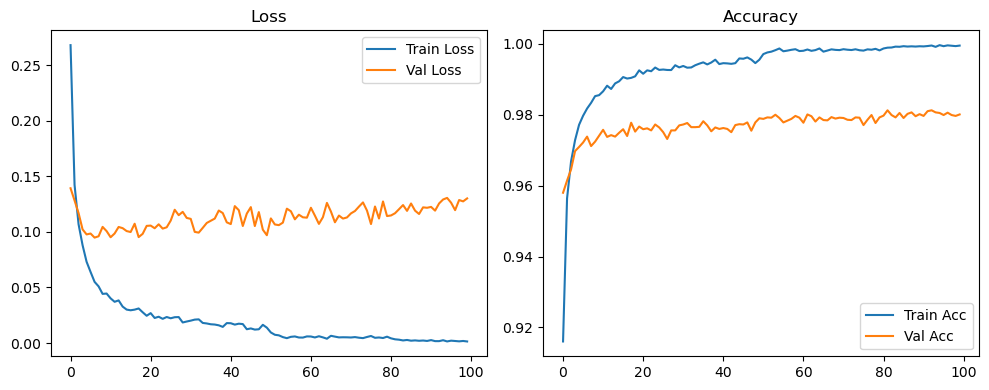

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4316, Acc: 0.8692 | Val Loss: 0.1783, Acc: 0.9465


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2471, Acc: 0.9270 | Val Loss: 0.1493, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9388 | Val Loss: 0.1269, Acc: 0.9621


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1786, Acc: 0.9474 | Val Loss: 0.1269, Acc: 0.9625


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1583, Acc: 0.9525 | Val Loss: 0.1099, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1483, Acc: 0.9559 | Val Loss: 0.1058, Acc: 0.9696


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1408, Acc: 0.9580 | Val Loss: 0.1055, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9612 | Val Loss: 0.1009, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9637 | Val Loss: 0.1031, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9646 | Val Loss: 0.1017, Acc: 0.9720


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9641 | Val Loss: 0.0982, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1080, Acc: 0.9667 | Val Loss: 0.0980, Acc: 0.9714


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9690 | Val Loss: 0.0982, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9694 | Val Loss: 0.0918, Acc: 0.9735


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0976, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9693 | Val Loss: 0.0982, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9721 | Val Loss: 0.0978, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9737 | Val Loss: 0.0925, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9755 | Val Loss: 0.0946, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9737 | Val Loss: 0.0953, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9752 | Val Loss: 0.1037, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9757 | Val Loss: 0.1034, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9760 | Val Loss: 0.1031, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9775 | Val Loss: 0.0956, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.1017, Acc: 0.9742


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.1029, Acc: 0.9750


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.1056, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.0969, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9789 | Val Loss: 0.0953, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9781 | Val Loss: 0.0950, Acc: 0.9749


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9786 | Val Loss: 0.0933, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0970, Acc: 0.9749


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9801 | Val Loss: 0.0990, Acc: 0.9747


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9789 | Val Loss: 0.0959, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9804 | Val Loss: 0.1003, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9812 | Val Loss: 0.1057, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9816 | Val Loss: 0.1017, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.0979, Acc: 0.9742


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.1011, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9808 | Val Loss: 0.0930, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9812 | Val Loss: 0.0932, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9821 | Val Loss: 0.1002, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9815 | Val Loss: 0.0990, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9820 | Val Loss: 0.0979, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9829 | Val Loss: 0.0972, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9831 | Val Loss: 0.0977, Acc: 0.9760


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.1007, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9829 | Val Loss: 0.1019, Acc: 0.9747


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9843 | Val Loss: 0.0967, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9868 | Val Loss: 0.1027, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.1068, Acc: 0.9759


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0986, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9877 | Val Loss: 0.1046, Acc: 0.9773


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0956, Acc: 0.9760


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9888 | Val Loss: 0.1044, Acc: 0.9751


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.1019, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.1060, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.1013, Acc: 0.9779


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.1129, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.1054, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.1067, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.1087, Acc: 0.9763


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1095, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.1131, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.1084, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9897 | Val Loss: 0.1033, Acc: 0.9766


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.1103, Acc: 0.9764


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9900 | Val Loss: 0.1053, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9910 | Val Loss: 0.1059, Acc: 0.9767


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.1097, Acc: 0.9763


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.1124, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9910 | Val Loss: 0.1097, Acc: 0.9769


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1081, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.1077, Acc: 0.9768


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1045, Acc: 0.9772


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9912 | Val Loss: 0.1132, Acc: 0.9762


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1112, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.1104, Acc: 0.9766


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9914 | Val Loss: 0.1071, Acc: 0.9769


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1100, Acc: 0.9771


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.1104, Acc: 0.9765


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9932 | Val Loss: 0.1143, Acc: 0.9778


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1092, Acc: 0.9766


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.1117, Acc: 0.9768


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.1180, Acc: 0.9758


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1089, Acc: 0.9767


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.1108, Acc: 0.9766


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1188, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9938 | Val Loss: 0.1160, Acc: 0.9766


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9944 | Val Loss: 0.1177, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.1152, Acc: 0.9755


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9930 | Val Loss: 0.1100, Acc: 0.9768


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1141, Acc: 0.9760


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1122, Acc: 0.9767


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.1179, Acc: 0.9768


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9943 | Val Loss: 0.1189, Acc: 0.9767


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1182, Acc: 0.9764


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.1173, Acc: 0.9774


Final Test Loss: 0.1084 Accuracy: 0.9804


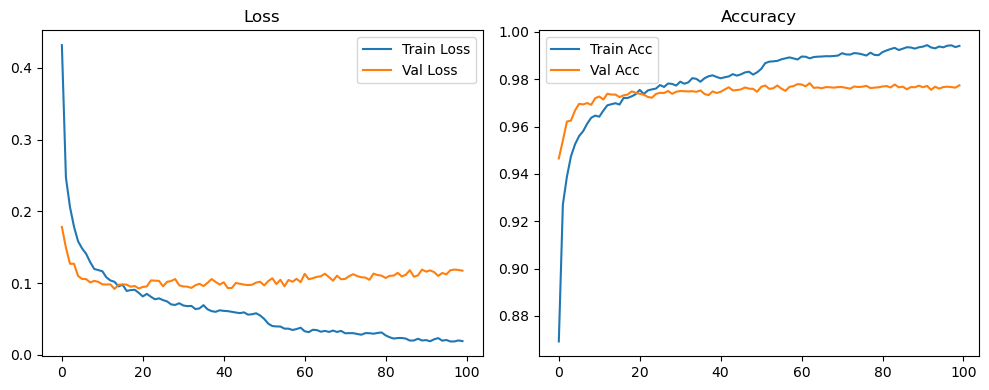

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2219, Acc: 0.9303 | Val Loss: 0.1454, Acc: 0.9559


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1029, Acc: 0.9675 | Val Loss: 0.1205, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9776 | Val Loss: 0.1104, Acc: 0.9672


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9835 | Val Loss: 0.1083, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9863 | Val Loss: 0.1265, Acc: 0.9652


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1217, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.1152, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1235, Acc: 0.9694


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.1177, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1125, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1196, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1465, Acc: 0.9681


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1289, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.1131, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.1250, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1298, Acc: 0.9729


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1613, Acc: 0.9679


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1302, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1366, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1356, Acc: 0.9743


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1513, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1322, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1346, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1229, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1399, Acc: 0.9727


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1290, Acc: 0.9724


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1215, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1313, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1392, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1387, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1349, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1396, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1379, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1268, Acc: 0.9784


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1353, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1359, Acc: 0.9750


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1361, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1237, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1407, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1213, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1463, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1238, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1263, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9736


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1272, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1239, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1336, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1380, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1105, Acc: 0.9770


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1065, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1069, Acc: 0.9801


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1107, Acc: 0.9801


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1133, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1118, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1185, Acc: 0.9796


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1213, Acc: 0.9799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1274, Acc: 0.9804


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1267, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1275, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1341, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1540, Acc: 0.9771


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1398, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1575, Acc: 0.9736


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1345, Acc: 0.9779


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1337, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1344, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1380, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1409, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1596, Acc: 0.9761


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1341, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1447, Acc: 0.9759


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1399, Acc: 0.9776


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1147, Acc: 0.9783


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1342, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1281, Acc: 0.9789


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1366, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1389, Acc: 0.9763


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1298, Acc: 0.9777


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1345, Acc: 0.9785


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1343, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1351, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1374, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1349, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1387, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1378, Acc: 0.9781


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1385, Acc: 0.9786


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1385, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1427, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1414, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1432, Acc: 0.9781


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1428, Acc: 0.9783


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1438, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1432, Acc: 0.9785


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1445, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1437, Acc: 0.9786


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1460, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1454, Acc: 0.9780


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1448, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1457, Acc: 0.9785


Final Test Loss: 0.1318 Accuracy: 0.9802


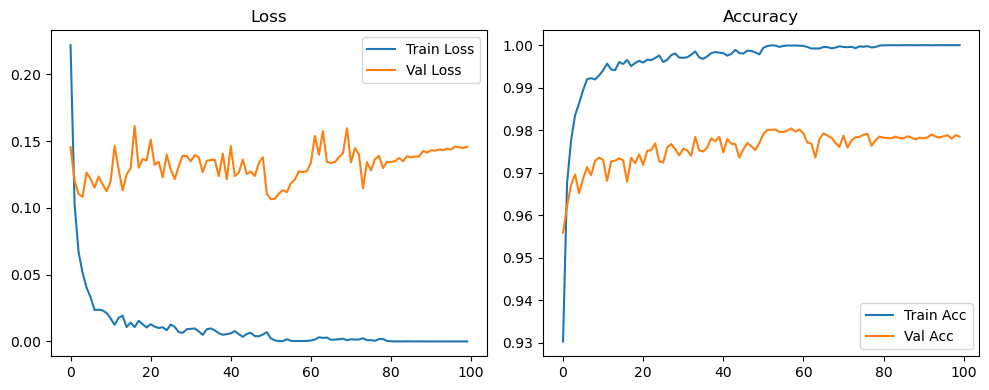

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2681, Acc: 0.9161 | Val Loss: 0.1393, Acc: 0.9580


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1423, Acc: 0.9564 | Val Loss: 0.1283, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9669 | Val Loss: 0.1169, Acc: 0.9646


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9728 | Val Loss: 0.1023, Acc: 0.9698


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9772 | Val Loss: 0.0978, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9797 | Val Loss: 0.0985, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9818 | Val Loss: 0.0949, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9834 | Val Loss: 0.0961, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.1045, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 0.1007, Acc: 0.9741


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.0952, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0986, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9873 | Val Loss: 0.1045, Acc: 0.9742


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.1034, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9894 | Val Loss: 0.1008, Acc: 0.9749


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.0999, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1074, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0953, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0983, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1054, Acc: 0.9767


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.1057, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1033, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.1068, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.1030, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1042, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1102, Acc: 0.9751


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1200, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1151, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1181, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1126, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.1117, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1000, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0994, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.1036, Acc: 0.9765


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1081, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1100, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1120, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1193, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1170, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1086, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1071, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1232, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1196, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1053, Acc: 0.9771


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1165, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1223, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1053, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.1178, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1020, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0970, Acc: 0.9790


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1121, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1067, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1061, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1084, Acc: 0.9800


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1209, Acc: 0.9791


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1186, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1113, Acc: 0.9783


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1155, Acc: 0.9788


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1132, Acc: 0.9797


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1128, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1217, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1147, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1072, Acc: 0.9796


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1133, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1261, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1183, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1087, Acc: 0.9784


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1147, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1120, Acc: 0.9789


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1130, Acc: 0.9792


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1167, Acc: 0.9791


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1188, Acc: 0.9786


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1228, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1265, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1192, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1071, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1229, Acc: 0.9786


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1121, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1274, Acc: 0.9777


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1143, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1132, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1162, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1176, Acc: 0.9797


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1202, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1180, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1215, Acc: 0.9790


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1182, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1169, Acc: 0.9795


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1196, Acc: 0.9800


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1186, Acc: 0.9805


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1206, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1190, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1220, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1254, Acc: 0.9803


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1268, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1253, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1237, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1265, Acc: 0.9803


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1244, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1236, Acc: 0.9802


Final Test Loss: 0.1057 Accuracy: 0.9829


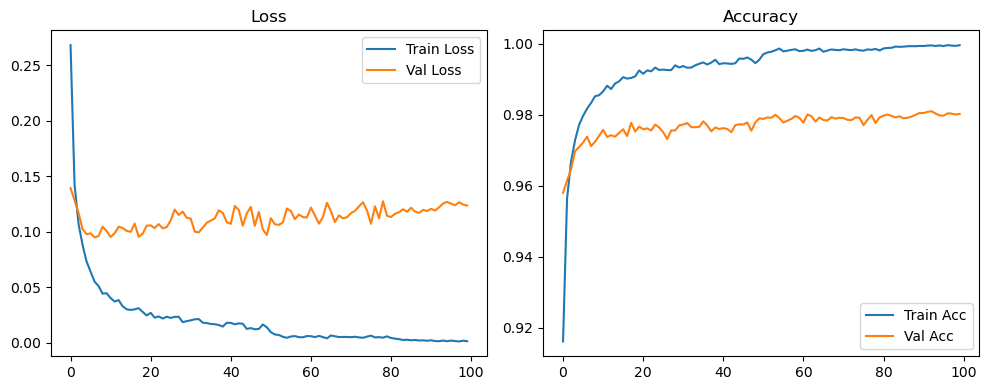

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4316, Acc: 0.8692 | Val Loss: 0.1783, Acc: 0.9465


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2471, Acc: 0.9270 | Val Loss: 0.1493, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9388 | Val Loss: 0.1269, Acc: 0.9621


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1786, Acc: 0.9474 | Val Loss: 0.1269, Acc: 0.9625


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1583, Acc: 0.9525 | Val Loss: 0.1099, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1483, Acc: 0.9559 | Val Loss: 0.1058, Acc: 0.9696


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1408, Acc: 0.9580 | Val Loss: 0.1055, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9612 | Val Loss: 0.1009, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9637 | Val Loss: 0.1031, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9646 | Val Loss: 0.1017, Acc: 0.9720


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9641 | Val Loss: 0.0982, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1080, Acc: 0.9667 | Val Loss: 0.0980, Acc: 0.9714


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9690 | Val Loss: 0.0982, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9694 | Val Loss: 0.0918, Acc: 0.9735


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0976, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9693 | Val Loss: 0.0982, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9721 | Val Loss: 0.0978, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9737 | Val Loss: 0.0925, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9755 | Val Loss: 0.0946, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9737 | Val Loss: 0.0953, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9752 | Val Loss: 0.1037, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9757 | Val Loss: 0.1034, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9760 | Val Loss: 0.1031, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9775 | Val Loss: 0.0956, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.1017, Acc: 0.9742


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.1029, Acc: 0.9750


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.1056, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.0969, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9789 | Val Loss: 0.0953, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9781 | Val Loss: 0.0950, Acc: 0.9749


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9786 | Val Loss: 0.0933, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0970, Acc: 0.9749


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9801 | Val Loss: 0.0990, Acc: 0.9747


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9789 | Val Loss: 0.0959, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9804 | Val Loss: 0.1003, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9812 | Val Loss: 0.1057, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9816 | Val Loss: 0.1017, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.0979, Acc: 0.9742


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.1011, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9808 | Val Loss: 0.0930, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9812 | Val Loss: 0.0932, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9821 | Val Loss: 0.1002, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9815 | Val Loss: 0.0990, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9820 | Val Loss: 0.0979, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9829 | Val Loss: 0.0972, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9831 | Val Loss: 0.0977, Acc: 0.9760


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.1007, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9829 | Val Loss: 0.1019, Acc: 0.9747


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9843 | Val Loss: 0.0967, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9868 | Val Loss: 0.1027, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.1068, Acc: 0.9759


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0986, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9877 | Val Loss: 0.1046, Acc: 0.9773


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0956, Acc: 0.9760


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9888 | Val Loss: 0.1044, Acc: 0.9751


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.1019, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.1060, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.1013, Acc: 0.9779


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.1129, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.1054, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.1067, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.1087, Acc: 0.9763


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1095, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.1131, Acc: 0.9762


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.1084, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9897 | Val Loss: 0.1033, Acc: 0.9766


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.1103, Acc: 0.9764


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9900 | Val Loss: 0.1053, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9910 | Val Loss: 0.1059, Acc: 0.9767


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.1097, Acc: 0.9763


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.1124, Acc: 0.9760


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9910 | Val Loss: 0.1097, Acc: 0.9769


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1081, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9905 | Val Loss: 0.1077, Acc: 0.9768


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1045, Acc: 0.9772


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9912 | Val Loss: 0.1132, Acc: 0.9762


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1112, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.1104, Acc: 0.9766


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 0.1087, Acc: 0.9766


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9925 | Val Loss: 0.1096, Acc: 0.9766


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.1104, Acc: 0.9770


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1124, Acc: 0.9771


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.1100, Acc: 0.9769


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.1089, Acc: 0.9774


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1151, Acc: 0.9770


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1110, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.1099, Acc: 0.9772


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1139, Acc: 0.9774


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.1129, Acc: 0.9772


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.1119, Acc: 0.9773


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1141, Acc: 0.9767


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1104, Acc: 0.9774


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1132, Acc: 0.9765


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1128, Acc: 0.9769


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.1133, Acc: 0.9768


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9949 | Val Loss: 0.1167, Acc: 0.9776


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1145, Acc: 0.9777


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.1168, Acc: 0.9772


Final Test Loss: 0.1068 Accuracy: 0.9806


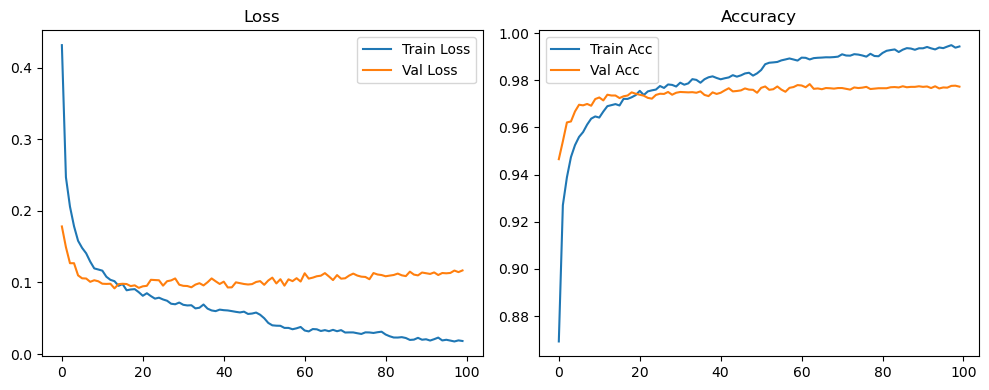

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2219, Acc: 0.9303 | Val Loss: 0.1454, Acc: 0.9559


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1029, Acc: 0.9675 | Val Loss: 0.1205, Acc: 0.9622


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9776 | Val Loss: 0.1104, Acc: 0.9672


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9835 | Val Loss: 0.1083, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9863 | Val Loss: 0.1265, Acc: 0.9652


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.1217, Acc: 0.9686


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.1152, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1235, Acc: 0.9694


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.1177, Acc: 0.9728


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1125, Acc: 0.9736


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1196, Acc: 0.9730


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1465, Acc: 0.9681


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1289, Acc: 0.9727


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.1131, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.1250, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1298, Acc: 0.9729


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1613, Acc: 0.9679


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1302, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1366, Acc: 0.9722


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1356, Acc: 0.9743


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1513, Acc: 0.9718


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1322, Acc: 0.9752


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1346, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.1229, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1399, Acc: 0.9727


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1290, Acc: 0.9724


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1215, Acc: 0.9759


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1313, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1392, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1387, Acc: 0.9741


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1349, Acc: 0.9757


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1396, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1379, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1268, Acc: 0.9784


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1353, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1359, Acc: 0.9750


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1361, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1237, Acc: 0.9781


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1407, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1213, Acc: 0.9784


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1463, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1238, Acc: 0.9779


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1263, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9736


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1272, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1239, Acc: 0.9770


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1336, Acc: 0.9762


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1380, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1105, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1040, Acc: 0.9797


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1080, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1110, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1123, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1122, Acc: 0.9796


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1200, Acc: 0.9791


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1240, Acc: 0.9791


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1247, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1240, Acc: 0.9793


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1252, Acc: 0.9795


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1289, Acc: 0.9792


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1272, Acc: 0.9799


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1278, Acc: 0.9800


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1273, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1289, Acc: 0.9799


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1281, Acc: 0.9802


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1339, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1353, Acc: 0.9790


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1401, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1479, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1452, Acc: 0.9787


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1436, Acc: 0.9784


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1446, Acc: 0.9789


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1405, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1438, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1453, Acc: 0.9787


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1441, Acc: 0.9799


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1457, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1454, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1464, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1489, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1450, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1554, Acc: 0.9795


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1550, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1531, Acc: 0.9793


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1510, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1519, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1514, Acc: 0.9799


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1503, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1482, Acc: 0.9795


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1500, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1518, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1571, Acc: 0.9795


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1526, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1529, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1502, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1509, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1516, Acc: 0.9806


Final Test Loss: 0.1429 Accuracy: 0.9813


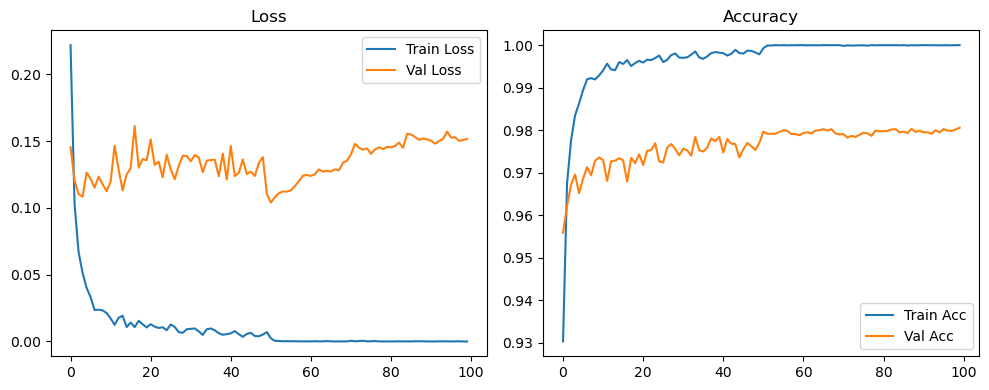

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2681, Acc: 0.9161 | Val Loss: 0.1393, Acc: 0.9580


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1423, Acc: 0.9564 | Val Loss: 0.1283, Acc: 0.9614


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9669 | Val Loss: 0.1169, Acc: 0.9646


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9728 | Val Loss: 0.1023, Acc: 0.9698


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9772 | Val Loss: 0.0978, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9797 | Val Loss: 0.0985, Acc: 0.9722


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9818 | Val Loss: 0.0949, Acc: 0.9738


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9834 | Val Loss: 0.0961, Acc: 0.9712


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9852 | Val Loss: 0.1045, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9855 | Val Loss: 0.1007, Acc: 0.9741


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9866 | Val Loss: 0.0952, Acc: 0.9758


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0986, Acc: 0.9738


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9873 | Val Loss: 0.1045, Acc: 0.9742


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.1034, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9894 | Val Loss: 0.1008, Acc: 0.9749


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9906 | Val Loss: 0.0999, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1074, Acc: 0.9740


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0953, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0983, Acc: 0.9752


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1054, Acc: 0.9767


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.1057, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1033, Acc: 0.9762


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.1068, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9933 | Val Loss: 0.1030, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1042, Acc: 0.9764


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1102, Acc: 0.9751


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1200, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1151, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1181, Acc: 0.9756


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1126, Acc: 0.9770


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.1117, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1000, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0994, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.1036, Acc: 0.9765


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.1081, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1100, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1120, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1193, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1170, Acc: 0.9764


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1086, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1071, Acc: 0.9762


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1232, Acc: 0.9760


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1196, Acc: 0.9751


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1053, Acc: 0.9771


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1165, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1223, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1053, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.1178, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1020, Acc: 0.9778


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0970, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0992, Acc: 0.9801


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1030, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1044, Acc: 0.9806


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1091, Acc: 0.9800


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1125, Acc: 0.9799


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1105, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1099, Acc: 0.9811


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1118, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1155, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1171, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1205, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1136, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1141, Acc: 0.9807


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1242, Acc: 0.9787


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1201, Acc: 0.9802


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1220, Acc: 0.9804


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1192, Acc: 0.9791


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1141, Acc: 0.9798


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1168, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1206, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1195, Acc: 0.9795


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1225, Acc: 0.9797


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1162, Acc: 0.9807


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1180, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1176, Acc: 0.9805


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1258, Acc: 0.9798


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1225, Acc: 0.9804


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1212, Acc: 0.9793


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1203, Acc: 0.9803


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1196, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1217, Acc: 0.9805


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1268, Acc: 0.9801


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1256, Acc: 0.9804


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1306, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1267, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1276, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1257, Acc: 0.9801


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1222, Acc: 0.9805


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1291, Acc: 0.9801


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1248, Acc: 0.9807


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1304, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1261, Acc: 0.9800


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1300, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1301, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1297, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1308, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1317, Acc: 0.9805


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1299, Acc: 0.9806


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1282, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1267, Acc: 0.9808


Final Test Loss: 0.1152 Accuracy: 0.9833


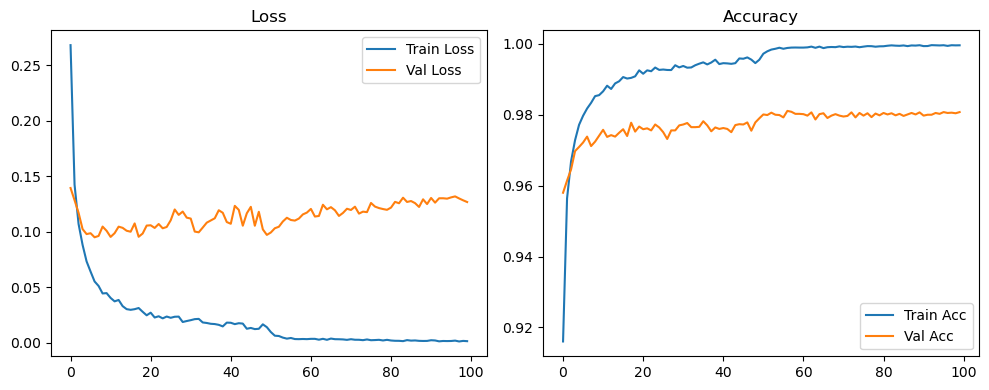

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4316, Acc: 0.8692 | Val Loss: 0.1783, Acc: 0.9465


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2471, Acc: 0.9270 | Val Loss: 0.1493, Acc: 0.9541


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2060, Acc: 0.9388 | Val Loss: 0.1269, Acc: 0.9621


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1786, Acc: 0.9474 | Val Loss: 0.1269, Acc: 0.9625


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1583, Acc: 0.9525 | Val Loss: 0.1099, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1483, Acc: 0.9559 | Val Loss: 0.1058, Acc: 0.9696


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1408, Acc: 0.9580 | Val Loss: 0.1055, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1292, Acc: 0.9612 | Val Loss: 0.1009, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9637 | Val Loss: 0.1031, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1181, Acc: 0.9646 | Val Loss: 0.1017, Acc: 0.9720


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9641 | Val Loss: 0.0982, Acc: 0.9727


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1080, Acc: 0.9667 | Val Loss: 0.0980, Acc: 0.9714


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9690 | Val Loss: 0.0982, Acc: 0.9738


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9694 | Val Loss: 0.0918, Acc: 0.9735


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9699 | Val Loss: 0.0976, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9693 | Val Loss: 0.0982, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9721 | Val Loss: 0.0978, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0907, Acc: 0.9728 | Val Loss: 0.0960, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9737 | Val Loss: 0.0925, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9755 | Val Loss: 0.0946, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9737 | Val Loss: 0.0953, Acc: 0.9734


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0809, Acc: 0.9752 | Val Loss: 0.1037, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9757 | Val Loss: 0.1034, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0787, Acc: 0.9760 | Val Loss: 0.1031, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9775 | Val Loss: 0.0956, Acc: 0.9742


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9767 | Val Loss: 0.1017, Acc: 0.9742


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.1029, Acc: 0.9750


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.1056, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.0969, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9789 | Val Loss: 0.0953, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9781 | Val Loss: 0.0950, Acc: 0.9749


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9786 | Val Loss: 0.0933, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9804 | Val Loss: 0.0970, Acc: 0.9749


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9801 | Val Loss: 0.0990, Acc: 0.9747


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9789 | Val Loss: 0.0959, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9804 | Val Loss: 0.1003, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9812 | Val Loss: 0.1057, Acc: 0.9732


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9816 | Val Loss: 0.1017, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9809 | Val Loss: 0.0979, Acc: 0.9742


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9804 | Val Loss: 0.1011, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9808 | Val Loss: 0.0930, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9812 | Val Loss: 0.0932, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9821 | Val Loss: 0.1002, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9815 | Val Loss: 0.0990, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9820 | Val Loss: 0.0979, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9829 | Val Loss: 0.0972, Acc: 0.9765


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9831 | Val Loss: 0.0977, Acc: 0.9760


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9819 | Val Loss: 0.1007, Acc: 0.9759


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9829 | Val Loss: 0.1019, Acc: 0.9747


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 0.0978, Acc: 0.9771


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9866 | Val Loss: 0.1013, Acc: 0.9769


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.1005, Acc: 0.9766


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9887 | Val Loss: 0.0983, Acc: 0.9770


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.0999, Acc: 0.9774


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1007, Acc: 0.9774


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9901 | Val Loss: 0.1030, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.1064, Acc: 0.9767


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1030, Acc: 0.9769


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.1045, Acc: 0.9774


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1110, Acc: 0.9771


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1053, Acc: 0.9771


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.1040, Acc: 0.9773


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.1072, Acc: 0.9778


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1064, Acc: 0.9766


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.1034, Acc: 0.9773


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1067, Acc: 0.9775


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.1013, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.1089, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.1090, Acc: 0.9769


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.1109, Acc: 0.9776


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.1105, Acc: 0.9773


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1135, Acc: 0.9768


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.1087, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1105, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9927 | Val Loss: 0.1139, Acc: 0.9777


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9931 | Val Loss: 0.1118, Acc: 0.9772


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1110, Acc: 0.9771


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9929 | Val Loss: 0.1096, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.1091, Acc: 0.9776


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1116, Acc: 0.9774


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1121, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.1131, Acc: 0.9776


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9939 | Val Loss: 0.1152, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.1130, Acc: 0.9776


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.1109, Acc: 0.9777


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.1131, Acc: 0.9773


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9945 | Val Loss: 0.1110, Acc: 0.9785


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.1118, Acc: 0.9781


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.1121, Acc: 0.9774


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1135, Acc: 0.9774


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.1118, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.1159, Acc: 0.9770


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.1098, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.1158, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1133, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1150, Acc: 0.9776


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1171, Acc: 0.9777


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.1147, Acc: 0.9776


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.1173, Acc: 0.9774


Final Test Loss: 0.1110 Accuracy: 0.9803


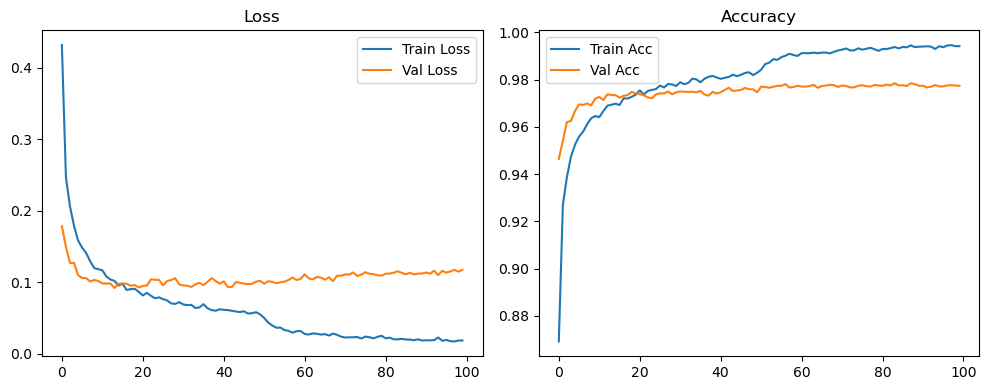

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2140, Acc: 0.9327 | Val Loss: 0.1359, Acc: 0.9584


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9696 | Val Loss: 0.1133, Acc: 0.9642


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9806 | Val Loss: 0.1142, Acc: 0.9653


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.1089, Acc: 0.9709


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.1132, Acc: 0.9696


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9904 | Val Loss: 0.1232, Acc: 0.9696


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.1199, Acc: 0.9696


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.1114, Acc: 0.9730


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1092, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1125, Acc: 0.9742


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1161, Acc: 0.9736


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.1170, Acc: 0.9752


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1292, Acc: 0.9733


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1249, Acc: 0.9747


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1174, Acc: 0.9746


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1050, Acc: 0.9774


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1166, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1194, Acc: 0.9743


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1093, Acc: 0.9761


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1241, Acc: 0.9746


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1251, Acc: 0.9749


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1265, Acc: 0.9736


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1225, Acc: 0.9754


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1239, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1287, Acc: 0.9740


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1298, Acc: 0.9733


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1231, Acc: 0.9753


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1291, Acc: 0.9744


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1277, Acc: 0.9760


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1376, Acc: 0.9756


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1313, Acc: 0.9752


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9735


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1281, Acc: 0.9752


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1239, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1475, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1298, Acc: 0.9751


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1208, Acc: 0.9783


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1295, Acc: 0.9773


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1340, Acc: 0.9766


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1415, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1549, Acc: 0.9718


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1408, Acc: 0.9735


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1286, Acc: 0.9760


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1272, Acc: 0.9752


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1323, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1226, Acc: 0.9778


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1243, Acc: 0.9767


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1363, Acc: 0.9766


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1400, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1665, Acc: 0.9730


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1367, Acc: 0.9757


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1318, Acc: 0.9755


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1268, Acc: 0.9774


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1230, Acc: 0.9771


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1419, Acc: 0.9757


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1461, Acc: 0.9750


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1573, Acc: 0.9748


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1373, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1315, Acc: 0.9772


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1288, Acc: 0.9781


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1429, Acc: 0.9752


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1386, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1335, Acc: 0.9781


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1283, Acc: 0.9785


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1327, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1446, Acc: 0.9755


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1397, Acc: 0.9769


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1492, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1387, Acc: 0.9769


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1425, Acc: 0.9764


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1376, Acc: 0.9779


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1528, Acc: 0.9750


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1252, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1217, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1269, Acc: 0.9797


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1338, Acc: 0.9794


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1471, Acc: 0.9764


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1479, Acc: 0.9782


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1682, Acc: 0.9742


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1634, Acc: 0.9751


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1356, Acc: 0.9775


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1292, Acc: 0.9782


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1375, Acc: 0.9782


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1418, Acc: 0.9781


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1280, Acc: 0.9788


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1237, Acc: 0.9784


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1456, Acc: 0.9763


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1560, Acc: 0.9767


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.1440, Acc: 0.9747


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1195, Acc: 0.9785


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1320, Acc: 0.9778


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1415, Acc: 0.9775


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1429, Acc: 0.9769


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1323, Acc: 0.9768


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1379, Acc: 0.9776


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1443, Acc: 0.9775


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1408, Acc: 0.9770


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1514, Acc: 0.9756


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1416, Acc: 0.9774


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1367, Acc: 0.9766


Final Test Loss: 0.1364 Accuracy: 0.9779


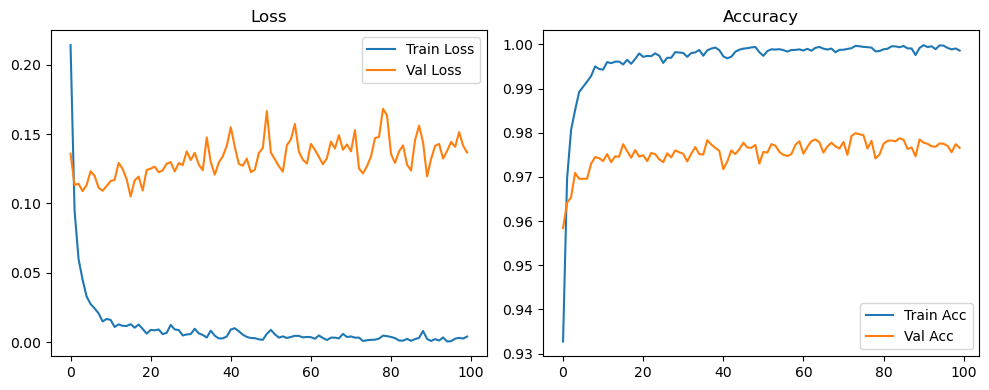

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2652, Acc: 0.9187 | Val Loss: 0.1486, Acc: 0.9557


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1364, Acc: 0.9576 | Val Loss: 0.1159, Acc: 0.9637


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1014, Acc: 0.9688 | Val Loss: 0.0956, Acc: 0.9707


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.1046, Acc: 0.9683


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9777 | Val Loss: 0.0949, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9819 | Val Loss: 0.0941, Acc: 0.9735


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9836 | Val Loss: 0.1012, Acc: 0.9712


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9854 | Val Loss: 0.0950, Acc: 0.9729


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9862 | Val Loss: 0.1027, Acc: 0.9733


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0890, Acc: 0.9774


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.1056, Acc: 0.9731


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9889 | Val Loss: 0.1020, Acc: 0.9744


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9891 | Val Loss: 0.0935, Acc: 0.9756


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0988, Acc: 0.9762


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0996, Acc: 0.9755


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0961, Acc: 0.9763


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0991, Acc: 0.9757


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0956, Acc: 0.9778


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.0935, Acc: 0.9774


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0956, Acc: 0.9770


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0948, Acc: 0.9779


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1057, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0934, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1091, Acc: 0.9757


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1028, Acc: 0.9766


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.1035, Acc: 0.9772


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1041, Acc: 0.9782


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1050, Acc: 0.9764


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1008, Acc: 0.9782


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1026, Acc: 0.9779


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1007, Acc: 0.9779


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.1051, Acc: 0.9782


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9945 | Val Loss: 0.1008, Acc: 0.9782


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0994, Acc: 0.9787


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1077, Acc: 0.9770


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1073, Acc: 0.9773


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1068, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1027, Acc: 0.9786


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1043, Acc: 0.9783


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.1041, Acc: 0.9786


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1114, Acc: 0.9779


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1100, Acc: 0.9786


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1070, Acc: 0.9777


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1011, Acc: 0.9795


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1004, Acc: 0.9790


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9777


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.1042, Acc: 0.9783


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1031, Acc: 0.9794


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1041, Acc: 0.9782


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1095, Acc: 0.9779


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1034, Acc: 0.9792


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.1137, Acc: 0.9776


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1080, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1035, Acc: 0.9786


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1026, Acc: 0.9789


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1051, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1058, Acc: 0.9791


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1076, Acc: 0.9785


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1163, Acc: 0.9773


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1121, Acc: 0.9794


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1096, Acc: 0.9785


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1126, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1120, Acc: 0.9796


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1112, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1046, Acc: 0.9787


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1239, Acc: 0.9785


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1136, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1107, Acc: 0.9792


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1087, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1078, Acc: 0.9793


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1112, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1129, Acc: 0.9786


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1180, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1055, Acc: 0.9795


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1062, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1180, Acc: 0.9787


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1172, Acc: 0.9777


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1283, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1123, Acc: 0.9795


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1201, Acc: 0.9782


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1122, Acc: 0.9787


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1199, Acc: 0.9778


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1228, Acc: 0.9780


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1188, Acc: 0.9783


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1194, Acc: 0.9782


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1244, Acc: 0.9784


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1137, Acc: 0.9796


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1209, Acc: 0.9794


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1185, Acc: 0.9787


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1135, Acc: 0.9789


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1175, Acc: 0.9772


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1190, Acc: 0.9778


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1198, Acc: 0.9778


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1129, Acc: 0.9794


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1164, Acc: 0.9795


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1141, Acc: 0.9796


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1111, Acc: 0.9798


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1110, Acc: 0.9804


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1124, Acc: 0.9803


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1099, Acc: 0.9787


Final Test Loss: 0.1039 Accuracy: 0.9804


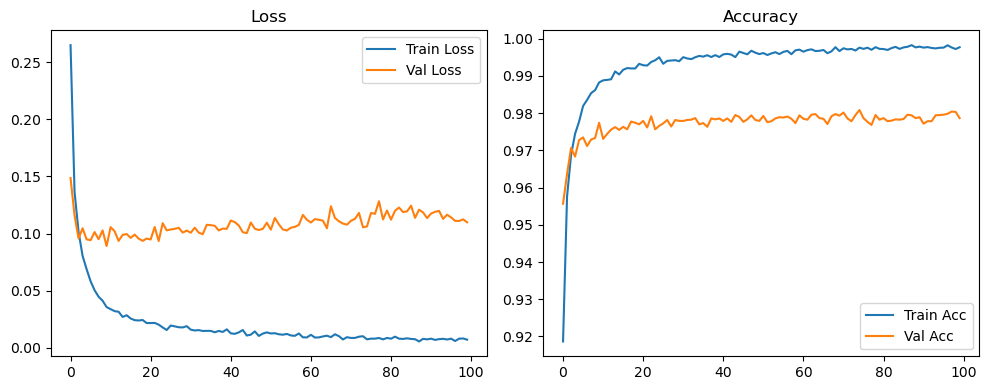

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4313, Acc: 0.8675 | Val Loss: 0.1764, Acc: 0.9455


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2465, Acc: 0.9256 | Val Loss: 0.1465, Acc: 0.9537


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2017, Acc: 0.9406 | Val Loss: 0.1229, Acc: 0.9626


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1731, Acc: 0.9490 | Val Loss: 0.1157, Acc: 0.9650


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1519, Acc: 0.9545 | Val Loss: 0.1108, Acc: 0.9670


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1431, Acc: 0.9572 | Val Loss: 0.1059, Acc: 0.9682


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1307, Acc: 0.9597 | Val Loss: 0.1035, Acc: 0.9705


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1213, Acc: 0.9637 | Val Loss: 0.0986, Acc: 0.9699


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1175, Acc: 0.9643 | Val Loss: 0.1008, Acc: 0.9710


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9664 | Val Loss: 0.0981, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1051, Acc: 0.9683 | Val Loss: 0.0947, Acc: 0.9723


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1005, Acc: 0.9696 | Val Loss: 0.0936, Acc: 0.9734


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0977, Acc: 0.9700 | Val Loss: 0.0967, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9710 | Val Loss: 0.1002, Acc: 0.9721


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9733 | Val Loss: 0.0927, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0892, Acc: 0.9724 | Val Loss: 0.0956, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9731 | Val Loss: 0.0935, Acc: 0.9731


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9743 | Val Loss: 0.0950, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9748 | Val Loss: 0.0892, Acc: 0.9748


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9776 | Val Loss: 0.0925, Acc: 0.9757


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9771 | Val Loss: 0.0931, Acc: 0.9748


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0773, Acc: 0.9770 | Val Loss: 0.0929, Acc: 0.9753


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9782 | Val Loss: 0.0964, Acc: 0.9746


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9775 | Val Loss: 0.0918, Acc: 0.9747


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9784 | Val Loss: 0.1005, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9787 | Val Loss: 0.0914, Acc: 0.9745


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9790 | Val Loss: 0.0926, Acc: 0.9737


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9801 | Val Loss: 0.0943, Acc: 0.9749


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.0975, Acc: 0.9749


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9803 | Val Loss: 0.0956, Acc: 0.9751


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9809 | Val Loss: 0.0965, Acc: 0.9752


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9812 | Val Loss: 0.0980, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.0993, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9815 | Val Loss: 0.0984, Acc: 0.9753


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9820 | Val Loss: 0.1014, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9825 | Val Loss: 0.0949, Acc: 0.9758


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9829 | Val Loss: 0.0963, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9826 | Val Loss: 0.0994, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9829 | Val Loss: 0.0948, Acc: 0.9748


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0969, Acc: 0.9762


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 0.0956, Acc: 0.9760


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9836 | Val Loss: 0.0986, Acc: 0.9757


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9841 | Val Loss: 0.0928, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9835 | Val Loss: 0.0969, Acc: 0.9754


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9825 | Val Loss: 0.0927, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9835 | Val Loss: 0.0961, Acc: 0.9757


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.0951, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.1026, Acc: 0.9774


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9844 | Val Loss: 0.0966, Acc: 0.9755


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0960, Acc: 0.9776


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.0970, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9850 | Val Loss: 0.0955, Acc: 0.9764


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.1026, Acc: 0.9759


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.1071, Acc: 0.9751


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9861 | Val Loss: 0.1004, Acc: 0.9763


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.1043, Acc: 0.9747


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 0.1072, Acc: 0.9768


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.1007, Acc: 0.9775


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.0992, Acc: 0.9774


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9872 | Val Loss: 0.0970, Acc: 0.9776


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.1024, Acc: 0.9760


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9865 | Val Loss: 0.1035, Acc: 0.9752


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.1064, Acc: 0.9758


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9869 | Val Loss: 0.1001, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9878 | Val Loss: 0.0993, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9873 | Val Loss: 0.0939, Acc: 0.9757


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.0978, Acc: 0.9782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 0.0969, Acc: 0.9767


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.1030, Acc: 0.9758


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.0965, Acc: 0.9771


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.1023, Acc: 0.9769


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9884 | Val Loss: 0.1026, Acc: 0.9759


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.1040, Acc: 0.9762


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.1027, Acc: 0.9758


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9886 | Val Loss: 0.1065, Acc: 0.9765


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9881 | Val Loss: 0.1025, Acc: 0.9766


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.1018, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.1161, Acc: 0.9748


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.1080, Acc: 0.9767


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9883 | Val Loss: 0.0986, Acc: 0.9772


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.1073, Acc: 0.9766


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.1029, Acc: 0.9778


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.1081, Acc: 0.9767


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.1038, Acc: 0.9767


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9888 | Val Loss: 0.1026, Acc: 0.9765


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9890 | Val Loss: 0.0980, Acc: 0.9772


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9888 | Val Loss: 0.1000, Acc: 0.9770


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1042, Acc: 0.9765


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.1066, Acc: 0.9767


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 0.1091, Acc: 0.9776


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.1097, Acc: 0.9748


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.1098, Acc: 0.9748


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9899 | Val Loss: 0.1063, Acc: 0.9762


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9899 | Val Loss: 0.1081, Acc: 0.9756


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.1101, Acc: 0.9759


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.1026, Acc: 0.9781


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.1121, Acc: 0.9767


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9894 | Val Loss: 0.1001, Acc: 0.9762


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.1111, Acc: 0.9761


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.1088, Acc: 0.9772


Final Test Loss: 0.0964 Accuracy: 0.9799


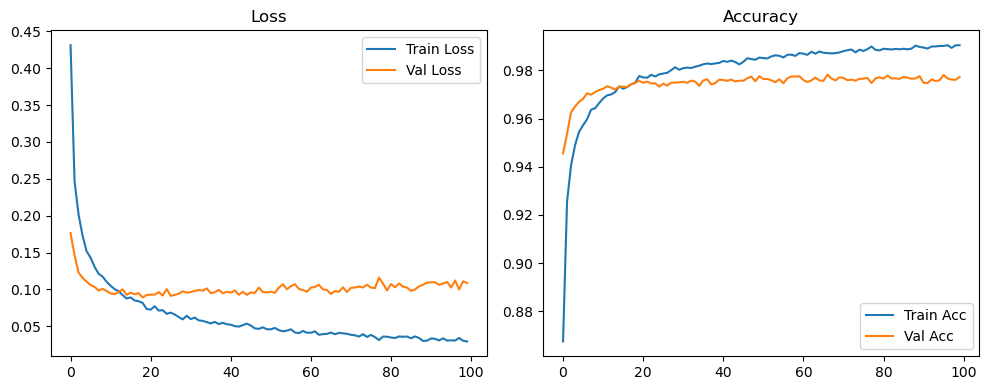

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2140, Acc: 0.9327 | Val Loss: 0.1359, Acc: 0.9584


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9696 | Val Loss: 0.1133, Acc: 0.9642


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9806 | Val Loss: 0.1142, Acc: 0.9653


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.1089, Acc: 0.9709


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.1132, Acc: 0.9696


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9904 | Val Loss: 0.1232, Acc: 0.9696


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.1199, Acc: 0.9696


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.1114, Acc: 0.9730


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1092, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1125, Acc: 0.9742


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.1161, Acc: 0.9736


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.1170, Acc: 0.9752


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1292, Acc: 0.9733


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1249, Acc: 0.9747


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1174, Acc: 0.9746


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1050, Acc: 0.9774


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1166, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1194, Acc: 0.9743


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1093, Acc: 0.9761


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1241, Acc: 0.9746


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1251, Acc: 0.9749


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1265, Acc: 0.9736


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1225, Acc: 0.9754


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1239, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1287, Acc: 0.9740


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1298, Acc: 0.9733


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1231, Acc: 0.9753


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1291, Acc: 0.9744


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1277, Acc: 0.9760


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1376, Acc: 0.9756


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1313, Acc: 0.9752


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9735


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1281, Acc: 0.9752


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1239, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1475, Acc: 0.9752


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1298, Acc: 0.9751


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1208, Acc: 0.9783


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1295, Acc: 0.9773


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1340, Acc: 0.9766


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1415, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1549, Acc: 0.9718


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1408, Acc: 0.9735


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1286, Acc: 0.9760


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1272, Acc: 0.9752


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1323, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1226, Acc: 0.9778


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1243, Acc: 0.9767


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1363, Acc: 0.9766


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1400, Acc: 0.9772


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1665, Acc: 0.9730


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1195, Acc: 0.9795


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1199, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1232, Acc: 0.9790


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1220, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1239, Acc: 0.9796


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1232, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1236, Acc: 0.9795


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1247, Acc: 0.9794


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1265, Acc: 0.9794


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1281, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1300, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1290, Acc: 0.9801


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1358, Acc: 0.9793


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1409, Acc: 0.9783


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1428, Acc: 0.9766


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1406, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1423, Acc: 0.9773


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1400, Acc: 0.9777


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1457, Acc: 0.9772


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1426, Acc: 0.9783


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1459, Acc: 0.9787


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1445, Acc: 0.9787


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1345, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1423, Acc: 0.9792


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1456, Acc: 0.9788


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1416, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1421, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1466, Acc: 0.9797


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1475, Acc: 0.9780


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1490, Acc: 0.9785


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1497, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1526, Acc: 0.9786


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1516, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1515, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1507, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1493, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1470, Acc: 0.9789


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1450, Acc: 0.9789


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1455, Acc: 0.9792


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1438, Acc: 0.9793


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1459, Acc: 0.9794


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1474, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1457, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1455, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1444, Acc: 0.9793


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1456, Acc: 0.9796


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1480, Acc: 0.9797


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1510, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1510, Acc: 0.9801


Final Test Loss: 0.1331 Accuracy: 0.9817


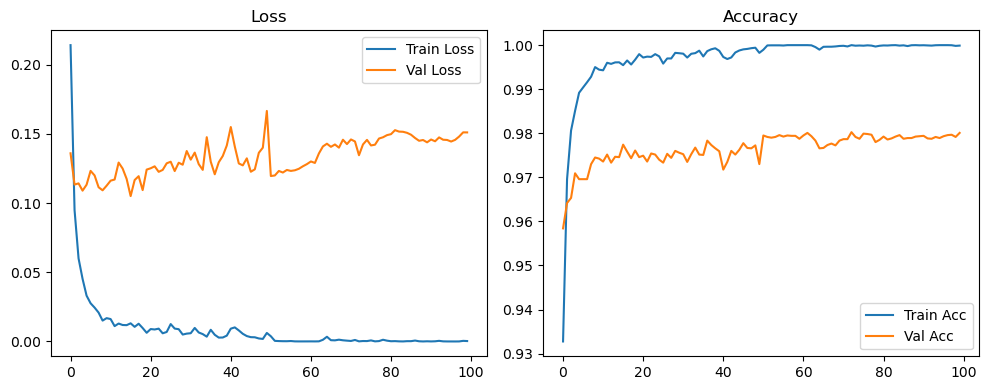

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2652, Acc: 0.9187 | Val Loss: 0.1486, Acc: 0.9557


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1364, Acc: 0.9576 | Val Loss: 0.1159, Acc: 0.9637


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1014, Acc: 0.9688 | Val Loss: 0.0956, Acc: 0.9707


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.1046, Acc: 0.9683


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9777 | Val Loss: 0.0949, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9819 | Val Loss: 0.0941, Acc: 0.9735


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9836 | Val Loss: 0.1012, Acc: 0.9712


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9854 | Val Loss: 0.0950, Acc: 0.9729


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9862 | Val Loss: 0.1027, Acc: 0.9733


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0890, Acc: 0.9774


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9888 | Val Loss: 0.1056, Acc: 0.9731


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9889 | Val Loss: 0.1020, Acc: 0.9744


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9891 | Val Loss: 0.0935, Acc: 0.9756


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0988, Acc: 0.9762


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0996, Acc: 0.9755


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0961, Acc: 0.9763


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0991, Acc: 0.9757


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0956, Acc: 0.9778


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.0935, Acc: 0.9774


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0956, Acc: 0.9770


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0948, Acc: 0.9779


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1057, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0934, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1091, Acc: 0.9757


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1028, Acc: 0.9766


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.1035, Acc: 0.9772


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1041, Acc: 0.9782


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1050, Acc: 0.9764


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.1008, Acc: 0.9782


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1026, Acc: 0.9779


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1007, Acc: 0.9779


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.1051, Acc: 0.9782


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9945 | Val Loss: 0.1008, Acc: 0.9782


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0994, Acc: 0.9787


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1077, Acc: 0.9770


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1073, Acc: 0.9773


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1068, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.1027, Acc: 0.9786


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1043, Acc: 0.9783


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.1041, Acc: 0.9786


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1114, Acc: 0.9779


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1100, Acc: 0.9786


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1070, Acc: 0.9777


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.1011, Acc: 0.9795


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1004, Acc: 0.9790


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9777


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.1042, Acc: 0.9783


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1031, Acc: 0.9794


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1041, Acc: 0.9782


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1095, Acc: 0.9779


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0988, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1010, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0991, Acc: 0.9798


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1031, Acc: 0.9796


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0989, Acc: 0.9803


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1002, Acc: 0.9808


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1053, Acc: 0.9804


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1054, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1032, Acc: 0.9815


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1033, Acc: 0.9814


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1039, Acc: 0.9812


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1026, Acc: 0.9813


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1110, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1065, Acc: 0.9810


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1082, Acc: 0.9813


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1118, Acc: 0.9805


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9818


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1101, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1088, Acc: 0.9808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1127, Acc: 0.9802


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1172, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1186, Acc: 0.9804


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1096, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1152, Acc: 0.9814


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1180, Acc: 0.9797


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1153, Acc: 0.9803


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1108, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9808


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1091, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1177, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1138, Acc: 0.9797


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1160, Acc: 0.9799


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1154, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1141, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1100, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1156, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1159, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1118, Acc: 0.9809


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1161, Acc: 0.9807


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1147, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1191, Acc: 0.9801


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1170, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1220, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1153, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1150, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1156, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1162, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1182, Acc: 0.9820


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1171, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1197, Acc: 0.9807


Final Test Loss: 0.1175 Accuracy: 0.9817


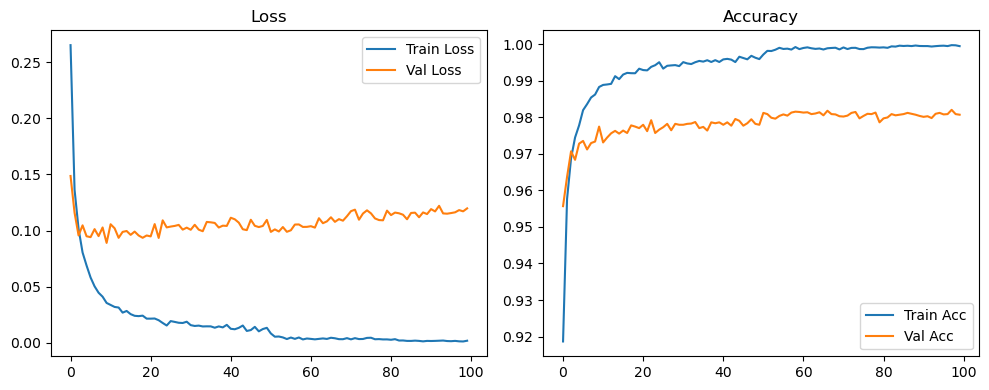

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4313, Acc: 0.8675 | Val Loss: 0.1764, Acc: 0.9455


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2465, Acc: 0.9256 | Val Loss: 0.1465, Acc: 0.9537


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2017, Acc: 0.9406 | Val Loss: 0.1229, Acc: 0.9626


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1731, Acc: 0.9490 | Val Loss: 0.1157, Acc: 0.9650


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1519, Acc: 0.9545 | Val Loss: 0.1108, Acc: 0.9670


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1431, Acc: 0.9572 | Val Loss: 0.1059, Acc: 0.9682


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1307, Acc: 0.9597 | Val Loss: 0.1035, Acc: 0.9705


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1213, Acc: 0.9637 | Val Loss: 0.0986, Acc: 0.9699


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1175, Acc: 0.9643 | Val Loss: 0.1008, Acc: 0.9710


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9664 | Val Loss: 0.0981, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1051, Acc: 0.9683 | Val Loss: 0.0947, Acc: 0.9723


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1005, Acc: 0.9696 | Val Loss: 0.0936, Acc: 0.9734


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0977, Acc: 0.9700 | Val Loss: 0.0967, Acc: 0.9728


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9710 | Val Loss: 0.1002, Acc: 0.9721


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9733 | Val Loss: 0.0927, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0892, Acc: 0.9724 | Val Loss: 0.0956, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9731 | Val Loss: 0.0935, Acc: 0.9731


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9743 | Val Loss: 0.0950, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9748 | Val Loss: 0.0892, Acc: 0.9748


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9776 | Val Loss: 0.0925, Acc: 0.9757


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9771 | Val Loss: 0.0931, Acc: 0.9748


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0773, Acc: 0.9770 | Val Loss: 0.0929, Acc: 0.9753


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0714, Acc: 0.9782 | Val Loss: 0.0964, Acc: 0.9746


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9775 | Val Loss: 0.0918, Acc: 0.9747


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9784 | Val Loss: 0.1005, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9787 | Val Loss: 0.0914, Acc: 0.9745


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9790 | Val Loss: 0.0926, Acc: 0.9737


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9801 | Val Loss: 0.0943, Acc: 0.9749


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9813 | Val Loss: 0.0975, Acc: 0.9749


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9803 | Val Loss: 0.0956, Acc: 0.9751


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9809 | Val Loss: 0.0965, Acc: 0.9752


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9812 | Val Loss: 0.0980, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.0993, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9815 | Val Loss: 0.0984, Acc: 0.9753


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9820 | Val Loss: 0.1014, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9825 | Val Loss: 0.0949, Acc: 0.9758


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9829 | Val Loss: 0.0963, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9826 | Val Loss: 0.0994, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9829 | Val Loss: 0.0948, Acc: 0.9748


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9831 | Val Loss: 0.0969, Acc: 0.9762


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 0.0956, Acc: 0.9760


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9836 | Val Loss: 0.0986, Acc: 0.9757


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9841 | Val Loss: 0.0928, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9835 | Val Loss: 0.0969, Acc: 0.9754


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9825 | Val Loss: 0.0927, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9835 | Val Loss: 0.0961, Acc: 0.9757


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.0951, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9847 | Val Loss: 0.1026, Acc: 0.9774


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9844 | Val Loss: 0.0966, Acc: 0.9755


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9853 | Val Loss: 0.0960, Acc: 0.9776


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0945, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.0953, Acc: 0.9787


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.0992, Acc: 0.9777


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1034, Acc: 0.9767


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.0988, Acc: 0.9778


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0976, Acc: 0.9777


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9918 | Val Loss: 0.1009, Acc: 0.9785


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1017, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.1026, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0984, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.1000, Acc: 0.9774


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1045, Acc: 0.9770


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1065, Acc: 0.9781


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.1041, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9923 | Val Loss: 0.1056, Acc: 0.9766


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.1003, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.1020, Acc: 0.9777


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.1031, Acc: 0.9771


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1056, Acc: 0.9762


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.1084, Acc: 0.9769


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.1080, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1082, Acc: 0.9766


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.1088, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9921 | Val Loss: 0.1068, Acc: 0.9774


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9937 | Val Loss: 0.1090, Acc: 0.9779


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9925 | Val Loss: 0.1083, Acc: 0.9781


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1076, Acc: 0.9777


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1164, Acc: 0.9763


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.1140, Acc: 0.9779


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1087, Acc: 0.9777


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1102, Acc: 0.9775


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.1121, Acc: 0.9777


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.1139, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1089, Acc: 0.9782


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.1110, Acc: 0.9774


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.1117, Acc: 0.9777


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1113, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.1127, Acc: 0.9784


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.1126, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1114, Acc: 0.9785


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.1172, Acc: 0.9766


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1127, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1181, Acc: 0.9770


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1128, Acc: 0.9779


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1158, Acc: 0.9771


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1136, Acc: 0.9777


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1140, Acc: 0.9780


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.1177, Acc: 0.9772


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1165, Acc: 0.9778


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1175, Acc: 0.9775


Final Test Loss: 0.1037 Accuracy: 0.9807


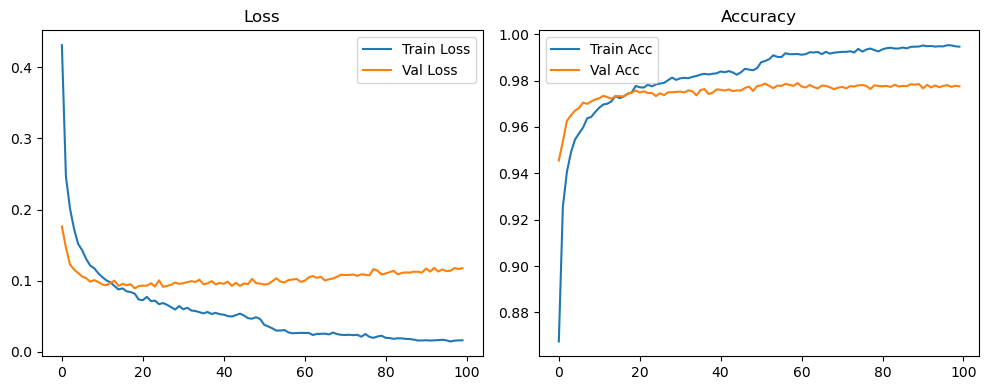

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2241, Acc: 0.9320 | Val Loss: 0.1314, Acc: 0.9582


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0854, Acc: 0.9735 | Val Loss: 0.1069, Acc: 0.9667


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9830 | Val Loss: 0.1119, Acc: 0.9665


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 0.1190, Acc: 0.9672


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0982, Acc: 0.9732


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.1115, Acc: 0.9712


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.1011, Acc: 0.9740


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1112, Acc: 0.9731


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1050, Acc: 0.9741


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.1059, Acc: 0.9747


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1103, Acc: 0.9742


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1181, Acc: 0.9725


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1122, Acc: 0.9734


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1032, Acc: 0.9741


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1246, Acc: 0.9722


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1164, Acc: 0.9741


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1194, Acc: 0.9749


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1612, Acc: 0.9681


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1229, Acc: 0.9747


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1179, Acc: 0.9758


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1274, Acc: 0.9752


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1267, Acc: 0.9722


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1183, Acc: 0.9742


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1379, Acc: 0.9717


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1120, Acc: 0.9777


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1134, Acc: 0.9768


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1142, Acc: 0.9778


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1236, Acc: 0.9764


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1226, Acc: 0.9750


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1388, Acc: 0.9721


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1261, Acc: 0.9752


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1138, Acc: 0.9771


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1297, Acc: 0.9748


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1214, Acc: 0.9757


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1174, Acc: 0.9781


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1201, Acc: 0.9772


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1317, Acc: 0.9772


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1356, Acc: 0.9739


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1376, Acc: 0.9751


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1276, Acc: 0.9738


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1342, Acc: 0.9754


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1322, Acc: 0.9753


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1346, Acc: 0.9744


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1306, Acc: 0.9765


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1319, Acc: 0.9757


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1273, Acc: 0.9757


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1169, Acc: 0.9778


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1233, Acc: 0.9766


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1215, Acc: 0.9788


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1128, Acc: 0.9793


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1266, Acc: 0.9767


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1359, Acc: 0.9756


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1169, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1140, Acc: 0.9786


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1227, Acc: 0.9769


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9780


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1288, Acc: 0.9754


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1456, Acc: 0.9749


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1347, Acc: 0.9760


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1244, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1215, Acc: 0.9771


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1245, Acc: 0.9780


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1134, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1246, Acc: 0.9789


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1320, Acc: 0.9780


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1588, Acc: 0.9732


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1327, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1257, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1202, Acc: 0.9788


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1249, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1323, Acc: 0.9777


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1364, Acc: 0.9765


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1413, Acc: 0.9758


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1377, Acc: 0.9753


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1230, Acc: 0.9778


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1212, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1238, Acc: 0.9790


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1187, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1197, Acc: 0.9793


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1150, Acc: 0.9810


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1132, Acc: 0.9808


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1597, Acc: 0.9753


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1294, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1316, Acc: 0.9774


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1331, Acc: 0.9756


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1338, Acc: 0.9775


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1349, Acc: 0.9783


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1389, Acc: 0.9775


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1254, Acc: 0.9789


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1298, Acc: 0.9785


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1268, Acc: 0.9787


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1431, Acc: 0.9769


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1508, Acc: 0.9769


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1392, Acc: 0.9764


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1530, Acc: 0.9752


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1348, Acc: 0.9778


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1337, Acc: 0.9777


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1312, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1373, Acc: 0.9783


Final Test Loss: 0.1160 Accuracy: 0.9803


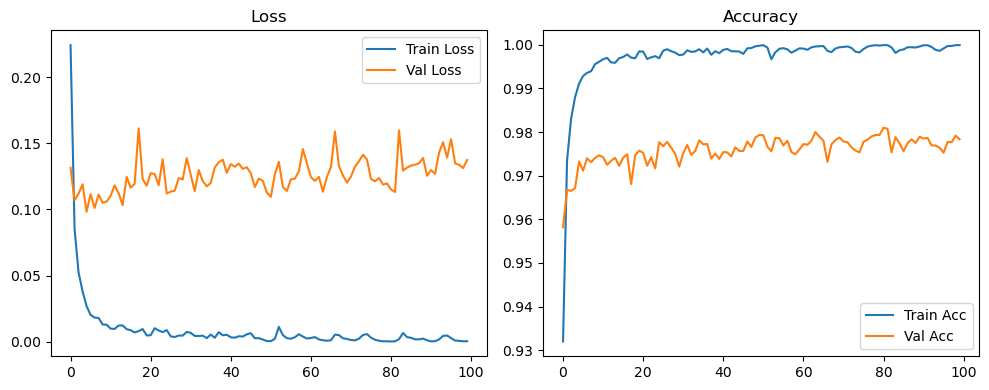

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2891, Acc: 0.9138 | Val Loss: 0.1376, Acc: 0.9582


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1339, Acc: 0.9583 | Val Loss: 0.1175, Acc: 0.9627


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1018, Acc: 0.9673 | Val Loss: 0.1000, Acc: 0.9702


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0797, Acc: 0.9750 | Val Loss: 0.0958, Acc: 0.9713


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9792 | Val Loss: 0.0901, Acc: 0.9733


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9822 | Val Loss: 0.0912, Acc: 0.9730


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9834 | Val Loss: 0.0920, Acc: 0.9745


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9856 | Val Loss: 0.0912, Acc: 0.9733


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.0968, Acc: 0.9742


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0896, Acc: 0.9758


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.0925, Acc: 0.9742


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.0906, Acc: 0.9769


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0940, Acc: 0.9750


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9911 | Val Loss: 0.0993, Acc: 0.9744


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9921 | Val Loss: 0.0972, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9918 | Val Loss: 0.0958, Acc: 0.9765


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9917 | Val Loss: 0.0992, Acc: 0.9760


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9921 | Val Loss: 0.0949, Acc: 0.9776


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0988, Acc: 0.9752


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0985, Acc: 0.9768


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1007, Acc: 0.9764


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0951, Acc: 0.9776


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.1011, Acc: 0.9772


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1006, Acc: 0.9762


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9938 | Val Loss: 0.1046, Acc: 0.9758


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0985, Acc: 0.9773


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.0985, Acc: 0.9779


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0994, Acc: 0.9782


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9948 | Val Loss: 0.1043, Acc: 0.9778


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1100, Acc: 0.9772


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1132, Acc: 0.9766


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.1033, Acc: 0.9773


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1057, Acc: 0.9780


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.1135, Acc: 0.9773


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1151, Acc: 0.9775


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1086, Acc: 0.9778


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1120, Acc: 0.9779


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1010, Acc: 0.9786


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1086, Acc: 0.9772


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1088, Acc: 0.9768


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1137, Acc: 0.9764


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1080, Acc: 0.9788


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1180, Acc: 0.9767


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1090, Acc: 0.9782


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1048, Acc: 0.9790


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9960 | Val Loss: 0.1108, Acc: 0.9778


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1082, Acc: 0.9788


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1077, Acc: 0.9796


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1107, Acc: 0.9785


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1128, Acc: 0.9780


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1197, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1239, Acc: 0.9765


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1120, Acc: 0.9787


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1117, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1221, Acc: 0.9767


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1199, Acc: 0.9771


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1099, Acc: 0.9789


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1088, Acc: 0.9788


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1137, Acc: 0.9774


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1173, Acc: 0.9778


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.1121, Acc: 0.9786


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1113, Acc: 0.9784


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1125, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1123, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1109, Acc: 0.9790


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1096, Acc: 0.9786


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1092, Acc: 0.9789


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1059, Acc: 0.9798


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1123, Acc: 0.9779


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1142, Acc: 0.9774


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1034, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1128, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1058, Acc: 0.9792


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1095, Acc: 0.9791


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1131, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1142, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1071, Acc: 0.9788


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1078, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1123, Acc: 0.9784


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1060, Acc: 0.9792


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1096, Acc: 0.9789


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1090, Acc: 0.9786


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1157, Acc: 0.9779


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1166, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1178, Acc: 0.9786


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1158, Acc: 0.9784


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1113, Acc: 0.9797


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1168, Acc: 0.9789


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1108, Acc: 0.9799


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1166, Acc: 0.9788


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1189, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1197, Acc: 0.9791


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1246, Acc: 0.9781


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1192, Acc: 0.9785


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1141, Acc: 0.9795


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1234, Acc: 0.9778


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1186, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1127, Acc: 0.9800


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1190, Acc: 0.9790


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1154, Acc: 0.9792


Final Test Loss: 0.1004 Accuracy: 0.9819


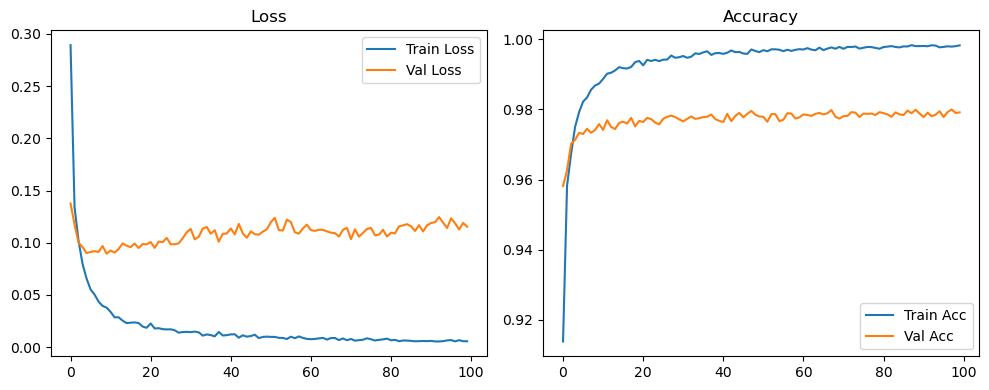

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4975, Acc: 0.8493 | Val Loss: 0.1841, Acc: 0.9431


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2562, Acc: 0.9232 | Val Loss: 0.1528, Acc: 0.9516


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2089, Acc: 0.9374 | Val Loss: 0.1297, Acc: 0.9607


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1816, Acc: 0.9450 | Val Loss: 0.1203, Acc: 0.9625


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1600, Acc: 0.9516 | Val Loss: 0.1087, Acc: 0.9671


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1437, Acc: 0.9575 | Val Loss: 0.1066, Acc: 0.9683


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1313, Acc: 0.9598 | Val Loss: 0.1055, Acc: 0.9677


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1261, Acc: 0.9614 | Val Loss: 0.0972, Acc: 0.9708


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1169, Acc: 0.9641 | Val Loss: 0.0974, Acc: 0.9715


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1107, Acc: 0.9658 | Val Loss: 0.0935, Acc: 0.9728


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1034, Acc: 0.9681 | Val Loss: 0.0948, Acc: 0.9718


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0977, Acc: 0.9704 | Val Loss: 0.0916, Acc: 0.9736


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0936, Acc: 0.9707 | Val Loss: 0.0955, Acc: 0.9735


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0918, Acc: 0.9715 | Val Loss: 0.0923, Acc: 0.9727


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0844, Acc: 0.9738 | Val Loss: 0.0928, Acc: 0.9729


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0847, Acc: 0.9734 | Val Loss: 0.0907, Acc: 0.9744


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9744 | Val Loss: 0.0884, Acc: 0.9750


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0794, Acc: 0.9752 | Val Loss: 0.0896, Acc: 0.9745


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0769, Acc: 0.9762 | Val Loss: 0.0871, Acc: 0.9757


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0721, Acc: 0.9776 | Val Loss: 0.0846, Acc: 0.9765


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0738, Acc: 0.9767 | Val Loss: 0.0847, Acc: 0.9761


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9786 | Val Loss: 0.0875, Acc: 0.9753


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9782 | Val Loss: 0.0852, Acc: 0.9770


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9794 | Val Loss: 0.0923, Acc: 0.9748


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9795 | Val Loss: 0.0921, Acc: 0.9754


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9804 | Val Loss: 0.0845, Acc: 0.9772


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9794 | Val Loss: 0.0891, Acc: 0.9765


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9809 | Val Loss: 0.0927, Acc: 0.9750


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9820 | Val Loss: 0.0907, Acc: 0.9759


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9816 | Val Loss: 0.0898, Acc: 0.9767


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.0937, Acc: 0.9752


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9817 | Val Loss: 0.0905, Acc: 0.9770


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.0891, Acc: 0.9766


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9827 | Val Loss: 0.0923, Acc: 0.9764


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9836 | Val Loss: 0.0932, Acc: 0.9764


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.0963, Acc: 0.9766


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.0927, Acc: 0.9762


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0914, Acc: 0.9771


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9841 | Val Loss: 0.0908, Acc: 0.9771


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.0946, Acc: 0.9760


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9846 | Val Loss: 0.0951, Acc: 0.9763


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9854 | Val Loss: 0.0952, Acc: 0.9777


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9846 | Val Loss: 0.0929, Acc: 0.9768


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9858 | Val Loss: 0.0914, Acc: 0.9772


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9846 | Val Loss: 0.0912, Acc: 0.9769


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9857 | Val Loss: 0.0907, Acc: 0.9774


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0448, Acc: 0.9853 | Val Loss: 0.0946, Acc: 0.9769


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.0967, Acc: 0.9758


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9868 | Val Loss: 0.0923, Acc: 0.9771


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9871 | Val Loss: 0.0954, Acc: 0.9782


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9867 | Val Loss: 0.0906, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9861 | Val Loss: 0.0945, Acc: 0.9772


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.0962, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9874 | Val Loss: 0.0962, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9878 | Val Loss: 0.0948, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9882 | Val Loss: 0.0974, Acc: 0.9760


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9873 | Val Loss: 0.0950, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9870 | Val Loss: 0.0931, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0948, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.0931, Acc: 0.9790


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0958, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9871 | Val Loss: 0.0971, Acc: 0.9774


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.0997, Acc: 0.9770


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0935, Acc: 0.9775


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.0946, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9883 | Val Loss: 0.0947, Acc: 0.9776


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0943, Acc: 0.9773


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.0920, Acc: 0.9781


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.0950, Acc: 0.9781


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.0968, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9881 | Val Loss: 0.0977, Acc: 0.9775


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.0976, Acc: 0.9764


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.1014, Acc: 0.9762


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0930, Acc: 0.9776


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0965, Acc: 0.9776


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9900 | Val Loss: 0.0944, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0923, Acc: 0.9779


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0964, Acc: 0.9783


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0952, Acc: 0.9771


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.0923, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0977, Acc: 0.9771


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1003, Acc: 0.9768


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.0978, Acc: 0.9772


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0957, Acc: 0.9781


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.1006, Acc: 0.9765


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.1011, Acc: 0.9781


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.0972, Acc: 0.9786


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1022, Acc: 0.9768


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.0997, Acc: 0.9785


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9910 | Val Loss: 0.1012, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.0997, Acc: 0.9775


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.0974, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.1038, Acc: 0.9774


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0965, Acc: 0.9783


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0995, Acc: 0.9792


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.1025, Acc: 0.9776


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.1031, Acc: 0.9777


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.1021, Acc: 0.9771


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9917 | Val Loss: 0.1047, Acc: 0.9778


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.1038, Acc: 0.9775


Final Test Loss: 0.0951 Accuracy: 0.9784


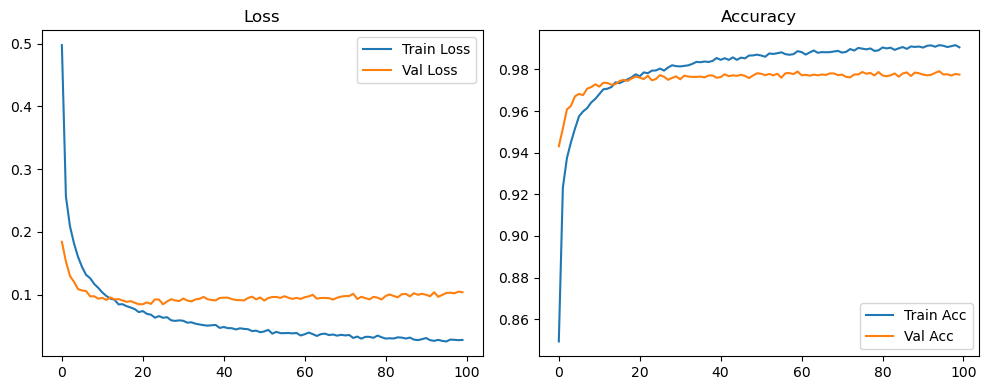

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2565, Acc: 0.9267 | Val Loss: 0.1268, Acc: 0.9623


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0832, Acc: 0.9746 | Val Loss: 0.1046, Acc: 0.9671


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9850 | Val Loss: 0.1125, Acc: 0.9663


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.1012, Acc: 0.9700


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.0953, Acc: 0.9742


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.1150, Acc: 0.9682


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1053, Acc: 0.9721


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1006, Acc: 0.9732


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1034, Acc: 0.9743


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0976, Acc: 0.9758


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1138, Acc: 0.9717


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1026, Acc: 0.9741


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1070, Acc: 0.9738


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1101, Acc: 0.9732


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1111, Acc: 0.9728


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1101, Acc: 0.9738


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1161, Acc: 0.9728


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1132, Acc: 0.9748


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1292, Acc: 0.9723


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1104, Acc: 0.9760


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1256, Acc: 0.9727


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1185, Acc: 0.9737


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1309, Acc: 0.9742


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1267, Acc: 0.9740


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1315, Acc: 0.9714


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1218, Acc: 0.9732


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1277, Acc: 0.9734


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1212, Acc: 0.9752


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1150, Acc: 0.9772


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1127, Acc: 0.9776


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1231, Acc: 0.9738


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1246, Acc: 0.9767


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1180, Acc: 0.9750


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1122, Acc: 0.9782


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1177, Acc: 0.9769


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1155, Acc: 0.9756


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1191, Acc: 0.9757


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9989 | Val Loss: 0.1296, Acc: 0.9742


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1187, Acc: 0.9765


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1216, Acc: 0.9767


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1161, Acc: 0.9769


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1194, Acc: 0.9762


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1236, Acc: 0.9754


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1175, Acc: 0.9767


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1167, Acc: 0.9778


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1191, Acc: 0.9777


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1155, Acc: 0.9783


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1221, Acc: 0.9771


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1354, Acc: 0.9756


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1413, Acc: 0.9724


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1175, Acc: 0.9769


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1203, Acc: 0.9770


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1247, Acc: 0.9764


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1254, Acc: 0.9763


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1261, Acc: 0.9766


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1254, Acc: 0.9776


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1291, Acc: 0.9772


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1227, Acc: 0.9778


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1311, Acc: 0.9758


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1320, Acc: 0.9762


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1230, Acc: 0.9773


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1440, Acc: 0.9751


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1258, Acc: 0.9770


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1207, Acc: 0.9784


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1338, Acc: 0.9771


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1339, Acc: 0.9768


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1316, Acc: 0.9762


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1340, Acc: 0.9754


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1329, Acc: 0.9772


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1333, Acc: 0.9766


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1392, Acc: 0.9770


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1400, Acc: 0.9773


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1409, Acc: 0.9758


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1362, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1293, Acc: 0.9773


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1318, Acc: 0.9769


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1316, Acc: 0.9763


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1339, Acc: 0.9770


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1320, Acc: 0.9772


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1266, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1253, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1269, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1282, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9795


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1220, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1211, Acc: 0.9795


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1577, Acc: 0.9725


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1453, Acc: 0.9751


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1312, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1177, Acc: 0.9780


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1163, Acc: 0.9794


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1203, Acc: 0.9791


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1169, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1186, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1239, Acc: 0.9787


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1229, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1308, Acc: 0.9760


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1416, Acc: 0.9764


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1326, Acc: 0.9779


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1398, Acc: 0.9770


Final Test Loss: 0.1268 Accuracy: 0.9792


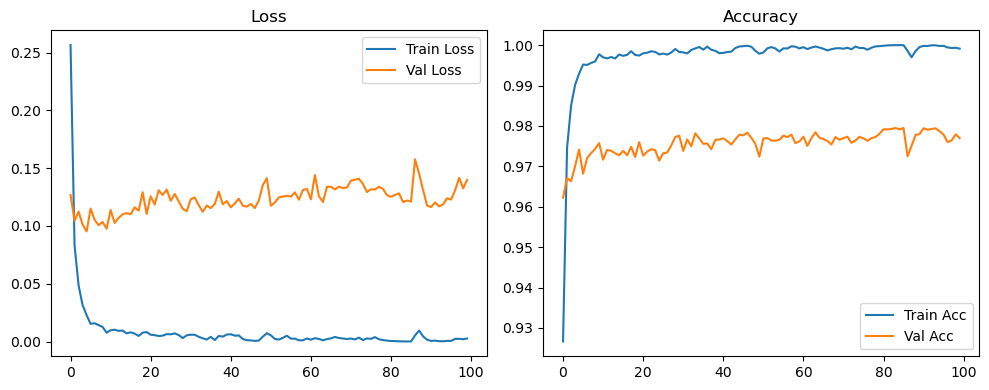

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3459, Acc: 0.9015 | Val Loss: 0.1405, Acc: 0.9571


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1406, Acc: 0.9568 | Val Loss: 0.1158, Acc: 0.9634


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1047, Acc: 0.9671 | Val Loss: 0.1029, Acc: 0.9685


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0803, Acc: 0.9750 | Val Loss: 0.1005, Acc: 0.9697


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9778 | Val Loss: 0.0930, Acc: 0.9726


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0578, Acc: 0.9813 | Val Loss: 0.0924, Acc: 0.9719


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9828 | Val Loss: 0.0930, Acc: 0.9726


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9845 | Val Loss: 0.0919, Acc: 0.9727


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9869 | Val Loss: 0.0939, Acc: 0.9734


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9883 | Val Loss: 0.0931, Acc: 0.9750


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9885 | Val Loss: 0.0886, Acc: 0.9750


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.0935, Acc: 0.9742


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.1001, Acc: 0.9729


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0924, Acc: 0.9759


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0935, Acc: 0.9760


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9914 | Val Loss: 0.0937, Acc: 0.9763


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.0931, Acc: 0.9769


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.0936, Acc: 0.9759


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.0925, Acc: 0.9762


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.1020, Acc: 0.9755


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9927 | Val Loss: 0.0962, Acc: 0.9770


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9936 | Val Loss: 0.0947, Acc: 0.9772


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0972, Acc: 0.9782


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1033, Acc: 0.9754


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.0919, Acc: 0.9779


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0931, Acc: 0.9788


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9943 | Val Loss: 0.0916, Acc: 0.9789


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0974, Acc: 0.9780


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0936, Acc: 0.9781


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0979, Acc: 0.9772


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0986, Acc: 0.9772


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0950, Acc: 0.9786


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0949, Acc: 0.9783


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1008, Acc: 0.9775


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1070, Acc: 0.9779


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1029, Acc: 0.9775


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1021, Acc: 0.9772


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0998, Acc: 0.9782


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.1013, Acc: 0.9790


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1027, Acc: 0.9775


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.1020, Acc: 0.9778


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0998, Acc: 0.9781


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0984, Acc: 0.9784


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0970, Acc: 0.9787


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0992, Acc: 0.9782


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1037, Acc: 0.9777


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1017, Acc: 0.9783


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1069, Acc: 0.9780


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0997, Acc: 0.9783


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1059, Acc: 0.9777


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1055, Acc: 0.9772


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1017, Acc: 0.9792


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1128, Acc: 0.9778


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1028, Acc: 0.9794


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1106, Acc: 0.9786


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1067, Acc: 0.9788


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1077, Acc: 0.9793


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1058, Acc: 0.9792


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1024, Acc: 0.9792


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1053, Acc: 0.9790


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0992, Acc: 0.9796


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1096, Acc: 0.9771


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1046, Acc: 0.9792


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1017, Acc: 0.9782


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1073, Acc: 0.9786


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1058, Acc: 0.9802


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1001, Acc: 0.9788


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1016, Acc: 0.9794


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0991, Acc: 0.9790


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9787


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1082, Acc: 0.9779


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1124, Acc: 0.9777


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1079, Acc: 0.9781


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1086, Acc: 0.9794


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1003, Acc: 0.9792


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1050, Acc: 0.9793


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1070, Acc: 0.9786


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1140, Acc: 0.9786


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1178, Acc: 0.9781


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1134, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1046, Acc: 0.9795


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1048, Acc: 0.9800


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1100, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1007, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1051, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1054, Acc: 0.9804


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1200, Acc: 0.9781


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1100, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1088, Acc: 0.9794


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1066, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1232, Acc: 0.9783


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1178, Acc: 0.9776


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1159, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1145, Acc: 0.9779


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1043, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1113, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1160, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1172, Acc: 0.9787


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1120, Acc: 0.9796


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1150, Acc: 0.9798


Final Test Loss: 0.1089 Accuracy: 0.9816


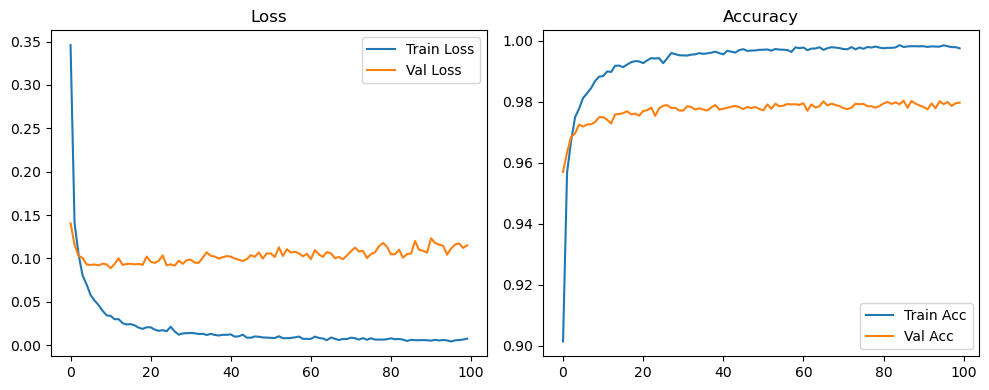

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6119, Acc: 0.8177 | Val Loss: 0.2137, Acc: 0.9361


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2837, Acc: 0.9149 | Val Loss: 0.1675, Acc: 0.9469


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2325, Acc: 0.9303 | Val Loss: 0.1434, Acc: 0.9568


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1974, Acc: 0.9403 | Val Loss: 0.1295, Acc: 0.9583


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1746, Acc: 0.9467 | Val Loss: 0.1194, Acc: 0.9637


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1603, Acc: 0.9518 | Val Loss: 0.1158, Acc: 0.9645


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1457, Acc: 0.9546 | Val Loss: 0.1167, Acc: 0.9649


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1373, Acc: 0.9579 | Val Loss: 0.1024, Acc: 0.9691


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1301, Acc: 0.9586 | Val Loss: 0.1016, Acc: 0.9707


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1218, Acc: 0.9630 | Val Loss: 0.1022, Acc: 0.9705


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1134, Acc: 0.9649 | Val Loss: 0.0966, Acc: 0.9713


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1064, Acc: 0.9679 | Val Loss: 0.0978, Acc: 0.9708


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1024, Acc: 0.9679 | Val Loss: 0.0967, Acc: 0.9718


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0986, Acc: 0.9694 | Val Loss: 0.0909, Acc: 0.9733


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0925, Acc: 0.9711 | Val Loss: 0.0944, Acc: 0.9733


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0900, Acc: 0.9716 | Val Loss: 0.0953, Acc: 0.9732


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0913, Acc: 0.9712 | Val Loss: 0.0930, Acc: 0.9739


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9730 | Val Loss: 0.0905, Acc: 0.9745


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0822, Acc: 0.9744 | Val Loss: 0.0917, Acc: 0.9742


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0772, Acc: 0.9752 | Val Loss: 0.0885, Acc: 0.9751


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9746 | Val Loss: 0.0916, Acc: 0.9747


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9758 | Val Loss: 0.0917, Acc: 0.9743


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9767 | Val Loss: 0.0920, Acc: 0.9742


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9763 | Val Loss: 0.0932, Acc: 0.9734


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0663, Acc: 0.9792 | Val Loss: 0.0953, Acc: 0.9748


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9779 | Val Loss: 0.0893, Acc: 0.9762


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0634, Acc: 0.9794 | Val Loss: 0.0918, Acc: 0.9754


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0602, Acc: 0.9808 | Val Loss: 0.0907, Acc: 0.9758


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0647, Acc: 0.9797 | Val Loss: 0.0894, Acc: 0.9750


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.0877, Acc: 0.9762


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0574, Acc: 0.9819 | Val Loss: 0.0915, Acc: 0.9758


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0604, Acc: 0.9807 | Val Loss: 0.0904, Acc: 0.9752


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9826 | Val Loss: 0.0878, Acc: 0.9759


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9815 | Val Loss: 0.0897, Acc: 0.9756


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9826 | Val Loss: 0.0912, Acc: 0.9769


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9826 | Val Loss: 0.0891, Acc: 0.9768


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9831 | Val Loss: 0.0891, Acc: 0.9770


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9838 | Val Loss: 0.0892, Acc: 0.9760


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0535, Acc: 0.9837 | Val Loss: 0.0913, Acc: 0.9763


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9839 | Val Loss: 0.0917, Acc: 0.9754


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0906, Acc: 0.9765


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9837 | Val Loss: 0.0889, Acc: 0.9765


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9841 | Val Loss: 0.0949, Acc: 0.9758


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9858 | Val Loss: 0.0879, Acc: 0.9778


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.0906, Acc: 0.9768


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9855 | Val Loss: 0.0928, Acc: 0.9769


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9846 | Val Loss: 0.0911, Acc: 0.9774


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9853 | Val Loss: 0.0948, Acc: 0.9752


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 0.0907, Acc: 0.9767


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9864 | Val Loss: 0.0895, Acc: 0.9778


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.0914, Acc: 0.9764


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.0894, Acc: 0.9782


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.0889, Acc: 0.9780


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0941, Acc: 0.9770


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.0921, Acc: 0.9772


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.0947, Acc: 0.9765


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9873 | Val Loss: 0.0950, Acc: 0.9772


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.0954, Acc: 0.9762


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9870 | Val Loss: 0.0992, Acc: 0.9763


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 0.0953, Acc: 0.9774


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0958, Acc: 0.9771


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9880 | Val Loss: 0.0984, Acc: 0.9768


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.0971, Acc: 0.9770


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0951, Acc: 0.9772


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.0936, Acc: 0.9785


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 0.0950, Acc: 0.9769


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0949, Acc: 0.9775


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.0938, Acc: 0.9778


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9894 | Val Loss: 0.0969, Acc: 0.9774


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0989, Acc: 0.9763


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 0.1009, Acc: 0.9763


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9890 | Val Loss: 0.0969, Acc: 0.9776


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.0966, Acc: 0.9774


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0951, Acc: 0.9777


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9892 | Val Loss: 0.0950, Acc: 0.9773


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1024, Acc: 0.9766


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.0956, Acc: 0.9783


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1005, Acc: 0.9767


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0961, Acc: 0.9778


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1010, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9893 | Val Loss: 0.1005, Acc: 0.9770


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.1024, Acc: 0.9775


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9896 | Val Loss: 0.1012, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0997, Acc: 0.9773


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.1042, Acc: 0.9768


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.1048, Acc: 0.9762


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9901 | Val Loss: 0.1018, Acc: 0.9767


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.0999, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.1028, Acc: 0.9764


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.1008, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9900 | Val Loss: 0.1007, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9907 | Val Loss: 0.1043, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9902 | Val Loss: 0.1029, Acc: 0.9779


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.1033, Acc: 0.9761


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9910 | Val Loss: 0.0988, Acc: 0.9774


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.1035, Acc: 0.9771


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.0982, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9910 | Val Loss: 0.1004, Acc: 0.9772


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.1007, Acc: 0.9782


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.1024, Acc: 0.9775


Final Test Loss: 0.0876 Accuracy: 0.9799


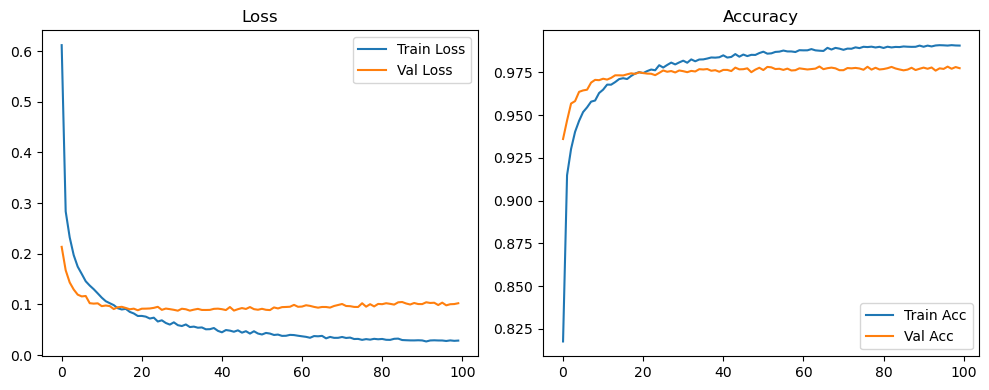

🏆 Best Config: batch128_lr0.005_0.002_0.001_dp0.2 Accuracy: 0.9846


In [8]:
root_path = "MLP_256_8bit_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)